this is primarily based on DOI:10.1038/s41534-021-00420-3

All parameter of the algorithm can befound by searching for `#parameter`

In [1]:
from copy import deepcopy
from numpy.linalg import matrix_power
from scipy.linalg import eig
import tqdm
import os

In [2]:
%load_ext autoreload
%autoreload 1
%aimport library
from library import *

In [3]:
if False:
    from qiskit_ibm_provider import IBMProvider
    try:
        provider = IBMProvider()#hub='ibm-q')
    except:
        print("you need to save the API Token of your IBMQ-Account first")
        print("use `IBMProvider.save_account(token=<INSERT_IBM_QUANTUM_TOKEN>)` once")
        raise


## functions for memory tracing

usefull when to much memory is used. Can generate a report what consumes memory but slows down everything

In [4]:
import linecache
import os
import tracemalloc

In [5]:
tracemalloc.start()

In [6]:
def display_top(snapshot, key_type='lineno', limit=10):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        print("#%s: %s:%s: %.1f KiB"
              % (index, frame.filename, frame.lineno, stat.size / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f KiB" % (len(other), size / 1024))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f KiB" % (total / 1024))

# time evolution operator

In [4]:
from qiskit.quantum_info.operators import Operator
from scipy.linalg import expm
from copy import deepcopy

def create_time_evolution_gate_from_hamiltonian(H, dt):
    """
    H is given in units of hbar/s
    dt in s

    #TODO make it more performant by accepting H in form of a combination of Pauli matrices
    currently it converts them to numpy array calculates e^(i*H*dt) and creates an operator from that.
    """
    if isinstance(H, SparsePauliOp):
        H = H.to_matrix()
    N_qubits = np.log2(H.shape[0])
    assert N_qubits % 1 == 0, "shape of H is not of form 2^n."
    N_qubits = int(N_qubits)
    # factor 2 because this W will act both for W_odd and W_even.
    time_evolution_op = Operator(expm(-1j*H*dt*2))
    
    qc = QuantumCircuit(N_qubits, name='W')
    qc.unitary(time_evolution_op, range(N_qubits))
    return qc.to_instruction()
    

In [5]:
# third hamiltonian: transverse field Ising model
def hamiltonian_tfi_model(factor_ZZ, factor_X):
    """
    returns the H_odd for the transverse field Ising model.
    """
    #Z = np.array([[1,0],[0,-1]])
    #X = np.array([[0,1],[1,0]])
    Id = SparsePauliOp("I")
    Z = SparsePauliOp("Z")
    X = SparsePauliOp("X")
    # the X summand gets split up into two parts one for each lattice site to preserve translation invarianz
    #H = factor_ZZ * np.kron(Z, Z) + factor_X/2 * np.kron(X, np.eye(2)) + factor_X/2 * np.kron(np.eye(2), X)
    H = (factor_ZZ * Z ^ Z) + factor_X/2 * ( (X ^ Id) + (Id ^ X) )
    
    return H
    


In [6]:
#parameter
reps = 3
np.random.seed(9)
U_param_values = np.random.random(reps*4)
mps = iMPS(create_V_gate("V", 1), create_U_gate("U", 1,1, reps=reps), U_param_values)
mps.V_optimization_kwargs["tolerance"] = 1e-9
braMPS = iMPS(create_V_gate("V'", 1), create_U_gate("U'", 1,1,reps=reps), U_param_values)

In [7]:
from qiskit.quantum_info.operators import Operator

# find ground state
def get_ground_state(H):
    if type(H) == np.ndarray:
        H = Operator(H)

    def cost_func(U_params):
        mps.set_U_params(U_params)
        job = mps.measure_observable(H)
        res = job.result().values[0]
        del job
        return res
        

    res = scipy.optimize.minimize(cost_func, list(mps.U_params.values()),
                   method="Nelder-Mead",
                   options={"maxiter": 10000},
                   tol=1e-8)
    print(res)
    return res.x

## define the system

In [8]:
# The parameters where taken from the qmps code from the paper DOI:10.1038/s41534-021-00420-3 (time-evolution)
# look at :/qmps/loschmidts/mps_loschmidts.py in their repo
# I do this to be able to compare my results to theirs.

#parameter
g0, g1 = 1, .2
H_params_for_ground_state = {"factor_ZZ": 1, "factor_X": g0}
H_params_after_Quench = {"factor_ZZ": 1, "factor_X": g1}
delta_t = .01
W = create_time_evolution_gate_from_hamiltonian(hamiltonian_tfi_model(**H_params_after_Quench), delta_t)

In [9]:
# test W (should be id up to O(dt) )
get_matrix_for_gate(W, precission=4)

Operator([[ 0.9998-0.02j ,  0.    -0.002j, -0.    -0.002j, -0.    +0.j   ],
          [-0.    -0.002j,  0.9998+0.02j , -0.    -0.j   ,  0.    -0.002j],
          [ 0.    -0.002j, -0.    -0.j   ,  0.9998+0.02j ,  0.    -0.002j],
          [-0.    +0.j   , -0.    -0.002j, -0.    -0.002j,  0.9998-0.02j ]],
         input_dims=(2, 2), output_dims=(2, 2))

### find ground state

In [ ]:
import time
print(time.ctime())
ground_state_U_params = get_ground_state(hamiltonian_tfi_model(**H_params_for_ground_state))
print(time.ctime())

In [ ]:
mps.measure_observable(hamiltonian_tfi_model(**H_params_for_ground_state)).result().values[0]

In [ ]:
file_name = f"ground_state_params_{reps}cnot_in_U__g={g0}_with_zz:1_3.csv"
assert not os.path.exists(file_name), "file exists!!!"
np.savetxt(file_name, np.array(ground_state_U_params), delimiter=",")

### load ground state

In [10]:
# set ground state to some values from a csv
ground_state_U_params = np.genfromtxt(f"results/ground_state_params_{reps}cnot_in_U__g={g0}_with_zz:1_3.csv")

In [11]:
ground_state_U_params

array([ 0.06030611, -1.22534248,  0.97633199,  0.95880226, -0.79413818,
       -0.69745157, -0.2986008 , -1.21088361,  0.00862383,  1.53706769,
        0.01016947,  2.19169088])

In [12]:
mps.set_U_params(ground_state_U_params)

In [13]:
mps.measure_observable(hamiltonian_tfi_model(**H_params_for_ground_state)).result().values[0]

/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


-1.2696111774748269

# circuits

R


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/qiskit/visualization/circuit/qcstyle.py:315: UserWarning: style option/s (usepiformat, latexdrawerstyle) is/are not supported
  set_style(current_style, json_style)


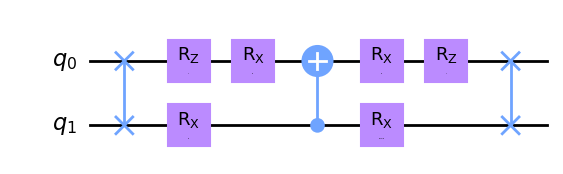

R^*


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/qiskit/visualization/circuit/qcstyle.py:315: UserWarning: style option/s (usepiformat, latexdrawerstyle) is/are not supported
  set_style(current_style, json_style)


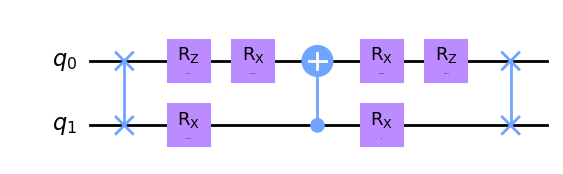

L


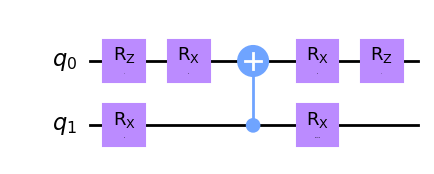

L^*


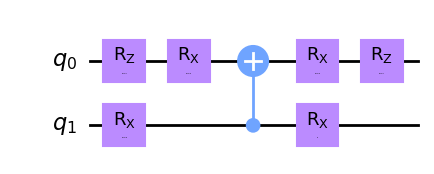

In [14]:
def create_mixed_env_circuit(params, name):
    qc = QuantumCircuit(2, name=name)
    if name=="R":
        qc.swap(0,1)
    qc.rz(params[0], 0)
    qc.rx(params[1], 0)
    
    qc.rx(params[2], 1)
    qc.cx(1,0)
    qc.rx(-params[2], 1)
    
    qc.rx(params[1], 0)
    qc.rz(params[0], 0)
    if name == "R":
        qc.swap(0,1)
    print(name)
    display(qc.draw())
    return qc.to_instruction()

def create_conjugated_mixed_env_circuit(params, name):
    """
    conjugating the whole matrix can be done by conjugating each gate.
    This means changing the sign for rx and rz while leaving it the same for ry.
    """
    qc = QuantumCircuit(2, name=name)
    if name[0]=="R":
        qc.swap(0,1)
    qc.rz(-params[0], 0)
    qc.rx(-params[1], 0)
    
    qc.rx(-params[2], 1)
    qc.cx(1,0)
    qc.rx(params[2], 1)
    
    qc.rx(-params[1], 0)
    qc.rz(-params[0], 0)
    if name[0] == "R":
        qc.swap(0,1)
    print(name)
    display(qc.draw())
    return qc.to_instruction()

# qiskit seems to internaly remember some things if we don't delete them first. otherwise it leads to unexpected behaviour.
# also there seems to be a weird connection between parameter names and Operator names. we get different results if Gate R is called "r".
try:
    del R, L, R_params, L_params
except:
    pass
R_params = Parameter("$r_1$"), Parameter("$r_2$"), Parameter("$r_3$")
R = create_mixed_env_circuit(R_params, "R")
R_conj = create_conjugated_mixed_env_circuit(R_params, "R^*")

L_params = Parameter("$l_1$"), Parameter("$l_2$"), Parameter("$l_3$")
L = create_mixed_env_circuit(L_params, "L")
L_conj = create_conjugated_mixed_env_circuit(L_params, "L^*")

In [15]:
def l(L, params, precission=20):
    unitaries = get_matrix_for_gate(L, params, precission)
    if type(unitaries) == list:
        return [unitary.to_matrix()[:2,:2].flatten() for unitary in unitaries]
    return unitaries.to_matrix()[:2,:2].flatten()
    
def r(R, params, precission=20):
    unitaries = get_matrix_for_gate(R, params, precission)
    if type(unitaries) == list:
        return [unitary.to_matrix()[::2,::2].flatten() for unitary in unitaries]
    return unitaries.to_matrix()[::2,::2].flatten()


In [16]:
def create_trace_circ(C1, C2_transposed, num_contraction_qubits):
    """
    C1, C2_transposed: circuits that with the right initialization and measurement on qubits
    that don't get contracted translate to the right matrices of which we want to take the trace.
    (C2's matrix representation needs to be the tranposed.)

    When measuring the returned circuit's 0 string probability on the contraction qubits we wil get
    the absolute square of \sum_{ij} C1_{(i,i'_u), (j, j'_u)} C2_{(j, j'_w), (i, i'_w)}
    where i and j go over the upper num_contraction_qubits of C1 and C2.
    
    returns: (trace_circuit,
              iterable: contraction qubit indices where to measure the 0 strings.
             )
    
    """
    qc = QuantumCircuit(C1.num_qubits + C2_transposed.num_qubits)
    for i in range(num_contraction_qubits):
        qc.h(C1.num_qubits+i)
        qc.cnot(C1.num_qubits+i, C1.num_qubits-1-i)

    qc.compose(C1, range(C1.num_qubits-1,-1,-1), inplace=True)
    qc.compose(C2_transposed, range(C1.num_qubits, qc.num_qubits), inplace=True)
    
    
    for i in range(num_contraction_qubits):
        qc.cnot(C1.num_qubits+i, C1.num_qubits-1-i)
        qc.h(C1.num_qubits+i)

    return qc, range(C1.num_qubits-num_contraction_qubits, C1.num_qubits+num_contraction_qubits)

def estimate_trace(C1, C2_transposed, num_contraction_qubits, params):
    """
    estimates the trace from using a quantum circuit.
    assumes, that all the initial qubits shall be in |0> and we always need to measure 0-strings
    (not only on the contraction qubits)
    """
    circ, _ = create_trace_circ(C1, C2_transposed, num_contraction_qubits)
    if debugging: display(circ.draw())
    return (2**num_contraction_qubits)**(2) * estimate_0_strings_prob(circ.bind_parameters(filter_params(params, circ)))

In [17]:
def invert_qubit_order(circuit):
    N = circuit.num_qubits
    qc = QuantumCircuit(N)
    return qc.compose(circuit, range(N-1, -1, -1))

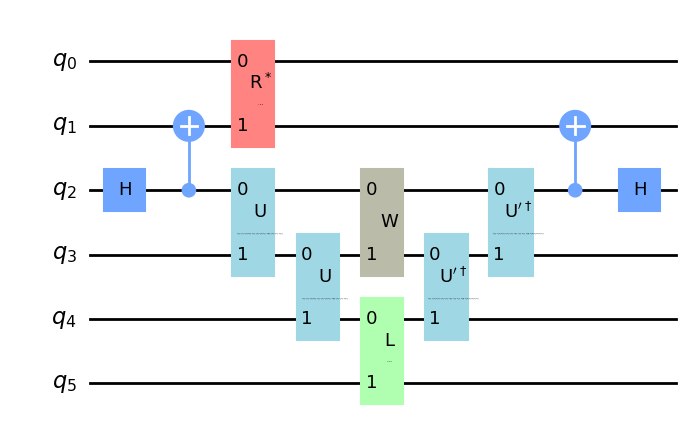

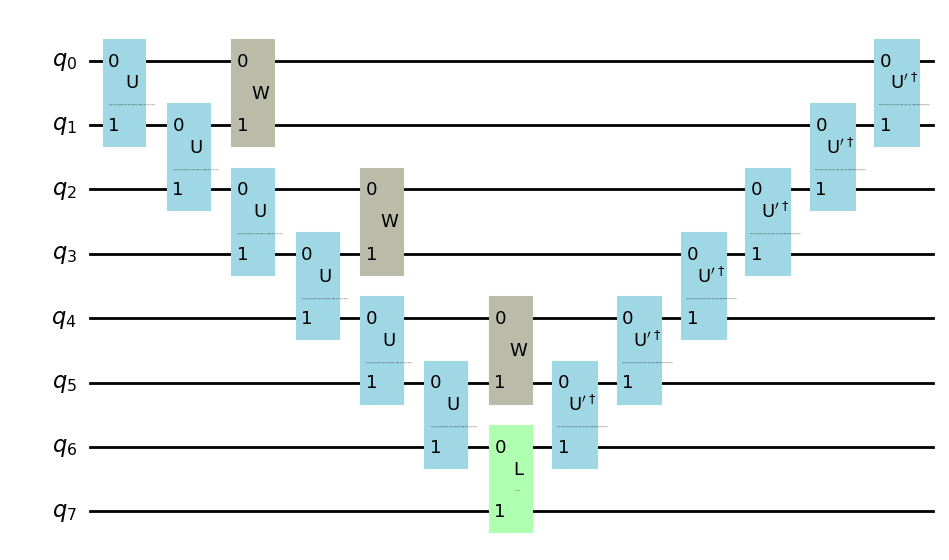

In [18]:
# testing the functions
circ, _ = create_trace_circ(invert_qubit_order(R_conj),
                            wrap_with_transfer_matrix_circ(L, mps, braMPS, W), 1)
display(circ.draw())
wrap_with_transfer_matrix_n_times(L, mps, braMPS, W,3).draw()

# define cost functions for L (and R)

#parameter you can choose here by executing one of the following two cells wether L_min_approx=False or True.

In [19]:
#parameter
overlap_eig_pow = 1 # schould probably have its own vairable here. but I always used the same power for these cost functions for L and the overlap functions i.e. local scalar product.

In [20]:
# tensor network cost functions:
# with exact minimization function.
L_min_approx = False

def get_cost_function(env_type, oldMPS, newMPS):
    #TODO make W a parameter
    E_UU = get_transfer_matrix(oldMPS, newMPS, W)
    E_UU = matrix_power(E_UU, overlap_eig_pow)
    if env_type == "R":
        def cost_function(params):
            r_list = r(R, params, precission=20)
            if type(r_list) == list:
                return [(np.abs(E_UU @ r_ - r_)**2).sum() / np.abs(r_**2).sum() for r_ in r_list] #(np.abs(E_UU @ r)**2).sum() + r.conj().T @ r - 2*np.abs(r.T.conj() @ E_UU @ r)  #
            r_ = r_list
            return (np.abs(E_UU @ r_ - r_)**2).sum() / np.abs(r_**2).sum()
        
    if env_type == "L":
        def cost_function(params):
            #print(":: possibly still wrong")
            l_list = l(L, params, precission=20)
            if type(l_list) == list:
                return [(np.abs(l_ @ E_UU - l_)**2).sum() / np.abs(l_**2).sum() for l_ in l_list] # (np.abs(l @ E_UU)**2).sum() + np.real(l.conj().T @ l) - 2*np.abs(l @ E_UU @ l.T.conj())  #
            l_ = l_list
            return (np.abs(l_ @ E_UU - l_)**2).sum() / np.abs(l_**2).sum()
        
    return cost_function

In [26]:
# tensor network cost functions:
# with approximated minimization function. (not shown in thesis.)
L_min_approx = True
def get_cost_function(env_type, oldMPS, newMPS):
    #TODO make W a parameter
    E_UU = get_transfer_matrix(oldMPS, newMPS, W)
    E_UU = matrix_power(E_UU, overlap_eig_pow)
    if env_type == "R":
        def cost_function(params):
            r_list = r(R, params, precission=20)
            if type(r_list) == list:
                return [((np.abs(E_UU @ r_ )**2).sum() - 2*np.abs(r_.T.conj() @ E_UU @ r_))/ np.abs(r_**2).sum() + 1 for r_ in r_list]
            r_ = r_list
            return ((np.abs(E_UU @ r_ )**2).sum() - 2*np.abs(r_.T.conj() @ E_UU @ r_))/ np.abs(r_**2).sum() + 1
        
    if env_type == "L":
        def cost_function(params):
            #print(":: possibly still wrong")
            l_list = l(L, params, precission=20)
            if type(l_list) == list:
                return [((np.abs(l_ @ E_UU)**2).sum() -2*np.abs(l_ @ E_UU @ l_.conj())) / np.abs(l_**2).sum() +1 for l_ in l_list]
            l_ = l_list
            return ((np.abs(l_ @ E_UU)**2).sum() -2*np.abs(l_ @ E_UU @ l_.conj())) / np.abs(l_**2).sum() +1
        
    return cost_function

In [27]:
# set initial parameters via rotosolve (even if it is not exactly sinusoidal due to normalization. A rough estimation suffices.)

R_param_n = get_params(R)
np.random.seed(1)
R_init_params = np.random.random(len(R_param_n))
cost_func = get_cost_function("R", mps, mps)
R_init_params = double_rotosolve(cost_func, dict(zip(R_param_n, R_init_params)), quiet=False)

L_param_n = get_params(L)
np.random.seed(1)
L_init_params = np.random.random(len(L_param_n))
cost_func = get_cost_function("L", mps, mps)
L_init_params = double_rotosolve(cost_func, dict(zip(L_param_n, L_init_params)), quiet=True)

current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.7203244934421581, Parameter($r_3$): 0.00011437481734488664}
sinusoidal args: (0.18763088709257608, -1.5707963267948966, 0.0731490617604757, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.547133008320708]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.7203244934421581, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.1707263673556813, -1.5707963267948966, 0.16589032917565205, -1.5707963267948966)
new $r_3$: 0.0
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.18336877173035776, -1.8867819268948465, 1.1102230246251565e-16, -1.5707963267948966)
new $r_2$: 0.15799280004997396
current value: [0.48820078037932124]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


current params: {Parameter($r_1$): 0.417022004702574, Parameter($r_2$): 0.15799280004997396, Parameter($r_3$): 0.0}
sinusoidal args: (0.06739416422990112, -2.0246178141719846, 0.003511535123549336, 0.08891335524887924)
current value: [0.53243577281459]


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.53243577281459], previous was [0.48820078037932124]. The old $r_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
reached max iter: 25.
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packa

# define overlap (local scalar product)

#parameter you can choose here by executing one of the following cells that define overlap, which overlap_method to use ("classical" "optimizing_l_tn",...)

note that these overlaps won't always yield the same values due to different approximations etc. However near the maximum the values should be similarly maximal.

## classicaly overlap

### testing the eig function of scipy.

In [50]:
from numpy.linalg import matrix_power
from scipy.linalg import eig

In [51]:
transfer_matrix = get_transfer_matrix(mps, braMPS, W)
transfer_pow_20 = matrix_power(transfer_matrix, 5)

In [52]:
T=np.array([[1,1],[0,1]])

In [53]:
T=transfer_matrix

In [54]:
#T = transfer_matrix
w, vl, vr = eig(T, left=True)
[ np.allclose(np.dot(vl[:,i].T.conj(), T), w[i]*vl[:,i].T.conj()) for i in range(len(w)) ]

[True, True, True, True]

In [ ]:
vr

In [ ]:
transfer_matrix = get_transfer_matrix(mps, mps, W)
eval, levec, revec = eig(transfer_matrix, left=True)
eval, levec, revec

In [ ]:
transfer_matrix = get_transfer_matrix(mps, mps, W)
eval_, revec_, levec_ = eig(transfer_matrix.T, left=True)

# we see that the left evec conjugated and the right evac from the transposed (levec_) match well. Don't forget the conjugation
np.round(np.log10(np.abs(eval-eval_)),3), np.round(np.log10(np.abs(levec.conj()-levec_)),3), np.round(np.log(np.abs(revec.conj()-revec_)),3)

In [ ]:

levec_.T @ transfer_matrix - levec_.T * eval[:,None]

In [ ]:
transfer_matrix @ revec - revec * eval

In [ ]:
transfer_pow_20

In [ ]:
from scipy.linalg import eig
eval, evec = eig(transfer_pow_20)
np.round(np.log10(np.abs(eval)), 3)

### overlap def

In [30]:
from numpy.linalg import matrix_power
from scipy.linalg import eig, eigvals


# overlap where the l eigenvalues are calculated directly instead of variationally.
overlap_method = "classically"
def overlap(oldMPS, newMPS, W=W):
    # in reality it gets the largest eigenvalue of the transfer matrix.

    transfer_pow = matrix_power(get_transfer_matrix(oldMPS, newMPS, W), overlap_eig_pow)
    eval = eigvals(transfer_pow)
    #print(np.round(np.log10(np.abs(eval)), 3))
    #print(np.round(np.imag(eval[0]), 3))

    return np.max(np.abs(eval))**2

def overlap_with_r(oldMPS, newMPS, W=W):
    # this is more like the circuits in the paper but we see, that we still get the same results.

    transfer_pow = matrix_power(get_transfer_matrix(oldMPS, newMPS, W), overlap_eig_pow)
    eval, levec, revec = eig(transfer_pow, left=True)
    #print(np.round(np.log10(np.abs(eval)), 3))
    #print(np.round(np.imag(eval[0]), 3))

    return np.max(np.abs(np.diag(levec.T.conj() @ transfer_pow @ revec))/ np.abs(np.diag(levec.T.conj() @ revec)))**2
    
print(overlap(mps, mps), overlap_with_r(mps,mps))
overlap(mps, braMPS), overlap_with_r(mps, braMPS)

0.9997944372906571 0.9997944372906582


(0.9997945883861488, 0.9997945883861468)

## overlaps using tensor networks

In [47]:
overlap_method = "optimizing_l_tn"

from numpy.linalg import matrix_power
debugging = True
# overlap without the need for R. (if we assume that L actually is a good approximation
# of the eigenvector this should be the same but faster.
def overlap(oldMPS, newMPS, W=W):
    # in reality it gets the largest eigenvalue of the transfer matrix.
    # get mixed environment:
    # L:
    global L_init_params
    cost_func = get_cost_function("L", oldMPS, newMPS)
    L_param_values = minimize(cost_func, L_init_params, 0, .1, context="optimizing L", is_noisy=False) #double_rotosolve(cost_func, dict(zip(L_params, L_init_params)), quiet=False)
    L_init_params = L_param_values

    l_ = l(L, L_param_values)
    transfer_mat = get_transfer_matrix(oldMPS, newMPS, W)
    transfer_mat_pow = matrix_power(transfer_mat, overlap_eig_pow)
    
    trace_with_transfer_mat    = np.abs( l_@transfer_mat_pow@l_.T.conj() )**2
    trace_without_transfer_mat = (np.abs(l_)**2).sum()**2
    if debugging: print(l_)
    if debugging: print(trace_with_transfer_mat, trace_without_transfer_mat)
    return trace_with_transfer_mat / trace_without_transfer_mat
    # maybe better use l_@transfer_mat @ l_.conj().T / ... because if it isn't the evec that has less influence.
    
print(overlap(mps, mps))
overlap(mps, braMPS)

[ 0.00922418-9.99943428e-01j  0.00529679+6.10400000e-17j
  0.00529679-6.15800000e-17j -0.00922418-9.99943428e-01j]
3.9989251620613175 4.000000000000002
0.9997312905153289
[ 0.00107379-9.99997906e-01j -0.0017421 +6.15200000e-17j
 -0.0017421 -6.13700000e-17j -0.00107379-9.99997906e-01j]
3.9990377021522736 4.0000000000000036


0.9997594255380675

## overlaps with circuit simulation instead of tensor networks

those overlaps where not used in the final thesis and can contain errors (with higher probability)
TODO: define overlap_method names for these methods.

In [95]:
def create_temp_mps_copy(mps):
    print("creating new mps object in overlap because both mps given use the same parameter names. Assuming U gate is a TwoLocal. etc.", file=sys.stderr)
    tmpMPS = iMPS(create_V_gate("V_temp", 1), create_U_gate("U_temp", 1,1,reps=len(mps.U_param_n)//4), list(mps.U_params.values()))
    return tmpMPS

In [ ]:
debugging = True
def overlap(oldMPS, newMPS):
    # in reality it gets the largest eigenvalue of the transfer matrix.
    global L_init_params, R_init_params

    if oldMPS.U_param_n == newMPS.U_param_n:
        newMPS = create_temp_mps_copy(newMPS)
    
    # get mixed environments:
    # R:
    cost_func = get_cost_function("R", oldMPS, newMPS)
    R_param_values = minimize(cost_func, R_init_params, 0, 1e2, context="optimizing R", is_noisy=False) #double_rotosolve(cost_func, dict(zip(R_params, R_init_params)), quiet=True)
    R_init_params = R_param_values
    # L:
    cost_func = get_cost_function("L", oldMPS, newMPS)
    L_param_values = minimize(cost_func, L_init_params, 0, 1e2, context="optimizing L", is_noisy=False) #double_rotosolve(cost_func, dict(zip(L_params, L_init_params)), quiet=False)
    L_init_params = L_param_values

    params=join_params(L_param_values, R_param_values, oldMPS.U_params, newMPS.U_params)
    
    trace_with_transfer_mat = estimate_trace(invert_qubit_order(R),
                                             wrap_with_transfer_matrix_circ(L, oldMPS, newMPS, W),
                                             oldMPS.bond_dim,
                                             params)
    
    trace_without_transfer_mat = estimate_trace(invert_qubit_order(R),
                                                   L,
                                                   oldMPS.bond_dim,
                                                   params)
    if debugging: print(trace_with_transfer_mat, trace_without_transfer_mat)
    return trace_with_transfer_mat / trace_without_transfer_mat
overlap(mps, mps)

creating new mps object in overlap because both mps given use the same parameter names. Assuming U gate is a TwoLocal.


using optimizer method BFGS


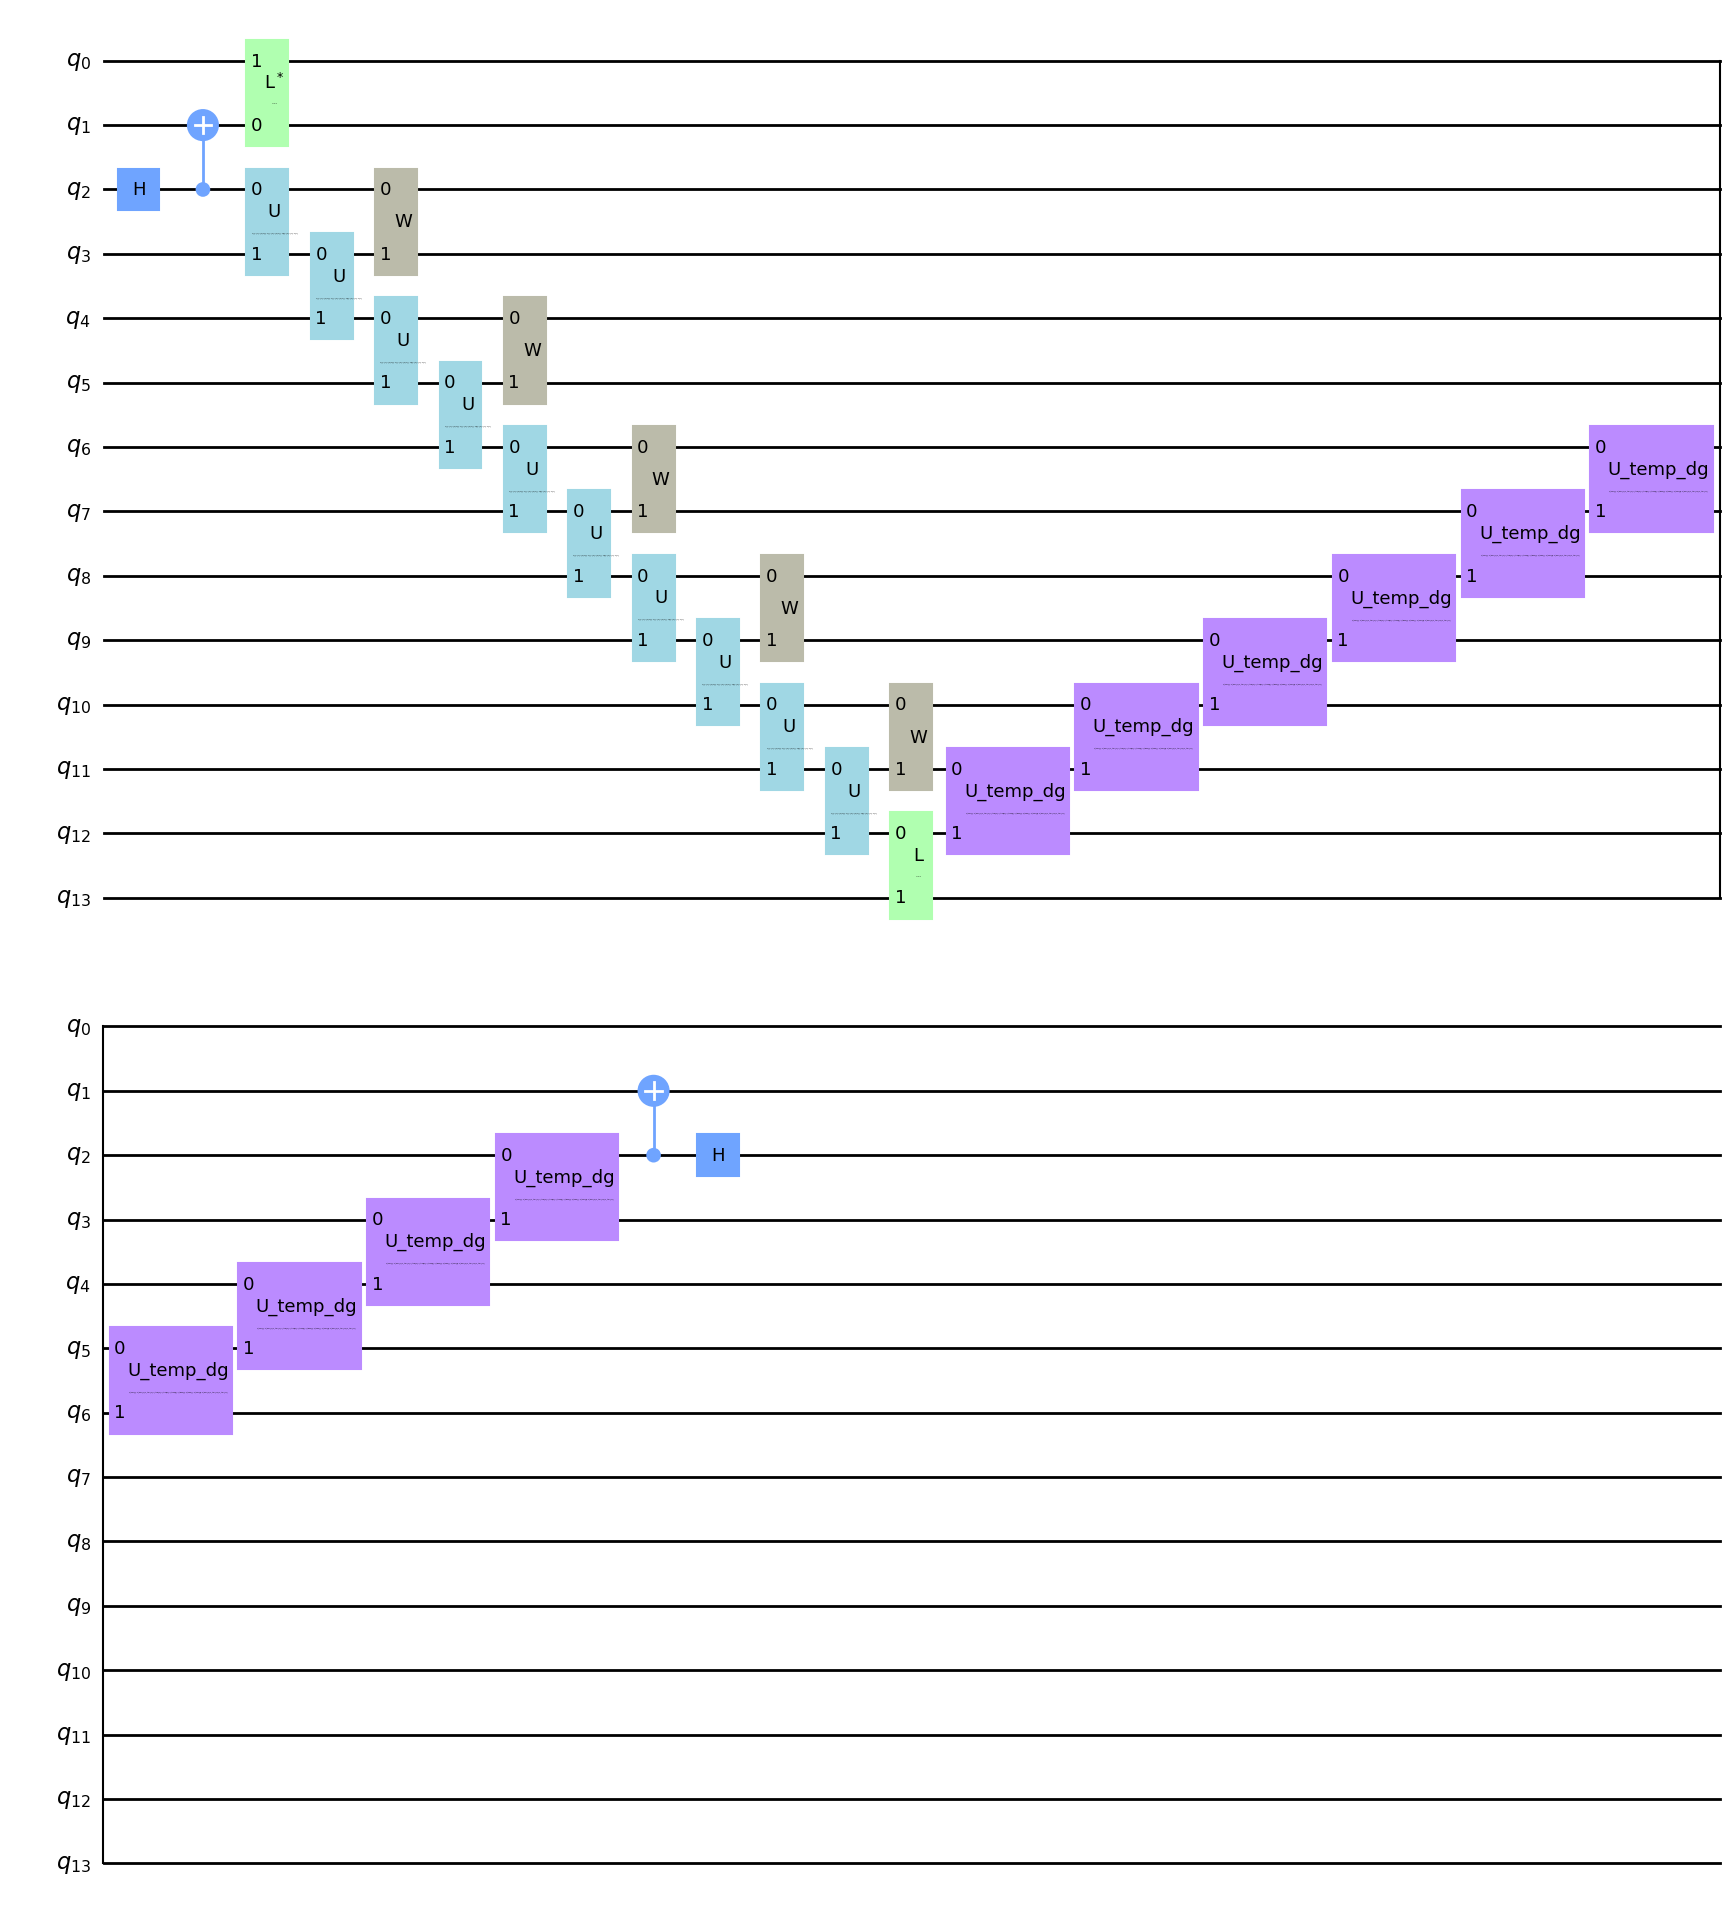

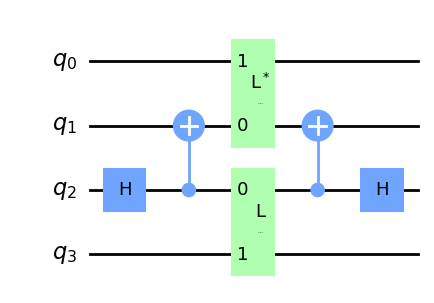

3.9728116467084185 3.9870006669929574
0.9964411793551967
using optimizer method BFGS


========warning: desired_minimum: 0 not reached: end value is 0.9336011361008474, method used: BFGS. context: optimizing L


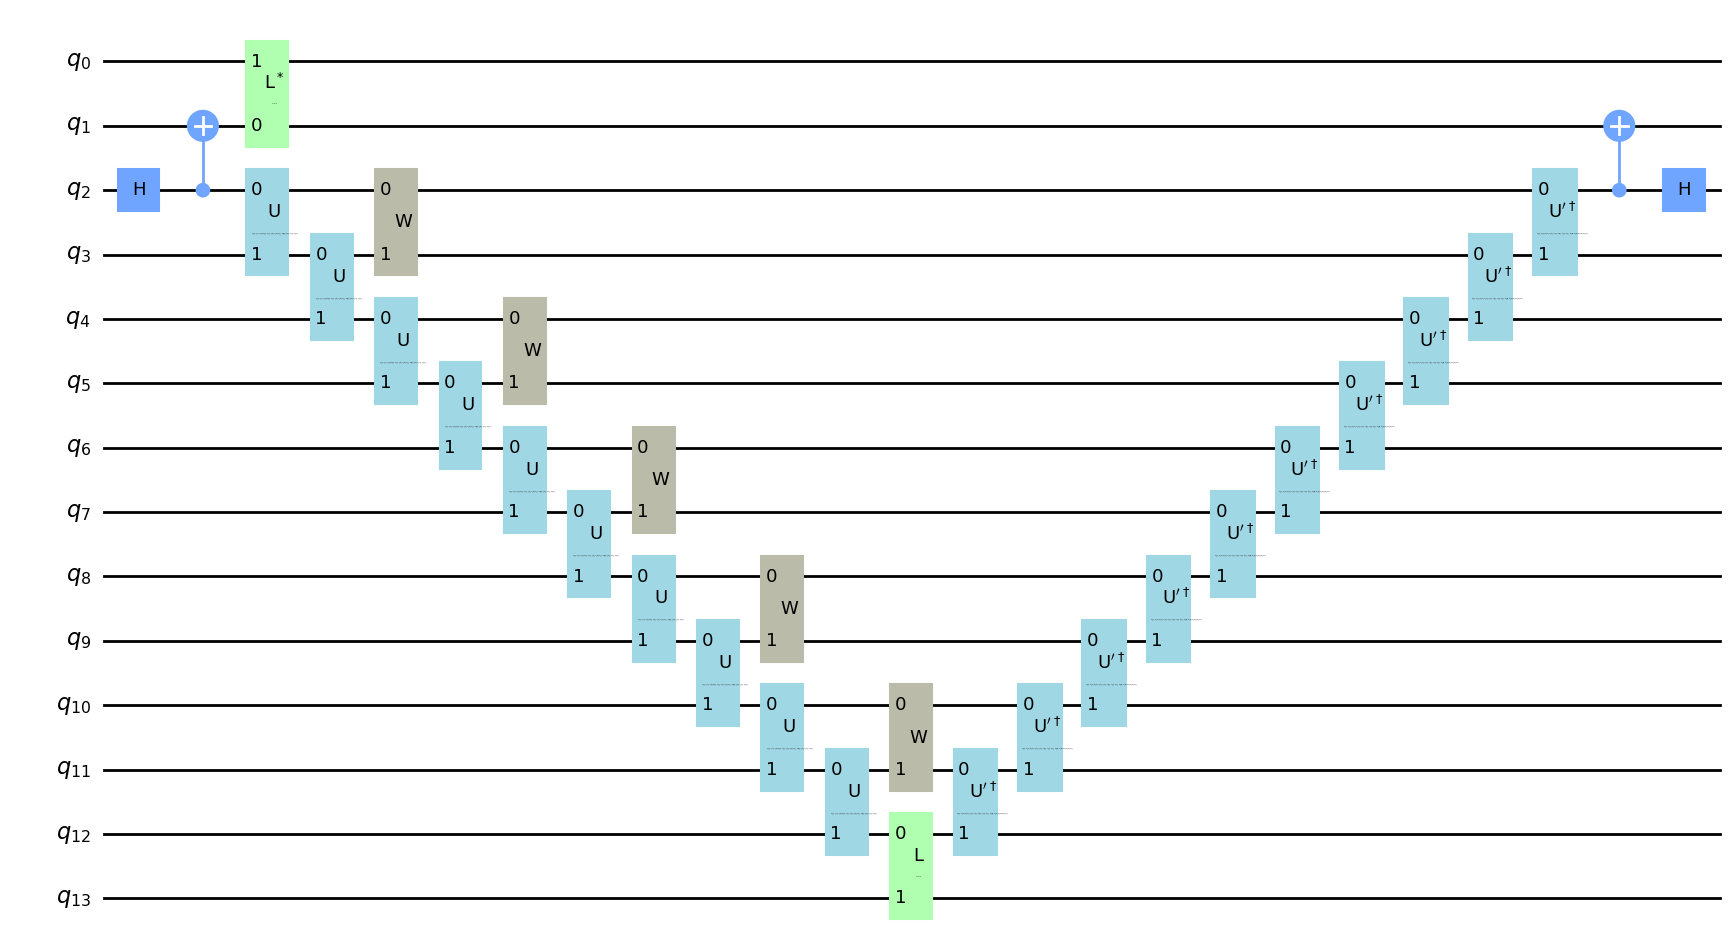

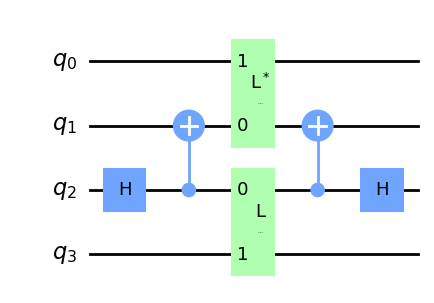

0.011125079018314336 1.2047118307213174


0.009234639134948338

In [98]:
debugging = True
# overlap without the need for R. (if we assume that L actually is a good approximation
# of the eigenvector this should be the same but faster.
def overlap(oldMPS, newMPS):
    # in reality it gets the largest eigenvalue of the transfer matrix.
    # get mixed environment:
    # L:
    global L_init_params

    if oldMPS.U_param_n == newMPS.U_param_n:
        newMPS = create_temp_mps_copy(newMPS)

    cost_func = get_cost_function("L", oldMPS, newMPS)
    L_param_values = minimize(cost_func, L_init_params, 0, .1, context="optimizing L", is_noisy=False) #double_rotosolve(cost_func, dict(zip(L_params, L_init_params)), quiet=False)
    L_init_params = L_param_values

    params=join_params(L_param_values, oldMPS.U_params, newMPS.U_params)

    wrapped_L = wrap_with_transfer_matrix_n_times(L, oldMPS, newMPS, W,5)
    trace_with_transfer_mat = estimate_trace(L_conj,
                                             wrapped_L,
                                             oldMPS.bond_dim,
                                             params)
    
    trace_without_transfer_mat = estimate_trace(L_conj,
                                                   L,
                                                   oldMPS.bond_dim,
                                                   params)
    if debugging: print(trace_with_transfer_mat, trace_without_transfer_mat)
    return trace_with_transfer_mat / trace_without_transfer_mat
    #return ( (np.abs(l_@transfer_mat_pow_5@l_.T.conj())) / (np.abs(l_)**2).sum() )**2
    # maybe better use l_@transfer_mat @ l_.conj().T / ... because if it isn't the evec that has less influence.
    
print(overlap(mps, mps))
overlap(mps, braMPS)

## testing the overlap

In [48]:
debugging = False
N=11
index1 = 6
index2 = 5

x_range = y_range = np.linspace(-1, 1, N)
overlaps = np.empty((N,N))

old_U_params = list(mps.U_params.values())
new_U_params = list(old_U_params)

for i in tqdm(range(N)):
    new_U_params[index1] = old_U_params[index1] + y_range[i]
    for j in range(N):
        new_U_params[index2] = old_U_params[index2] + y_range[j]
        braMPS.set_U_params(new_U_params)
        overlaps[i,j] = overlap(mps, braMPS)
        

  0%|                                                                                                                                                                                                                                                                                                | 0/11 [00:00<?, ?it/s]========warning: desired_minimum: 0 not reached: end value is 0.265675902133097, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.19602445260229162, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13922803228781008, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1375227117302985, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.19571701035230724, method used: BFGS. context: optimizing L
  9%|█████████████████████████▍                                    

0.15133699123969274 0.9997944372906591


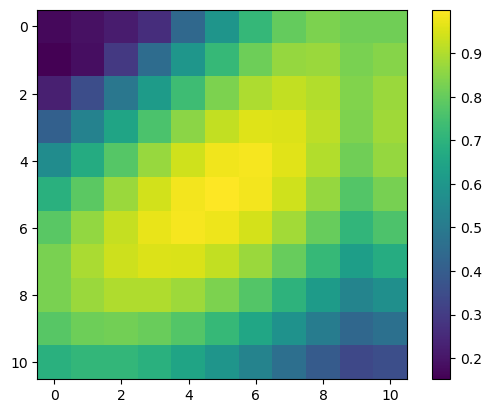

In [35]:
print(overlaps.min(), overlaps.max())
im = plt.imshow(overlaps)
plt.colorbar(im)

In [42]:
overlap(mps, mps)

0.9997944372906571

In [36]:
import scipy
U_old = list(mps.U_params.values())
def one_minus_overlap(new_U_params):
    braMPS.set_U_params(new_U_params)
    ret = 1 - overlap(mps, braMPS)
    return ret
U_opt_results = scipy.optimize.minimize(one_minus_overlap, U_old, method="CG", tol=one_minus_overlap(U_old)/100)
if U_opt_results.success:
    U_new = U_opt_results.x
    print(U_new)
else:
    print(U_opt_results)

[ 0.07803696 -1.22535072  0.98142255  0.96028394 -0.79499138 -0.70038141
 -0.29846313 -1.21040681  0.00833456  1.50655216  0.01016534  2.1959326 ]


In [37]:
np.array(list(mps.U_params.values())) - U_new

array([-1.77308545e-02,  8.24334463e-06, -5.09055545e-03, -1.48167972e-03,
        8.53200178e-04,  2.92983678e-03, -1.37668801e-04, -4.76802437e-04,
        2.89266858e-04,  3.05155374e-02,  4.13750927e-06, -4.24171939e-03])

In [38]:
one_minus_overlap(U_new)

8.879587810239897e-05

In [40]:
U_opt_results

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 8.879587810239897e-05
       x: [ 7.804e-02 -1.225e+00  9.814e-01  9.603e-01 -7.950e-01
           -7.004e-01 -2.985e-01 -1.210e+00  8.335e-03  1.507e+00
            1.017e-02  2.196e+00]
     nit: 41
     jac: [-1.118e-06 -2.831e-07 -1.296e-06 -9.835e-07 -4.470e-08
           -5.662e-07 -6.557e-07 -1.132e-06 -7.600e-07 -6.706e-07
           -4.470e-07 -1.207e-06]
    nfev: 780
    njev: 60

In [44]:
braMPS.set_U_params(U_opt_results.x)
U_mat1 = braMPS.U_mat
U_mat1- mps.U_mat

Operator([[-0.00347194+5.49748193e-03j,  0.0051233 +2.59358855e-03j,
           -0.01627944-5.09400743e-03j, -0.00228248+2.02246678e-03j],
          [-0.00349806-1.07127425e-03j,  0.01432338-1.06109276e-02j,
           -0.00342915-5.04783435e-04j,  0.00224844+2.00114791e-03j],
          [ 0.00314376+2.62860429e-03j,  0.00278808-8.99592384e-03j,
            0.00090969-1.03636986e-02j, -0.00090407-2.06901262e-03j],
          [-0.0006165 -9.64843550e-05j,  0.00415087+4.72734890e-03j,
           -0.00016629+9.70915864e-03j, -0.00729375+2.18399680e-03j]],
         input_dims=(2, 2), output_dims=(2, 2))

In [46]:
mps.measure_observable(create_obs_from_string("1")).result().values[0]

0.5008851929557568

# Time evolution

## get U params from files

In [ ]:
all_mps_list_for_comparison = []
names_list_for_comparison = []

In [ ]:
# load all_mps from earlier
input("are you sure? this will overwrite all_mps. ")
name="U_params_using__third_hamiltonian_with_quench__eigenvalue^5_overlap__classically_4,g=.1-2.5"
all_U_params = np.genfromtxt(f"results/{name}.csv", delimiter=",")
all_mps = [deepcopy(mps) for i in range(len(all_U_params))]
for i, mps_ in enumerate(all_mps):
    mps_.set_U_params(all_U_params[i])
all_mps_list_for_comparison.append(all_mps)
names_list_for_comparison.append(name)

In [82]:
all_mps_old = all_mps

## run new time evolution

In [23]:
#parameter
use_Nelder_Mead = False


In [ ]:
debugging = False
all_mps = [deepcopy(mps)]
for i in range(len(all_mps), int(10/delta_t) + 1):
    print("new iteration")
    oldMPS = all_mps[-1]
    def one_minus_overlap(new_U_params):
        braMPS.set_U_params(new_U_params)
        ret = 1 - overlap(oldMPS, braMPS)
        return ret

    init_U_params = list(oldMPS.U_params.values())
    initial_overlap = one_minus_overlap(init_U_params)
    print(f"staring iteration with {initial_overlap}")
    new_U_params = minimize(one_minus_overlap, init_U_params, desired_minimum=0, tol=initial_overlap/10, context=f"optimize overlap time step: {i}", is_noisy=use_Nelder_Mead)
    newMPS = deepcopy(oldMPS)
    newMPS.set_U_params(new_U_params)
    all_mps.append(newMPS)


new iteration
staring iteration with 1.7268888394927906e-05
new iteration
staring iteration with 1.7289790784635883e-05
new iteration
staring iteration with 1.7309853911906536e-05
new iteration
staring iteration with 1.7330706270524132e-05
new iteration
staring iteration with 1.7355753518799588e-05
new iteration
staring iteration with 1.735621286402811e-05
new iteration
staring iteration with 1.7375511188855164e-05
new iteration
staring iteration with 1.7399412153618066e-05
new iteration
staring iteration with 1.7409244897792497e-05
new iteration
staring iteration with 1.74268554201662e-05
new iteration
staring iteration with 1.7445251947245666e-05
new iteration
staring iteration with 1.7465782528924834e-05
new iteration
staring iteration with 1.748891666619734e-05
new iteration
staring iteration with 1.7504368510223856e-05
new iteration
staring iteration with 1.7519392451759153e-05
new iteration
staring iteration with 1.754222834282615e-05
new iteration
staring iteration with 1.755682

========warning: desired_minimum: 0 not reached: end value is 0.10004432569655809, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.5150004553654561e-05


========warning: desired_minimum: 0 not reached: end value is 0.1004161132973303, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.5109651494205067e-05


========warning: desired_minimum: 0 not reached: end value is 0.10059172558461282, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.5108707032474022e-05


========warning: desired_minimum: 0 not reached: end value is 0.10071583880925243, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.5062853150005218e-05


========warning: desired_minimum: 0 not reached: end value is 0.10083844893071411, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.5026971789566801e-05


========warning: desired_minimum: 0 not reached: end value is 0.10098621857191013, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.500978743151915e-05


========warning: desired_minimum: 0 not reached: end value is 0.10114411144254362, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.5033371895012415e-05


========warning: desired_minimum: 0 not reached: end value is 0.1012531252277957, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.5038272814127396e-05


========warning: desired_minimum: 0 not reached: end value is 0.1015411131616844, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.502801850605806e-05


========warning: desired_minimum: 0 not reached: end value is 0.10175089606118365, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.5020805712917529e-05


========warning: desired_minimum: 0 not reached: end value is 0.10192458833346695, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.5010456011821383e-05


========warning: desired_minimum: 0 not reached: end value is 0.10216270726785137, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.499598289134152e-05


========warning: desired_minimum: 0 not reached: end value is 0.10224366475159173, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4922685865448315e-05


========warning: desired_minimum: 0 not reached: end value is 0.10245131681398642, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4902228642643678e-05


========warning: desired_minimum: 0 not reached: end value is 0.10254238221898451, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4896474405334814e-05


========warning: desired_minimum: 0 not reached: end value is 0.10270597884266815, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4854883174875155e-05


========warning: desired_minimum: 0 not reached: end value is 0.10287083878785666, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4852241649543352e-05


========warning: desired_minimum: 0 not reached: end value is 0.10301643356400392, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4840108110036887e-05


========warning: desired_minimum: 0 not reached: end value is 0.10320001903697364, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4827559982721894e-05


========warning: desired_minimum: 0 not reached: end value is 0.10335251457887783, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4824576511474064e-05


========warning: desired_minimum: 0 not reached: end value is 0.10340076030578887, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4783039978594203e-05


========warning: desired_minimum: 0 not reached: end value is 0.10347162835139401, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4757441047508202e-05


========warning: desired_minimum: 0 not reached: end value is 0.10361883817226643, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.474291162573138e-05


========warning: desired_minimum: 0 not reached: end value is 0.10373428880719594, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4710884321700313e-05


========warning: desired_minimum: 0 not reached: end value is 0.10384111044757204, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4645473336516446e-05


========warning: desired_minimum: 0 not reached: end value is 0.1001931847702047, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1041178134335413, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4603990009298684e-05


========warning: desired_minimum: 0 not reached: end value is 0.10032569779680035, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10427064179956429, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4565783297060264e-05


========warning: desired_minimum: 0 not reached: end value is 0.10048425189863333, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10445508414392249, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4518019250453484e-05


========warning: desired_minimum: 0 not reached: end value is 0.1006093941833785, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10459813970176988, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4510543666079734e-05


========warning: desired_minimum: 0 not reached: end value is 0.10064520906955712, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10464149768445402, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4503182578784468e-05


========warning: desired_minimum: 0 not reached: end value is 0.10088557448869065, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1049322305630822, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4495243227941046e-05


========warning: desired_minimum: 0 not reached: end value is 0.10095352225115804, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10509908954404236, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4408885233296864e-05


========warning: desired_minimum: 0 not reached: end value is 0.10122061157369748, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10534010437486623, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4385497535185365e-05


========warning: desired_minimum: 0 not reached: end value is 0.10145549726928714, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10562132278119608, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.436599984094844e-05


========warning: desired_minimum: 0 not reached: end value is 0.10148698800928775, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10565676124022377, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4347068023279341e-05


========warning: desired_minimum: 0 not reached: end value is 0.10159091545959387, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10577856121763672, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4342810505940662e-05


========warning: desired_minimum: 0 not reached: end value is 0.10170526703665161, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1059200699636785, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4326954831500593e-05


========warning: desired_minimum: 0 not reached: end value is 0.10183091901769012, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10607299174862242, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4308852022693053e-05


========warning: desired_minimum: 0 not reached: end value is 0.1019893178790185, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10626248004475597, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4279033580755218e-05


========warning: desired_minimum: 0 not reached: end value is 0.10209851100346752, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10639056806651566, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4237948191775374e-05


========warning: desired_minimum: 0 not reached: end value is 0.10228235383303444, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10660841203312245, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.419248776723947e-05


========warning: desired_minimum: 0 not reached: end value is 0.1023371054831751, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10666776183993426, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4146432010031518e-05


========warning: desired_minimum: 0 not reached: end value is 0.1024609924222845, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1068093389552188, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4100040519826607e-05


========warning: desired_minimum: 0 not reached: end value is 0.10258405355472752, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1069525799183614, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.404195362664229e-05


========warning: desired_minimum: 0 not reached: end value is 0.10271358947741037, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1071011322619489, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.4000139288983249e-05


========warning: desired_minimum: 0 not reached: end value is 0.10277467292413608, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10717107689294843, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.394186269609854e-05


========warning: desired_minimum: 0 not reached: end value is 0.10283580197311384, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10723805449710098, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.3902109496477522e-05


========warning: desired_minimum: 0 not reached: end value is 0.1029372689133701, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10735468947385962, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.3865827741543768e-05


========warning: desired_minimum: 0 not reached: end value is 0.10293045344156093, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10734189583194391, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.3815652391224731e-05


========warning: desired_minimum: 0 not reached: end value is 0.10302954172489269, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10745681468996444, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.3770441150806612e-05


========warning: desired_minimum: 0 not reached: end value is 0.10318796066252622, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1076452073600218, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.3731225230184663e-05


========warning: desired_minimum: 0 not reached: end value is 0.10336720834352396, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10786147246081569, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.3695976780581098e-05


========warning: desired_minimum: 0 not reached: end value is 0.10337930935215682, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10787257945240684, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.3644805088364187e-05


========warning: desired_minimum: 0 not reached: end value is 0.10358881030475939, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1081210816498567, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.3610451176870875e-05


========warning: desired_minimum: 0 not reached: end value is 0.10382268906396003, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10840357296699478, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.3555378928997719e-05


========warning: desired_minimum: 0 not reached: end value is 0.10396620049637363, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10857505876540272, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.3512229334433634e-05


========warning: desired_minimum: 0 not reached: end value is 0.10417886184438652, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10883176748305537, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.3464745909019804e-05


========warning: desired_minimum: 0 not reached: end value is 0.10426997113434443, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10893837676956361, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.3434576207616011e-05


========warning: desired_minimum: 0 not reached: end value is 0.10432519342378238, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10900277702649007, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.3394603739946831e-05


========warning: desired_minimum: 0 not reached: end value is 0.10447564648325865, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10917904893911246, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.3353395377668775e-05


========warning: desired_minimum: 0 not reached: end value is 0.10462785831679305, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10936043332030994, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.3294445984746162e-05


========warning: desired_minimum: 0 not reached: end value is 0.1048638202377629, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10964220817346453, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.3251809953929161e-05


========warning: desired_minimum: 0 not reached: end value is 0.10501074011260432, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10982079066621453, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.320678711780321e-05


========warning: desired_minimum: 0 not reached: end value is 0.10510975731710817, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10993733136032671, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.3166815948095767e-05


========warning: desired_minimum: 0 not reached: end value is 0.10530986844156116, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11017418287638239, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.3124687000098945e-05


========warning: desired_minimum: 0 not reached: end value is 0.10551052282519734, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11041654727427917, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.3076285598323523e-05


========warning: desired_minimum: 0 not reached: end value is 0.10562520024919336, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11055274160175695, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.3039200637221526e-05


========warning: desired_minimum: 0 not reached: end value is 0.10573895611561904, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11068760057812135, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.2982678389783509e-05


========warning: desired_minimum: 0 not reached: end value is 0.10590248724159684, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11088069855891354, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.294326810830082e-05


========warning: desired_minimum: 0 not reached: end value is 0.10604540988851305, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11105018663585006, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.2900075802013689e-05


========warning: desired_minimum: 0 not reached: end value is 0.10618639010764701, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11121794422418642, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.2858999795195558e-05


========warning: desired_minimum: 0 not reached: end value is 0.10623704101967128, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11127622556774865, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.2830520598305917e-05


========warning: desired_minimum: 0 not reached: end value is 0.10628053198600704, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11132547212003564, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.2801485457236694e-05


========warning: desired_minimum: 0 not reached: end value is 0.10634032913936342, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.111395299593128, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.2756316825512926e-05


========warning: desired_minimum: 0 not reached: end value is 0.10631386294108959, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11143335921063212, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.2630429746196548e-05


========warning: desired_minimum: 0 not reached: end value is 0.10654191564738334, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1116275193202526, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.2575624184774092e-05


========warning: desired_minimum: 0 not reached: end value is 0.10659482385877757, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11168504065454632, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.254758749447138e-05


========warning: desired_minimum: 0 not reached: end value is 0.10675936596271572, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11188522100071215, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.2495859953998156e-05


========warning: desired_minimum: 0 not reached: end value is 0.10691561098002515, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.112073321848344, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.245863854970608e-05


========warning: desired_minimum: 0 not reached: end value is 0.10710748256413236, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11230488427243368, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.2410459794720552e-05


========warning: desired_minimum: 0 not reached: end value is 0.1072963768168331, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1125297010972407, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.2367203828134166e-05


========warning: desired_minimum: 0 not reached: end value is 0.10752121309084803, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11279987606310966, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.2315233513748858e-05


========warning: desired_minimum: 0 not reached: end value is 0.10764129279203145, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11294050320203844, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.2258661890696132e-05


========warning: desired_minimum: 0 not reached: end value is 0.10788161141143308, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11322670621994473, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.2209674451479913e-05


========warning: desired_minimum: 0 not reached: end value is 0.10795730698815133, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1133161339580128, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.2162511799806985e-05


========warning: desired_minimum: 0 not reached: end value is 0.10804001000258816, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11341193549353203, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.2121165008815993e-05


========warning: desired_minimum: 0 not reached: end value is 0.10814286810537593, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11353513824980087, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.2086416065426597e-05


========warning: desired_minimum: 0 not reached: end value is 0.10827392902197505, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11369317441047717, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.2028344325121232e-05


========warning: desired_minimum: 0 not reached: end value is 0.10842135996773253, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11386927218326204, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.1978608898566279e-05


========warning: desired_minimum: 0 not reached: end value is 0.10850794403554895, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11397463016078907, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.1930083360311983e-05


========warning: desired_minimum: 0 not reached: end value is 0.10861019958447563, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.114095522156426, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.1883008497970415e-05


========warning: desired_minimum: 0 not reached: end value is 0.10878217635367075, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11429846938296034, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.1834756244777367e-05


========warning: desired_minimum: 0 not reached: end value is 0.10902122200170364, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11458742953337105, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.178974126136989e-05


========warning: desired_minimum: 0 not reached: end value is 0.10918702507098696, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1147880983060925, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.1749880019285008e-05


========warning: desired_minimum: 0 not reached: end value is 0.10929692934730995, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1149213714142673, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.1708000051235956e-05


========warning: desired_minimum: 0 not reached: end value is 0.10940251197177397, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11504944479047736, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.1666893500961173e-05


========warning: desired_minimum: 0 not reached: end value is 0.10954693493650529, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11522525874480624, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.1621122444571697e-05


========warning: desired_minimum: 0 not reached: end value is 0.10968454476973237, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1153904557733855, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.1563123444968681e-05


========warning: desired_minimum: 0 not reached: end value is 0.1098256235733154, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11555954151414317, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.1531783510987381e-05


========warning: desired_minimum: 0 not reached: end value is 0.11008619390310452, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11587963141079015, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.1482701429699205e-05


========warning: desired_minimum: 0 not reached: end value is 0.11027011014060392, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11610105142348258, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.1435274634097325e-05


========warning: desired_minimum: 0 not reached: end value is 0.11041159488816545, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11627352073795659, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.1392843863977653e-05


========warning: desired_minimum: 0 not reached: end value is 0.11054381234074173, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11643422456158051, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.1350302926871336e-05


========warning: desired_minimum: 0 not reached: end value is 0.11069072402264175, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11661177907128212, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.129867348959035e-05


========warning: desired_minimum: 0 not reached: end value is 0.11074523685427484, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11667551942631936, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.1248808095554175e-05


========warning: desired_minimum: 0 not reached: end value is 0.11081770033384354, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11676293234659936, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.1195513552109126e-05


========warning: desired_minimum: 0 not reached: end value is 0.11094692484875034, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11691819197313424, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.1137792073401265e-05


========warning: desired_minimum: 0 not reached: end value is 0.11102269062351486, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1170081239744265, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.1090946389291645e-05


========warning: desired_minimum: 0 not reached: end value is 0.11124013304928981, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11727274172374044, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.1035348822074909e-05


========warning: desired_minimum: 0 not reached: end value is 0.11131979496966991, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1173677199374727, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0990433461532945e-05


========warning: desired_minimum: 0 not reached: end value is 0.111350241147813, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11740393455427658, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0945272471696299e-05


========warning: desired_minimum: 0 not reached: end value is 0.11140213506998038, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11746778825409669, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0901700346788168e-05


========warning: desired_minimum: 0 not reached: end value is 0.11148507821558587, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11757042240798395, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0861730466049657e-05


========warning: desired_minimum: 0 not reached: end value is 0.11154080711216253, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11763821766006696, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0821336719923913e-05


========warning: desired_minimum: 0 not reached: end value is 0.11157698743680994, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11768332051443085, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0787534787226605e-05


========warning: desired_minimum: 0 not reached: end value is 0.11172526494932167, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11786678694328502, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0759858184106186e-05


========warning: desired_minimum: 0 not reached: end value is 0.11184106712786258, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11801210318574727, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0731381639317306e-05


========warning: desired_minimum: 0 not reached: end value is 0.1118964763012315, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11808070359395509, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0696464298853847e-05


========warning: desired_minimum: 0 not reached: end value is 0.11195906898801289, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11815817335064994, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0641396889887744e-05


========warning: desired_minimum: 0 not reached: end value is 0.11199543278389064, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11820077209301928, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0598132174632902e-05


========warning: desired_minimum: 0 not reached: end value is 0.1120035678873863, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11821139637650137, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0826077252445998e-06, method used: Nelder-Mead. context: optimize overlap time step: 636


new iteration
staring iteration with 1.0556867875877174e-05


========warning: desired_minimum: 0 not reached: end value is 0.11216959189956065, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11841438809928687, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.078624786932103e-06, method used: Nelder-Mead. context: optimize overlap time step: 637


new iteration
staring iteration with 1.052315372063184e-05


========warning: desired_minimum: 0 not reached: end value is 0.1122234963170074, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.118540389214811, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.039625707643932e-05


========warning: desired_minimum: 0 not reached: end value is 0.11234539502051191, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11863031610454208, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0346067486399768e-05


========warning: desired_minimum: 0 not reached: end value is 0.11248251656452402, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11879832628959217, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0299431076554733e-05


========warning: desired_minimum: 0 not reached: end value is 0.1125530965820512, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11888579256773948, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0251394114035861e-05


========warning: desired_minimum: 0 not reached: end value is 0.11266310647438892, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11902095434040647, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0210023259182854e-05


========warning: desired_minimum: 0 not reached: end value is 0.11277672154079806, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11916243829347642, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0151425919313617e-05


========warning: desired_minimum: 0 not reached: end value is 0.11291726984009093, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11933536250673284, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0100782605215741e-05


========warning: desired_minimum: 0 not reached: end value is 0.1129739826776256, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11940489060373241, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0060603048200889e-05


========warning: desired_minimum: 0 not reached: end value is 0.11304896463100547, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1194964044124071, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0015486161862874e-05


========warning: desired_minimum: 0 not reached: end value is 0.11313382899595295, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11960048960887137, method used: BFGS. context: optimizing L


new iteration
staring iteration with 9.972288990023337e-06


========warning: desired_minimum: 0 not reached: end value is 0.1132780349002435, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1197792966344672, method used: BFGS. context: optimizing L


new iteration
staring iteration with 9.93627328005342e-06


========warning: desired_minimum: 0 not reached: end value is 0.11331455799967968, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11982444197460895, method used: BFGS. context: optimizing L


new iteration
staring iteration with 9.880151554675365e-06


========warning: desired_minimum: 0 not reached: end value is 0.11334449182494812, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11986205138057156, method used: BFGS. context: optimizing L


new iteration
staring iteration with 9.827627111436144e-06


========warning: desired_minimum: 0 not reached: end value is 0.11344897461719815, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11999203564801503, method used: BFGS. context: optimizing L


new iteration
staring iteration with 9.776970500530169e-06


========warning: desired_minimum: 0 not reached: end value is 0.11347339357464918, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12002318157367428, method used: BFGS. context: optimizing L


new iteration
staring iteration with 9.724467532334913e-06


========warning: desired_minimum: 0 not reached: end value is 0.11355230655940086, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12012064556276722, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0086461899039278e-06, method used: Nelder-Mead. context: optimize overlap time step: 653


new iteration
staring iteration with 9.682460026305684e-06


========warning: desired_minimum: 0 not reached: end value is 0.11369968086007688, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12030274295145846, method used: BFGS. context: optimizing L


new iteration
staring iteration with 9.627494372166367e-06


========warning: desired_minimum: 0 not reached: end value is 0.1137934674070084, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12041566367530131, method used: BFGS. context: optimizing L


new iteration
staring iteration with 9.573919888206106e-06


========warning: desired_minimum: 0 not reached: end value is 0.11388995528148772, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12053399057385346, method used: BFGS. context: optimizing L


new iteration
staring iteration with 9.52019755418032e-06


========warning: desired_minimum: 0 not reached: end value is 0.11401767362097233, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12068908000174561, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.521035960746715e-07, method used: Nelder-Mead. context: optimize overlap time step: 657


new iteration
staring iteration with 9.469409796958317e-06


========warning: desired_minimum: 0 not reached: end value is 0.11409312820236202, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12078161599134311, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.500112647664594e-07, method used: Nelder-Mead. context: optimize overlap time step: 658


new iteration
staring iteration with 9.421644345919411e-06


========warning: desired_minimum: 0 not reached: end value is 0.11423276678205911, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1209552540484491, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.576068505934288e-07, method used: Nelder-Mead. context: optimize overlap time step: 659


new iteration
staring iteration with 9.367331806786616e-06


========warning: desired_minimum: 0 not reached: end value is 0.11427009297713836, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12099880714943737, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.663159653561237e-07, method used: Nelder-Mead. context: optimize overlap time step: 660


new iteration
staring iteration with 9.320127984935311e-06


========warning: desired_minimum: 0 not reached: end value is 0.11425757962597619, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1209862154797297, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.716495668055103e-07, method used: Nelder-Mead. context: optimize overlap time step: 661


new iteration
staring iteration with 9.272652820246918e-06


========warning: desired_minimum: 0 not reached: end value is 0.11422876535946294, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12094975369947544, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.586783054071901e-07, method used: Nelder-Mead. context: optimize overlap time step: 662


new iteration
staring iteration with 9.238565911284802e-06


========warning: desired_minimum: 0 not reached: end value is 0.11427363652876603, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12100562117196129, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.571230967786448e-07, method used: Nelder-Mead. context: optimize overlap time step: 663


new iteration
staring iteration with 9.198530069309818e-06


========warning: desired_minimum: 0 not reached: end value is 0.11436900956058614, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12112440907617165, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.748139628840136e-07, method used: Nelder-Mead. context: optimize overlap time step: 664


new iteration
staring iteration with 9.14356417347495e-06


========warning: desired_minimum: 0 not reached: end value is 0.11436808396424425, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12112669783164233, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.648796887029576e-07, method used: Nelder-Mead. context: optimize overlap time step: 665


new iteration
staring iteration with 9.094080495875012e-06


========warning: desired_minimum: 0 not reached: end value is 0.11448530143329319, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12127508667446726, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.6370284241587e-07, method used: Nelder-Mead. context: optimize overlap time step: 666


new iteration
staring iteration with 9.04029482740043e-06


========warning: desired_minimum: 0 not reached: end value is 0.11459890777971779, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12141663185977428, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.65631842375636e-07, method used: Nelder-Mead. context: optimize overlap time step: 667


new iteration
staring iteration with 8.990235692118986e-06


========warning: desired_minimum: 0 not reached: end value is 0.11469708217422457, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12153825853415295, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.69124193006543e-07, method used: Nelder-Mead. context: optimize overlap time step: 668


new iteration
staring iteration with 8.94329181178044e-06


========warning: desired_minimum: 0 not reached: end value is 0.11481729895236523, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12169208727842186, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.71316816755774e-07, method used: Nelder-Mead. context: optimize overlap time step: 669


new iteration
staring iteration with 8.88643957885904e-06


========warning: desired_minimum: 0 not reached: end value is 0.11489294896047265, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12178655794233799, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.90966511404956e-07, method used: Nelder-Mead. context: optimize overlap time step: 670


new iteration
staring iteration with 8.836672278689228e-06


========warning: desired_minimum: 0 not reached: end value is 0.11498322292224183, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12190040889268029, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.750880153314156e-07, method used: Nelder-Mead. context: optimize overlap time step: 671


new iteration
staring iteration with 8.801069867003797e-06


========warning: desired_minimum: 0 not reached: end value is 0.11508117217349076, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12202336221314915, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.795599191786408e-07, method used: Nelder-Mead. context: optimize overlap time step: 672


new iteration
staring iteration with 8.743107866249211e-06


========warning: desired_minimum: 0 not reached: end value is 0.1151676807327653, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12212977641445343, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.853757784172856e-07, method used: Nelder-Mead. context: optimize overlap time step: 673


new iteration
staring iteration with 8.692357538198081e-06


========warning: desired_minimum: 0 not reached: end value is 0.11523548510261424, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12221567599600651, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.9641049167154e-07, method used: Nelder-Mead. context: optimize overlap time step: 674


new iteration
staring iteration with 8.640719620700565e-06


========warning: desired_minimum: 0 not reached: end value is 0.11525107548466548, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12223663736152046, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.979035887619503e-07, method used: Nelder-Mead. context: optimize overlap time step: 675


new iteration
staring iteration with 8.591842627581059e-06


========warning: desired_minimum: 0 not reached: end value is 0.11531242976276727, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1223149106974067, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0065833533356994e-06, method used: Nelder-Mead. context: optimize overlap time step: 676


new iteration
staring iteration with 8.539072394286862e-06


========warning: desired_minimum: 0 not reached: end value is 0.11535713258016794, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12237272178310488, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0429830745728452e-06, method used: Nelder-Mead. context: optimize overlap time step: 677


new iteration
staring iteration with 8.494620235222072e-06


========warning: desired_minimum: 0 not reached: end value is 0.115443942055199, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12248550767001874, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0203769634786752e-06, method used: Nelder-Mead. context: optimize overlap time step: 678


new iteration
staring iteration with 8.465674981694704e-06


========warning: desired_minimum: 0 not reached: end value is 0.11559857185995807, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12268012851173908, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0531389080803422e-06, method used: Nelder-Mead. context: optimize overlap time step: 679


new iteration
staring iteration with 8.426721889165378e-06


========warning: desired_minimum: 0 not reached: end value is 0.11571908942505435, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12283172652273638, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0410773948477114e-06, method used: Nelder-Mead. context: optimize overlap time step: 680


new iteration
staring iteration with 8.397793081260652e-06


========warning: desired_minimum: 0 not reached: end value is 0.11580734203806588, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1229438602339756, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1272451894139834e-06, method used: Nelder-Mead. context: optimize overlap time step: 681


new iteration
staring iteration with 8.371742895918466e-06


========warning: desired_minimum: 0 not reached: end value is 0.11589866616944261, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1231263651153667, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.2447970578755019e-06, method used: Nelder-Mead. context: optimize overlap time step: 682


new iteration
staring iteration with 8.514592299557755e-06


========warning: desired_minimum: 0 not reached: end value is 0.11599500701464432, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1232485530793552, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.2491776451017955e-06, method used: Nelder-Mead. context: optimize overlap time step: 683


new iteration
staring iteration with 8.466989537048164e-06


========warning: desired_minimum: 0 not reached: end value is 0.11603409668647845, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12330052802059412, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.209967318671623e-06, method used: Nelder-Mead. context: optimize overlap time step: 684


new iteration
staring iteration with 8.383896581642958e-06


========warning: desired_minimum: 0 not reached: end value is 0.11613919349332594, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12343271093191516, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.2497234413988423e-06, method used: Nelder-Mead. context: optimize overlap time step: 685


new iteration
staring iteration with 8.369192329493735e-06


========warning: desired_minimum: 0 not reached: end value is 0.11623948319489256, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12355823555600172, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.249407162506877e-06, method used: Nelder-Mead. context: optimize overlap time step: 686


new iteration
staring iteration with 8.319299123038526e-06


========warning: desired_minimum: 0 not reached: end value is 0.11637959498037455, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12373310532192076, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.2536642365335027e-06, method used: Nelder-Mead. context: optimize overlap time step: 687


new iteration
staring iteration with 8.264641401023454e-06


========warning: desired_minimum: 0 not reached: end value is 0.11638025304143414, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12373893790847604, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.2472892618742293e-06, method used: Nelder-Mead. context: optimize overlap time step: 688


new iteration
staring iteration with 8.220020529581262e-06


========warning: desired_minimum: 0 not reached: end value is 0.11647731405751528, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1238618514521183, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.2847114243541569e-06, method used: Nelder-Mead. context: optimize overlap time step: 689


new iteration
staring iteration with 8.174905585467407e-06


========warning: desired_minimum: 0 not reached: end value is 0.11655795585882468, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12396197282735821, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.2598811136577126e-06, method used: Nelder-Mead. context: optimize overlap time step: 690


new iteration
staring iteration with 8.120152967472372e-06


========warning: desired_minimum: 0 not reached: end value is 0.11655450698207853, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12396051721003885, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.252548857966218e-06, method used: Nelder-Mead. context: optimize overlap time step: 691


new iteration
staring iteration with 8.090700399088213e-06


========warning: desired_minimum: 0 not reached: end value is 0.11657795051652076, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12399498820749466, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.206410472742725e-06, method used: Nelder-Mead. context: optimize overlap time step: 692


new iteration
staring iteration with 8.003892047470096e-06


========warning: desired_minimum: 0 not reached: end value is 0.1166950222219823, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12414029357884501, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.2700760358974605e-06, method used: Nelder-Mead. context: optimize overlap time step: 693


new iteration
staring iteration with 7.955315974861321e-06


========warning: desired_minimum: 0 not reached: end value is 0.11689805068444734, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12439360820720315, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.2508345272888022e-06, method used: Nelder-Mead. context: optimize overlap time step: 694


new iteration
staring iteration with 7.905868520174941e-06


========warning: desired_minimum: 0 not reached: end value is 0.11706772433086854, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12460664038472569, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.244237122666192e-06, method used: Nelder-Mead. context: optimize overlap time step: 695


new iteration
staring iteration with 7.901259826081919e-06


========warning: desired_minimum: 0 not reached: end value is 0.11713786103411172, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12469127581299605, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.2524436123761973e-06, method used: Nelder-Mead. context: optimize overlap time step: 696


new iteration
staring iteration with 7.855295680037067e-06


========warning: desired_minimum: 0 not reached: end value is 0.1172985468480367, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1248935447239942, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.2299738743060118e-06, method used: Nelder-Mead. context: optimize overlap time step: 697


new iteration
staring iteration with 7.79927958594051e-06


========warning: desired_minimum: 0 not reached: end value is 0.11741324774292575, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12503691988121296, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.225241736957372e-06, method used: Nelder-Mead. context: optimize overlap time step: 698


new iteration
staring iteration with 7.747687290504679e-06


========warning: desired_minimum: 0 not reached: end value is 0.11750589559676414, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12515370895450317, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.2221193884665027e-06, method used: Nelder-Mead. context: optimize overlap time step: 699


new iteration
staring iteration with 7.696910476862051e-06


========warning: desired_minimum: 0 not reached: end value is 0.11760453913800352, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12527782111439523, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.2190143583445945e-06, method used: Nelder-Mead. context: optimize overlap time step: 700


new iteration
staring iteration with 7.645803399403128e-06


========warning: desired_minimum: 0 not reached: end value is 0.11772251494186185, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12542645047146642, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.215082819361335e-06, method used: Nelder-Mead. context: optimize overlap time step: 701


new iteration
staring iteration with 7.590640647925362e-06


========warning: desired_minimum: 0 not reached: end value is 0.1177959417601318, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1255215267995515, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.2149198502786618e-06, method used: Nelder-Mead. context: optimize overlap time step: 702


new iteration
staring iteration with 7.541023547386061e-06


========warning: desired_minimum: 0 not reached: end value is 0.11783538773562317, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12557432664974064, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.2141804046628124e-06, method used: Nelder-Mead. context: optimize overlap time step: 703


new iteration
staring iteration with 7.497298906256056e-06


========warning: desired_minimum: 0 not reached: end value is 0.11798885064920535, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12576705100988328, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.234450347720184e-06, method used: Nelder-Mead. context: optimize overlap time step: 704


new iteration
staring iteration with 7.448543485999437e-06


========warning: desired_minimum: 0 not reached: end value is 0.1181015282569563, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1259116799777318, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.207597161934082e-06, method used: Nelder-Mead. context: optimize overlap time step: 705


new iteration
staring iteration with 7.409755614196101e-06


========warning: desired_minimum: 0 not reached: end value is 0.11820344829973568, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12604222374449559, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.245724703835549e-06, method used: Nelder-Mead. context: optimize overlap time step: 706


new iteration
staring iteration with 7.358385588185357e-06


========warning: desired_minimum: 0 not reached: end value is 0.11824449030344908, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12609137261402248, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1999115424599083e-06, method used: Nelder-Mead. context: optimize overlap time step: 707


new iteration
staring iteration with 7.301459214237305e-06


========warning: desired_minimum: 0 not reached: end value is 0.11835083318778186, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12622513919290557, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.2037205167070297e-06, method used: Nelder-Mead. context: optimize overlap time step: 708


new iteration
staring iteration with 7.250369143729785e-06


========warning: desired_minimum: 0 not reached: end value is 0.1182992546676902, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12616600668656272, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.2093192695017407e-06, method used: Nelder-Mead. context: optimize overlap time step: 709


new iteration
staring iteration with 7.201662231337558e-06


========warning: desired_minimum: 0 not reached: end value is 0.11835384760900589, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12623667287267748, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1926286274110964e-06, method used: Nelder-Mead. context: optimize overlap time step: 710


new iteration
staring iteration with 7.144955454396751e-06


========warning: desired_minimum: 0 not reached: end value is 0.1184476282128613, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1263557941262989, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1918061224580612e-06, method used: Nelder-Mead. context: optimize overlap time step: 711


new iteration
staring iteration with 7.0970145955584485e-06


========warning: desired_minimum: 0 not reached: end value is 0.11847470097975, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1263947705848653, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1904617630564829e-06, method used: Nelder-Mead. context: optimize overlap time step: 712


new iteration
staring iteration with 7.043657356153865e-06


========warning: desired_minimum: 0 not reached: end value is 0.11850534892773538, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12643628258455128, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1872267227097666e-06, method used: Nelder-Mead. context: optimize overlap time step: 713


new iteration
staring iteration with 6.998383273670861e-06


========warning: desired_minimum: 0 not reached: end value is 0.11863696448380617, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12660388159556382, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1832446142889808e-06, method used: Nelder-Mead. context: optimize overlap time step: 714


new iteration
staring iteration with 6.954594128694147e-06


========warning: desired_minimum: 0 not reached: end value is 0.11864585551626901, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12661836605950388, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1821360338393205e-06, method used: Nelder-Mead. context: optimize overlap time step: 715


new iteration
staring iteration with 6.913508307948568e-06


========warning: desired_minimum: 0 not reached: end value is 0.118808546345571, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12682425435652625, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1844678868833114e-06, method used: Nelder-Mead. context: optimize overlap time step: 716


new iteration
staring iteration with 6.858623211036807e-06


========warning: desired_minimum: 0 not reached: end value is 0.11876609401525022, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12677715759021507, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1272595720202006e-06, method used: Nelder-Mead. context: optimize overlap time step: 717


new iteration
staring iteration with 6.75435517027978e-06


========warning: desired_minimum: 0 not reached: end value is 0.1189329179121868, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1269850321550451, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1646301907308754e-06, method used: Nelder-Mead. context: optimize overlap time step: 718


new iteration
staring iteration with 6.746572118743188e-06


========warning: desired_minimum: 0 not reached: end value is 0.11901445276118544, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12709134173254952, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.164548052545733e-06, method used: Nelder-Mead. context: optimize overlap time step: 719


new iteration
staring iteration with 6.699244375130142e-06


========warning: desired_minimum: 0 not reached: end value is 0.11909867785346402, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12720226073271257, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1848371913592004e-06, method used: Nelder-Mead. context: optimize overlap time step: 720


new iteration
staring iteration with 6.654491228830217e-06


========warning: desired_minimum: 0 not reached: end value is 0.11917009106163723, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12729600246625078, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1570282516526476e-06, method used: Nelder-Mead. context: optimize overlap time step: 721


new iteration
staring iteration with 6.601053434529547e-06


========warning: desired_minimum: 0 not reached: end value is 0.11919775962560235, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.127335716927754, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.15677413892179e-06, method used: Nelder-Mead. context: optimize overlap time step: 722


new iteration
staring iteration with 6.55396526039187e-06


========warning: desired_minimum: 0 not reached: end value is 0.11923506729770429, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12738679625476426, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1554977882299866e-06, method used: Nelder-Mead. context: optimize overlap time step: 723


new iteration
staring iteration with 6.500700824862982e-06


========warning: desired_minimum: 0 not reached: end value is 0.11924537546840194, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12740454571508691, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.150140664707422e-06, method used: Nelder-Mead. context: optimize overlap time step: 724


new iteration
staring iteration with 6.450457592954706e-06


========warning: desired_minimum: 0 not reached: end value is 0.1193004006017634, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1274792876052335, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0974237409921983e-06, method used: Nelder-Mead. context: optimize overlap time step: 725


new iteration
staring iteration with 6.345166768229049e-06


========warning: desired_minimum: 0 not reached: end value is 0.119339246422907, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12753208813574937, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0941619525972612e-06, method used: Nelder-Mead. context: optimize overlap time step: 726


new iteration
staring iteration with 6.2920555802259415e-06


========warning: desired_minimum: 0 not reached: end value is 0.11936642153679304, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12756830667832958, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0909199269493186e-06, method used: Nelder-Mead. context: optimize overlap time step: 727


new iteration
staring iteration with 6.240336316021278e-06


========warning: desired_minimum: 0 not reached: end value is 0.1193972652605829, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1275775388090266, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.096069286332657e-06, method used: Nelder-Mead. context: optimize overlap time step: 728


new iteration
staring iteration with 6.202285086742698e-06


========warning: desired_minimum: 0 not reached: end value is 0.11941897216748036, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.127644972439015, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1184207523440293e-06, method used: Nelder-Mead. context: optimize overlap time step: 729


new iteration
staring iteration with 6.145145788782891e-06


========warning: desired_minimum: 0 not reached: end value is 0.11955142372000574, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1277823597282717, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0896379479818918e-06, method used: Nelder-Mead. context: optimize overlap time step: 730


new iteration
staring iteration with 6.108702950258227e-06


========warning: desired_minimum: 0 not reached: end value is 0.11959290673941761, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12784180147264157, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0976955664432353e-06, method used: Nelder-Mead. context: optimize overlap time step: 731


new iteration
staring iteration with 6.071923933870238e-06


========warning: desired_minimum: 0 not reached: end value is 0.11969326549288065, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1280059380569222, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0731966701982287e-06, method used: Nelder-Mead. context: optimize overlap time step: 732


new iteration
staring iteration with 6.006354515419865e-06


========warning: desired_minimum: 0 not reached: end value is 0.11979512410588429, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12810538476740319, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.079840182161007e-06, method used: Nelder-Mead. context: optimize overlap time step: 733


new iteration
staring iteration with 5.972263327880256e-06


========warning: desired_minimum: 0 not reached: end value is 0.11986985845228926, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12820453041270752, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0867942004111342e-06, method used: Nelder-Mead. context: optimize overlap time step: 734


new iteration
staring iteration with 5.935801360990034e-06


========warning: desired_minimum: 0 not reached: end value is 0.11995581958701308, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12716424588833322, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0963874318425937e-06, method used: Nelder-Mead. context: optimize overlap time step: 735


new iteration
staring iteration with 5.8958714610479745e-06


========warning: desired_minimum: 0 not reached: end value is 0.11991510706662929, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12711961524605936, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.107125548127641e-06, method used: Nelder-Mead. context: optimize overlap time step: 736


new iteration
staring iteration with 5.858033049754852e-06


========warning: desired_minimum: 0 not reached: end value is 0.12001523031791891, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12725059503950636, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1005652776896468e-06, method used: Nelder-Mead. context: optimize overlap time step: 737


new iteration
staring iteration with 5.820240656984055e-06


========warning: desired_minimum: 0 not reached: end value is 0.12007391625098089, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12732781537609278, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1055681958804797e-06, method used: Nelder-Mead. context: optimize overlap time step: 738


new iteration
staring iteration with 5.783789427504793e-06


========warning: desired_minimum: 0 not reached: end value is 0.12008527270586124, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1285406766271726, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0522602034157558e-06, method used: Nelder-Mead. context: optimize overlap time step: 739


new iteration
staring iteration with 5.691891189818499e-06


========warning: desired_minimum: 0 not reached: end value is 0.12018052401145188, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1274681541273142, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0558948925210032e-06, method used: Nelder-Mead. context: optimize overlap time step: 740


new iteration
staring iteration with 5.652433977321181e-06


========warning: desired_minimum: 0 not reached: end value is 0.12021053733676185, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12750872069498978, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0639213694485505e-06, method used: Nelder-Mead. context: optimize overlap time step: 741


new iteration
staring iteration with 5.610626135688079e-06


========warning: desired_minimum: 0 not reached: end value is 0.12040927987278541, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12775977378280853, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0625234911909587e-06, method used: Nelder-Mead. context: optimize overlap time step: 742


new iteration
staring iteration with 5.572663362096719e-06


========warning: desired_minimum: 0 not reached: end value is 0.12049083373780202, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1278644158027447, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0647219221837645e-06, method used: Nelder-Mead. context: optimize overlap time step: 743


new iteration
staring iteration with 5.533872841634313e-06


========warning: desired_minimum: 0 not reached: end value is 0.12058039892072901, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12798010313314506, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0700727235413154e-06, method used: Nelder-Mead. context: optimize overlap time step: 744


new iteration
staring iteration with 5.496455824038904e-06


========warning: desired_minimum: 0 not reached: end value is 0.12071842700646006, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1281551453962436, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0705579767122941e-06, method used: Nelder-Mead. context: optimize overlap time step: 745


new iteration
staring iteration with 5.462042634962749e-06


========warning: desired_minimum: 0 not reached: end value is 0.12078208099305197, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12823902935824474, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0734806827894516e-06, method used: Nelder-Mead. context: optimize overlap time step: 746


new iteration
staring iteration with 5.423405976312523e-06


========warning: desired_minimum: 0 not reached: end value is 0.12082292877565746, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12829567593220137, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0769156434387028e-06, method used: Nelder-Mead. context: optimize overlap time step: 747


new iteration
staring iteration with 5.387643226995031e-06


========warning: desired_minimum: 0 not reached: end value is 0.12093415240190086, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12843985107218536, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0795470100077864e-06, method used: Nelder-Mead. context: optimize overlap time step: 748


new iteration
staring iteration with 5.352420491933074e-06


========warning: desired_minimum: 0 not reached: end value is 0.12096162827633103, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12848044134041983, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0828334009449492e-06, method used: Nelder-Mead. context: optimize overlap time step: 749


new iteration
staring iteration with 5.317025610129811e-06


========warning: desired_minimum: 0 not reached: end value is 0.1209930309329496, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12852503510169472, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1012595062531716e-06, method used: Nelder-Mead. context: optimize overlap time step: 750


new iteration
staring iteration with 5.279584289974437e-06


========warning: desired_minimum: 0 not reached: end value is 0.12101396526500041, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12855727686828272, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0966964919534306e-06, method used: Nelder-Mead. context: optimize overlap time step: 751


new iteration
staring iteration with 5.2589323861207404e-06


========warning: desired_minimum: 0 not reached: end value is 0.12102228089346682, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12857754082926914, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0895080915229727e-06, method used: Nelder-Mead. context: optimize overlap time step: 752


new iteration
staring iteration with 5.202323436037659e-06


========warning: desired_minimum: 0 not reached: end value is 0.12104842214473757, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1286162700755446, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1033769669044347e-06, method used: Nelder-Mead. context: optimize overlap time step: 753


new iteration
staring iteration with 5.1644727014910075e-06


========warning: desired_minimum: 0 not reached: end value is 0.1211260844758901, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12871699415878987, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1029658723016311e-06, method used: Nelder-Mead. context: optimize overlap time step: 754


new iteration
staring iteration with 5.125939022798676e-06


========warning: desired_minimum: 0 not reached: end value is 0.12115676108808053, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12875981124275795, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.095381658156036e-06, method used: Nelder-Mead. context: optimize overlap time step: 755


new iteration
staring iteration with 5.087386333424426e-06


========warning: desired_minimum: 0 not reached: end value is 0.12122297984141957, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12884724357025515, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1310228894556573e-06, method used: Nelder-Mead. context: optimize overlap time step: 756


new iteration
staring iteration with 5.049081089003593e-06


========warning: desired_minimum: 0 not reached: end value is 0.12129611497697755, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12894244628356924, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0995556753989888e-06, method used: Nelder-Mead. context: optimize overlap time step: 757


new iteration
staring iteration with 5.011859730563728e-06


========warning: desired_minimum: 0 not reached: end value is 0.12136564583030067, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12903242001090923, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1186460084910976e-06, method used: Nelder-Mead. context: optimize overlap time step: 758


new iteration
staring iteration with 4.9742981086398075e-06


========warning: desired_minimum: 0 not reached: end value is 0.12144168078712558, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1291328532912789, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1029276812957178e-06, method used: Nelder-Mead. context: optimize overlap time step: 759


new iteration
staring iteration with 4.93228923614808e-06


========warning: desired_minimum: 0 not reached: end value is 0.12143425851365916, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1291306748460381, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1031051986298834e-06, method used: Nelder-Mead. context: optimize overlap time step: 760


new iteration
staring iteration with 4.896972348067408e-06


========warning: desired_minimum: 0 not reached: end value is 0.1214810216123799, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12919507821258075, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1053918558268094e-06, method used: Nelder-Mead. context: optimize overlap time step: 761


new iteration
staring iteration with 4.857654447243398e-06


========warning: desired_minimum: 0 not reached: end value is 0.12156235395029226, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12930474301689623, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1190288938811577e-06, method used: Nelder-Mead. context: optimize overlap time step: 762


new iteration
staring iteration with 4.820837902874686e-06


========warning: desired_minimum: 0 not reached: end value is 0.12159414995547586, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1293521496721257, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1048556795012487e-06, method used: Nelder-Mead. context: optimize overlap time step: 763


new iteration
staring iteration with 4.784136469093703e-06


========warning: desired_minimum: 0 not reached: end value is 0.12165264862174792, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12758095953634416, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1130676456083677e-06, method used: Nelder-Mead. context: optimize overlap time step: 764


new iteration
staring iteration with 4.749567997452964e-06


========warning: desired_minimum: 0 not reached: end value is 0.12170316277923462, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12764900364057766, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1142516690432203e-06, method used: Nelder-Mead. context: optimize overlap time step: 765


new iteration
staring iteration with 4.71201064711213e-06


========warning: desired_minimum: 0 not reached: end value is 0.12175563748839127, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12772106050031296, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.119370036772871e-06, method used: Nelder-Mead. context: optimize overlap time step: 766


new iteration
staring iteration with 4.683129767424354e-06


========warning: desired_minimum: 0 not reached: end value is 0.12177243208483743, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12775343972909914, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.109531896359428e-06, method used: Nelder-Mead. context: optimize overlap time step: 767


new iteration
staring iteration with 4.635341770198309e-06


========warning: desired_minimum: 0 not reached: end value is 0.12171958396466835, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12769572447701275, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1077581105745082e-06, method used: Nelder-Mead. context: optimize overlap time step: 768


new iteration
staring iteration with 4.6046895384455055e-06


========warning: desired_minimum: 0 not reached: end value is 0.12173162948284673, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12771839149948833, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1081039088534084e-06, method used: Nelder-Mead. context: optimize overlap time step: 769


new iteration
staring iteration with 4.558055778924874e-06


========warning: desired_minimum: 0 not reached: end value is 0.12174987544871985, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12775039814071118, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1082496219616544e-06, method used: Nelder-Mead. context: optimize overlap time step: 770


new iteration
staring iteration with 4.526298494678116e-06


========warning: desired_minimum: 0 not reached: end value is 0.12180723167801692, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1278294914479394, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1082671683704248e-06, method used: Nelder-Mead. context: optimize overlap time step: 771


new iteration
staring iteration with 4.492342557838036e-06


========warning: desired_minimum: 0 not reached: end value is 0.12182021709086796, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1278540028147076, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.134328954877084e-06, method used: Nelder-Mead. context: optimize overlap time step: 772


new iteration
staring iteration with 4.4567803547668206e-06


========warning: desired_minimum: 0 not reached: end value is 0.12192922497180785, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12799996306621017, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1112663703682912e-06, method used: Nelder-Mead. context: optimize overlap time step: 773


new iteration
staring iteration with 4.420973971464015e-06


========warning: desired_minimum: 0 not reached: end value is 0.12206538456377285, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12817748516769198, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1077921373559008e-06, method used: Nelder-Mead. context: optimize overlap time step: 774


new iteration
staring iteration with 4.39597353418808e-06


========warning: desired_minimum: 0 not reached: end value is 0.12210699699094514, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1282368175840681, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1074795646104363e-06, method used: Nelder-Mead. context: optimize overlap time step: 775


new iteration
staring iteration with 4.3629956478774545e-06


========warning: desired_minimum: 0 not reached: end value is 0.12216326038213694, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12831385092256337, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1276429414674993e-06, method used: Nelder-Mead. context: optimize overlap time step: 776


new iteration
staring iteration with 4.3173800795548445e-06


========warning: desired_minimum: 0 not reached: end value is 0.122255414657659, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12843786811259938, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1154778427613365e-06, method used: Nelder-Mead. context: optimize overlap time step: 777


new iteration
staring iteration with 4.283553552641983e-06


========warning: desired_minimum: 0 not reached: end value is 0.12232026582828727, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12853101381125115, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1047114512052758e-06, method used: Nelder-Mead. context: optimize overlap time step: 778


new iteration
staring iteration with 4.255565343225243e-06


========warning: desired_minimum: 0 not reached: end value is 0.12236185643012298, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12859149333499012, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1047858813340028e-06, method used: Nelder-Mead. context: optimize overlap time step: 779


new iteration
staring iteration with 4.218960225066404e-06


========warning: desired_minimum: 0 not reached: end value is 0.12244710727439222, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12870460094227204, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1022188519671516e-06, method used: Nelder-Mead. context: optimize overlap time step: 780


new iteration
staring iteration with 4.1876454388578566e-06


========warning: desired_minimum: 0 not reached: end value is 0.12245824540474552, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1287271224215455, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1021034929115103e-06, method used: Nelder-Mead. context: optimize overlap time step: 781


new iteration
staring iteration with 4.1520592657384725e-06


========warning: desired_minimum: 0 not reached: end value is 0.12255194468508224, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12885163892309137, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1594450395335798e-06, method used: Nelder-Mead. context: optimize overlap time step: 782


new iteration
staring iteration with 4.118535899766407e-06


========warning: desired_minimum: 0 not reached: end value is 0.12268287220919875, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12902864078322535, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0974398210183978e-06, method used: Nelder-Mead. context: optimize overlap time step: 783


new iteration
staring iteration with 4.081270317923824e-06


========warning: desired_minimum: 0 not reached: end value is 0.12266626803902915, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1290169974942517, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.095452172084066e-06, method used: Nelder-Mead. context: optimize overlap time step: 784


new iteration
staring iteration with 4.048505094722543e-06


========warning: desired_minimum: 0 not reached: end value is 0.12272215544813594, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12909436088317808, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0933055674122727e-06, method used: Nelder-Mead. context: optimize overlap time step: 785


new iteration
staring iteration with 4.022645221368748e-06


========warning: desired_minimum: 0 not reached: end value is 0.12277621280067105, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12916966723925827, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0904210395734637e-06, method used: Nelder-Mead. context: optimize overlap time step: 786


new iteration
staring iteration with 3.978172538388058e-06


========warning: desired_minimum: 0 not reached: end value is 0.12278691922947615, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12919233453849135, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0878842898742747e-06, method used: Nelder-Mead. context: optimize overlap time step: 787


new iteration
staring iteration with 3.9439060984802765e-06


========warning: desired_minimum: 0 not reached: end value is 0.12280815400527559, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12922735572590577, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.100037552159705e-06, method used: Nelder-Mead. context: optimize overlap time step: 788


new iteration
staring iteration with 3.902390741217232e-06


========warning: desired_minimum: 0 not reached: end value is 0.12286199977905848, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1293080583448434, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0856491096111753e-06, method used: Nelder-Mead. context: optimize overlap time step: 789


new iteration
staring iteration with 3.874527231051417e-06


========warning: desired_minimum: 0 not reached: end value is 0.12298280196301396, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1294655033280863, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1173931112606894e-06, method used: Nelder-Mead. context: optimize overlap time step: 790


new iteration
staring iteration with 3.840911028230032e-06


========warning: desired_minimum: 0 not reached: end value is 0.12310547406953994, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12637017140285223, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0868520797790993e-06, method used: Nelder-Mead. context: optimize overlap time step: 791


new iteration
staring iteration with 3.8092726216687467e-06


========warning: desired_minimum: 0 not reached: end value is 0.12324960369156314, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12649222039243818, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0876752822852609e-06, method used: Nelder-Mead. context: optimize overlap time step: 792


new iteration
staring iteration with 3.7884817684075145e-06


========warning: desired_minimum: 0 not reached: end value is 0.1233784662510573, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12659400267335344, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.091331510050253e-06, method used: Nelder-Mead. context: optimize overlap time step: 793


new iteration
staring iteration with 3.750691666248862e-06


========warning: desired_minimum: 0 not reached: end value is 0.12348148750695048, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12665768560503474, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1113531001027965e-06, method used: Nelder-Mead. context: optimize overlap time step: 794


new iteration
staring iteration with 3.7232934404496376e-06


========warning: desired_minimum: 0 not reached: end value is 0.12359021455201967, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12672777604586208, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0895460337279061e-06, method used: Nelder-Mead. context: optimize overlap time step: 795


new iteration
staring iteration with 3.6925323124714637e-06


========warning: desired_minimum: 0 not reached: end value is 0.12363498505906773, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12671681022177428, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0962371602696308e-06, method used: Nelder-Mead. context: optimize overlap time step: 796


new iteration
staring iteration with 3.6625626093078623e-06


========warning: desired_minimum: 0 not reached: end value is 0.12378812363113341, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12685032372731916, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0922400638380125e-06, method used: Nelder-Mead. context: optimize overlap time step: 797


new iteration
staring iteration with 3.6328387748030266e-06


========warning: desired_minimum: 0 not reached: end value is 0.1238024670188259, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12679788452133994, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0929585867458513e-06, method used: Nelder-Mead. context: optimize overlap time step: 798


new iteration
staring iteration with 3.599661400843779e-06


========warning: desired_minimum: 0 not reached: end value is 0.12380788744971297, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12673685553793068, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.105149352143009e-06, method used: Nelder-Mead. context: optimize overlap time step: 799


new iteration
staring iteration with 3.5738665795648217e-06


========warning: desired_minimum: 0 not reached: end value is 0.12389214219928818, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12677335133519071, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0990850241032746e-06, method used: Nelder-Mead. context: optimize overlap time step: 800


new iteration
staring iteration with 3.5492379899526583e-06


========warning: desired_minimum: 0 not reached: end value is 0.12395491087431328, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12678291141445783, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0944720989503054e-06, method used: Nelder-Mead. context: optimize overlap time step: 801


new iteration
staring iteration with 3.5225958480156194e-06


========warning: desired_minimum: 0 not reached: end value is 0.12395690355360682, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12670892930192304, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0942602625130249e-06, method used: Nelder-Mead. context: optimize overlap time step: 802


new iteration
staring iteration with 3.492271634764066e-06


========warning: desired_minimum: 0 not reached: end value is 0.12397234289769904, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12665835627240593, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1133702790822042e-06, method used: Nelder-Mead. context: optimize overlap time step: 803


new iteration
staring iteration with 3.4653575761156574e-06


========warning: desired_minimum: 0 not reached: end value is 0.12408259007157929, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1267301303386656, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.096270643707875e-06, method used: Nelder-Mead. context: optimize overlap time step: 804


new iteration
staring iteration with 3.425609534590812e-06


========warning: desired_minimum: 0 not reached: end value is 0.12417653873557723, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12788601424530155, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0945838544440534e-06, method used: Nelder-Mead. context: optimize overlap time step: 805


new iteration
staring iteration with 3.4070319188117537e-06


========warning: desired_minimum: 0 not reached: end value is 0.12426214801499676, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1279458490700783, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1013046680163896e-06, method used: Nelder-Mead. context: optimize overlap time step: 806


new iteration
staring iteration with 3.3805901801242655e-06


========warning: desired_minimum: 0 not reached: end value is 0.12434961600899726, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12800666139019137, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.533461435839996e-07, method used: Nelder-Mead. context: optimize overlap time step: 807


new iteration
staring iteration with 3.2162496187426726e-06


========warning: desired_minimum: 0 not reached: end value is 0.1244439571935627, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1280760361355566, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.535520620884697e-07, method used: Nelder-Mead. context: optimize overlap time step: 808


new iteration
staring iteration with 3.1907973578881865e-06


========warning: desired_minimum: 0 not reached: end value is 0.12454131606736187, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12814995763149772, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.533161070551799e-07, method used: Nelder-Mead. context: optimize overlap time step: 809


new iteration
staring iteration with 3.1690378168303113e-06


========warning: desired_minimum: 0 not reached: end value is 0.12461364333549926, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12819196375127742, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.781800576202926e-07, method used: Nelder-Mead. context: optimize overlap time step: 810


new iteration
staring iteration with 3.140778541799172e-06


========warning: desired_minimum: 0 not reached: end value is 0.12468168048497023, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1282256339933619, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.586011361362168e-07, method used: Nelder-Mead. context: optimize overlap time step: 811


new iteration
staring iteration with 3.1165548098899265e-06


========warning: desired_minimum: 0 not reached: end value is 0.12477571599884939, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12829540929597605, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.516584057456257e-07, method used: Nelder-Mead. context: optimize overlap time step: 812


new iteration
staring iteration with 3.094638357348245e-06


========warning: desired_minimum: 0 not reached: end value is 0.12481530661212942, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12829228519202948, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.525631138318502e-07, method used: Nelder-Mead. context: optimize overlap time step: 813


new iteration
staring iteration with 3.0723059868398295e-06


========warning: desired_minimum: 0 not reached: end value is 0.12488481789994522, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1283296891878637, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.516487980976152e-07, method used: Nelder-Mead. context: optimize overlap time step: 814


new iteration
staring iteration with 3.0468234962777174e-06


========warning: desired_minimum: 0 not reached: end value is 0.12487445928391686, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12826313079598067, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.537995174779823e-07, method used: Nelder-Mead. context: optimize overlap time step: 815


new iteration
staring iteration with 3.0236632466706936e-06


========warning: desired_minimum: 0 not reached: end value is 0.12497136580952838, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1283359979498958, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.655301899114122e-07, method used: Nelder-Mead. context: optimize overlap time step: 816


new iteration
staring iteration with 3.005633746333558e-06


========warning: desired_minimum: 0 not reached: end value is 0.12504774026111926, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12838392579537097, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.520212480573775e-07, method used: Nelder-Mead. context: optimize overlap time step: 817


new iteration
staring iteration with 2.9748235309545734e-06


========warning: desired_minimum: 0 not reached: end value is 0.12508885319187343, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12838595524044763, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.513671296312864e-07, method used: Nelder-Mead. context: optimize overlap time step: 818


new iteration
staring iteration with 2.950482728469872e-06


========warning: desired_minimum: 0 not reached: end value is 0.12512417248283572, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12837954647056232, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.547477954896522e-07, method used: Nelder-Mead. context: optimize overlap time step: 819


new iteration
staring iteration with 2.9293607042291114e-06


========warning: desired_minimum: 0 not reached: end value is 0.1252141891328709, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12844193611649388, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.55874994268413e-07, method used: Nelder-Mead. context: optimize overlap time step: 820


new iteration
staring iteration with 2.9078637440171917e-06


========warning: desired_minimum: 0 not reached: end value is 0.12534607335464074, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12856030339441873, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.516712761170609e-07, method used: Nelder-Mead. context: optimize overlap time step: 821


new iteration
staring iteration with 2.8860720748813407e-06


========warning: desired_minimum: 0 not reached: end value is 0.12538580572037053, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12855837417076746, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.568080578947757e-07, method used: Nelder-Mead. context: optimize overlap time step: 822


new iteration
staring iteration with 2.8646891042649614e-06


========warning: desired_minimum: 0 not reached: end value is 0.1255260293519229, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12868780349866427, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.583286446623873e-07, method used: Nelder-Mead. context: optimize overlap time step: 823


new iteration
staring iteration with 2.8412970362046153e-06


========warning: desired_minimum: 0 not reached: end value is 0.12564099865267128, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12672843987152888, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.564192331446009e-07, method used: Nelder-Mead. context: optimize overlap time step: 824


new iteration
staring iteration with 2.8227496611243907e-06


========warning: desired_minimum: 0 not reached: end value is 0.12574444310027025, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1268043227749602, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.55393798074411e-07, method used: Nelder-Mead. context: optimize overlap time step: 825


new iteration
staring iteration with 2.7961523297870272e-06


========warning: desired_minimum: 0 not reached: end value is 0.12586638679330206, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1269045211842907, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.590637001233304e-07, method used: Nelder-Mead. context: optimize overlap time step: 826


new iteration
staring iteration with 2.789268211289553e-06


========warning: desired_minimum: 0 not reached: end value is 0.1259335213168809, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1269317495150545, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.610730259401734e-07, method used: Nelder-Mead. context: optimize overlap time step: 827


new iteration
staring iteration with 2.7555193178319115e-06


========warning: desired_minimum: 0 not reached: end value is 0.1260088950108624, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1269698121989545, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.532964175829051e-07, method used: Nelder-Mead. context: optimize overlap time step: 828


new iteration
staring iteration with 2.7351284324073077e-06


========warning: desired_minimum: 0 not reached: end value is 0.12606835986734777, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1168676031823023, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.526170700047132e-07, method used: Nelder-Mead. context: optimize overlap time step: 829


new iteration
staring iteration with 2.7171566643335865e-06


========warning: desired_minimum: 0 not reached: end value is 0.1261333107405554, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11937425939981948, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.523666802957464e-07, method used: Nelder-Mead. context: optimize overlap time step: 830


new iteration
staring iteration with 2.6979218525902127e-06


========warning: desired_minimum: 0 not reached: end value is 0.12619260235834368, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11720880986105119, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.517219756727258e-07, method used: Nelder-Mead. context: optimize overlap time step: 831


new iteration
staring iteration with 2.6788781163356035e-06


========warning: desired_minimum: 0 not reached: end value is 0.12623519885978424, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.117192744120911, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.526476785204352e-07, method used: Nelder-Mead. context: optimize overlap time step: 832


new iteration
staring iteration with 2.6600638725060577e-06


========warning: desired_minimum: 0 not reached: end value is 0.1263000203652252, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11720332387848253, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.544337536970815e-07, method used: Nelder-Mead. context: optimize overlap time step: 833


new iteration
staring iteration with 2.6463464675163806e-06


========warning: desired_minimum: 0 not reached: end value is 0.12638467875334367, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11724017919460687, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.538044281054425e-07, method used: Nelder-Mead. context: optimize overlap time step: 834


new iteration
staring iteration with 2.6282309454339625e-06


========warning: desired_minimum: 0 not reached: end value is 0.12647465561096263, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11728358328670081, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.529162663390878e-07, method used: Nelder-Mead. context: optimize overlap time step: 835


new iteration
staring iteration with 2.6135348224487487e-06


========warning: desired_minimum: 0 not reached: end value is 0.12653759566410847, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11729143788747258, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.537105094548082e-07, method used: Nelder-Mead. context: optimize overlap time step: 836


new iteration
staring iteration with 2.594499846297893e-06


========warning: desired_minimum: 0 not reached: end value is 0.12662910934893296, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1173339928592065, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.52496885253673e-07, method used: Nelder-Mead. context: optimize overlap time step: 837


new iteration
staring iteration with 2.572169257031298e-06


========warning: desired_minimum: 0 not reached: end value is 0.12669338167848965, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11734598428832446, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.547563961653793e-07, method used: Nelder-Mead. context: optimize overlap time step: 838


new iteration
staring iteration with 2.556267463926787e-06


========warning: desired_minimum: 0 not reached: end value is 0.12680165949829128, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11741351466026029, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.558458404779202e-07, method used: Nelder-Mead. context: optimize overlap time step: 839


new iteration
staring iteration with 2.54588727011118e-06


========warning: desired_minimum: 0 not reached: end value is 0.126929270289921, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11750065230065442, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.560746525583141e-07, method used: Nelder-Mead. context: optimize overlap time step: 840


new iteration
staring iteration with 2.5255261836276688e-06


========warning: desired_minimum: 0 not reached: end value is 0.12705896231867927, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11759298818315532, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.542515184701728e-07, method used: Nelder-Mead. context: optimize overlap time step: 841


new iteration
staring iteration with 2.5116266808566934e-06


========warning: desired_minimum: 0 not reached: end value is 0.1271553748058995, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11764544732170323, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.569446145496485e-07, method used: Nelder-Mead. context: optimize overlap time step: 842


new iteration
staring iteration with 2.4944292482675934e-06


========warning: desired_minimum: 0 not reached: end value is 0.12729342575485372, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11774864797259202, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.51010987071399e-07, method used: Nelder-Mead. context: optimize overlap time step: 843


new iteration
staring iteration with 2.4776745227717e-06


========warning: desired_minimum: 0 not reached: end value is 0.1273119717833397, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1176975660073821, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.538874170544887e-07, method used: Nelder-Mead. context: optimize overlap time step: 844


new iteration
staring iteration with 2.4593887713031393e-06


========warning: desired_minimum: 0 not reached: end value is 0.1274021857395143, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11774046174933912, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.59309896075844e-07, method used: Nelder-Mead. context: optimize overlap time step: 845


new iteration
staring iteration with 2.445908973580657e-06


========warning: desired_minimum: 0 not reached: end value is 0.12754817051853368, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11785376988693085, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.555728749388592e-07, method used: Nelder-Mead. context: optimize overlap time step: 846


new iteration
staring iteration with 2.4309950563683458e-06


========warning: desired_minimum: 0 not reached: end value is 0.12766575986454645, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11793129628409732, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.521508171905779e-07, method used: Nelder-Mead. context: optimize overlap time step: 847


new iteration
staring iteration with 2.4149005739548812e-06


========warning: desired_minimum: 0 not reached: end value is 0.12771694620681864, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11871605272805119, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.59246594933738e-07, method used: Nelder-Mead. context: optimize overlap time step: 848


new iteration
staring iteration with 2.40420353037063e-06


========warning: desired_minimum: 0 not reached: end value is 0.12788796273253777, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11883336448015967, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.540719981826484e-07, method used: Nelder-Mead. context: optimize overlap time step: 849


new iteration
staring iteration with 2.392320091804123e-06


========warning: desired_minimum: 0 not reached: end value is 0.1279801990977622, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1188495218868362, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.581950644044213e-07, method used: Nelder-Mead. context: optimize overlap time step: 850


new iteration
staring iteration with 2.3770180562765475e-06


========warning: desired_minimum: 0 not reached: end value is 0.12807390176587727, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11886889271887696, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.594466874318641e-07, method used: Nelder-Mead. context: optimize overlap time step: 851


new iteration
staring iteration with 2.362487682150416e-06


========warning: desired_minimum: 0 not reached: end value is 0.12820769355323405, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11887004154603785, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.548516494151116e-07, method used: Nelder-Mead. context: optimize overlap time step: 852


new iteration
staring iteration with 2.3506384181359863e-06


========warning: desired_minimum: 0 not reached: end value is 0.1283077643478709, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11889834580359562, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.490387654631505e-07, method used: Nelder-Mead. context: optimize overlap time step: 853


new iteration
staring iteration with 2.3348373168197156e-06


========warning: desired_minimum: 0 not reached: end value is 0.1282223359716499, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11868851481558469, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.607597604155416e-07, method used: Nelder-Mead. context: optimize overlap time step: 854


new iteration
staring iteration with 2.322345889926858e-06


========warning: desired_minimum: 0 not reached: end value is 0.12829262544453593, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11623598241792653, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.510072089824462e-07, method used: Nelder-Mead. context: optimize overlap time step: 855


new iteration
staring iteration with 2.3126394509409565e-06


========warning: desired_minimum: 0 not reached: end value is 0.1283097584317126, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11615688484397298, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.56155253306612e-07, method used: Nelder-Mead. context: optimize overlap time step: 856


new iteration
staring iteration with 2.300256467302475e-06


========warning: desired_minimum: 0 not reached: end value is 0.1284419843426034, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11621801179904279, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.578284290157058e-07, method used: Nelder-Mead. context: optimize overlap time step: 857


new iteration
staring iteration with 2.2887343636979196e-06


========warning: desired_minimum: 0 not reached: end value is 0.12856066086449283, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11834368362943434, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11868275472220341, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.525771194063282e-07, method used: Nelder-Mead. context: optimize overlap time step: 858


new iteration
staring iteration with 2.2800960198798848e-06


========warning: desired_minimum: 0 not reached: end value is 0.12861453249568183, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11833901626403173, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11873001483064197, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.490041846804687e-07, method used: Nelder-Mead. context: optimize overlap time step: 859


new iteration
staring iteration with 2.2728755058043504e-06


========warning: desired_minimum: 0 not reached: end value is 0.12854058775776062, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1179389407942378, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1185723064576597, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.598421386591838e-07, method used: Nelder-Mead. context: optimize overlap time step: 860


new iteration
staring iteration with 2.260436755330275e-06


========warning: desired_minimum: 0 not reached: end value is 0.12872506960258448, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11759218749287549, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.567368075558136e-07, method used: Nelder-Mead. context: optimize overlap time step: 861


new iteration
staring iteration with 2.250338712261879e-06


========warning: desired_minimum: 0 not reached: end value is 0.12886760714741058, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11835120731872922, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.588946984218083e-07, method used: Nelder-Mead. context: optimize overlap time step: 862


new iteration
staring iteration with 2.2419808537454955e-06


========warning: desired_minimum: 0 not reached: end value is 0.12903973115160638, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.117595521688085, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.645684130310528e-07, method used: Nelder-Mead. context: optimize overlap time step: 863


new iteration
staring iteration with 2.2290212382536367e-06


========warning: desired_minimum: 0 not reached: end value is 0.1292919416973798, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1187213859275338, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.60881227030086e-07, method used: Nelder-Mead. context: optimize overlap time step: 864


new iteration
staring iteration with 2.218597755732077e-06


========warning: desired_minimum: 0 not reached: end value is 0.12947174139293058, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11887123059503654, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.59650138465662e-07, method used: Nelder-Mead. context: optimize overlap time step: 865


new iteration
staring iteration with 2.2117668905252685e-06


========warning: desired_minimum: 0 not reached: end value is 0.12963468305246437, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11413295322163913, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.491368596625804e-07, method used: Nelder-Mead. context: optimize overlap time step: 866


new iteration
staring iteration with 2.202244132276654e-06


========warning: desired_minimum: 0 not reached: end value is 0.12948314402567374, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11771445545360627, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.549263743080516e-07, method used: Nelder-Mead. context: optimize overlap time step: 867


new iteration
staring iteration with 2.195788934011844e-06


========warning: desired_minimum: 0 not reached: end value is 0.1295745890549257, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11515060823614072, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.53498845657208e-07, method used: Nelder-Mead. context: optimize overlap time step: 868


new iteration
staring iteration with 2.1874917744968414e-06


========warning: desired_minimum: 0 not reached: end value is 0.1296308085137972, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11232377272543109, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.617975077480523e-07, method used: Nelder-Mead. context: optimize overlap time step: 869


new iteration
staring iteration with 2.1810341386263588e-06


========warning: desired_minimum: 0 not reached: end value is 0.12980934735355668, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1122847134403189, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.535770559843115e-07, method used: Nelder-Mead. context: optimize overlap time step: 870


new iteration
staring iteration with 2.1751492159660657e-06


========warning: desired_minimum: 0 not reached: end value is 0.12986912004369136, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1112782607031939, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.597266295013895e-07, method used: Nelder-Mead. context: optimize overlap time step: 871


new iteration
staring iteration with 2.167377244122193e-06


========warning: desired_minimum: 0 not reached: end value is 0.13002677611652144, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11268966295609531, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.726627994144366e-07, method used: Nelder-Mead. context: optimize overlap time step: 872


new iteration
staring iteration with 2.161381331022838e-06


========warning: desired_minimum: 0 not reached: end value is 0.1303286664093653, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11171541015835906, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.53760500577161e-07, method used: Nelder-Mead. context: optimize overlap time step: 873


new iteration
staring iteration with 2.155393498348701e-06


========warning: desired_minimum: 0 not reached: end value is 0.13036670091613983, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10934309127181983, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1284794836157271, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.546473327404215e-07, method used: Nelder-Mead. context: optimize overlap time step: 874


new iteration
staring iteration with 2.1498798946639752e-06


========warning: desired_minimum: 0 not reached: end value is 0.13036446421283138, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10774148054534384, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.512742138451102e-07, method used: Nelder-Mead. context: optimize overlap time step: 875


new iteration
staring iteration with 2.144662093139793e-06


========warning: desired_minimum: 0 not reached: end value is 0.1302727784816411, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11279054422913755, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.548139612292061e-07, method used: Nelder-Mead. context: optimize overlap time step: 876


new iteration
staring iteration with 2.1396667607698205e-06


========warning: desired_minimum: 0 not reached: end value is 0.13032841035358964, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11363688832563935, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.597185695042754e-07, method used: Nelder-Mead. context: optimize overlap time step: 877


new iteration
staring iteration with 2.1342907401411537e-06


========warning: desired_minimum: 0 not reached: end value is 0.13045260065518208, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11336707006553723, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.615443348209851e-07, method used: Nelder-Mead. context: optimize overlap time step: 878


new iteration
staring iteration with 2.129011795193314e-06


========warning: desired_minimum: 0 not reached: end value is 0.1305987673188331, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11216047019304642, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.574598002215495e-07, method used: Nelder-Mead. context: optimize overlap time step: 879


new iteration
staring iteration with 2.124913110246318e-06


========warning: desired_minimum: 0 not reached: end value is 0.13067868800086407, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11262722384420559, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.671850618175881e-07, method used: Nelder-Mead. context: optimize overlap time step: 880


new iteration
staring iteration with 2.1219250073700735e-06


========warning: desired_minimum: 0 not reached: end value is 0.13090529951729915, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11609016734820143, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.652377048752214e-07, method used: Nelder-Mead. context: optimize overlap time step: 881


new iteration
staring iteration with 2.118098470282881e-06


========warning: desired_minimum: 0 not reached: end value is 0.13109811558254883, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11624416711730882, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.725911203073423e-07, method used: Nelder-Mead. context: optimize overlap time step: 882


new iteration
staring iteration with 2.11568151031738e-06


========warning: desired_minimum: 0 not reached: end value is 0.13137400949942177, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11637835735777206, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.742221177555521e-07, method used: Nelder-Mead. context: optimize overlap time step: 883


new iteration
staring iteration with 2.1122098821102497e-06


========warning: desired_minimum: 0 not reached: end value is 0.13151102495479064, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1159567502421613, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.869627729530706e-07, method used: Nelder-Mead. context: optimize overlap time step: 884


new iteration
staring iteration with 2.1089263056994767e-06


========warning: desired_minimum: 0 not reached: end value is 0.13191735859145198, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11692129597695831, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.979389861136667e-07, method used: Nelder-Mead. context: optimize overlap time step: 885


new iteration
staring iteration with 2.1051519990544776e-06


========warning: desired_minimum: 0 not reached: end value is 0.13228692555503865, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11552449326046009, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.63268611431367e-07, method used: Nelder-Mead. context: optimize overlap time step: 886


new iteration
staring iteration with 2.105442790001355e-06


========warning: desired_minimum: 0 not reached: end value is 0.13238873268001908, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11750607933718901, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0128295510059004e-06, method used: Nelder-Mead. context: optimize overlap time step: 887


new iteration
staring iteration with 2.1054373697815265e-06


========warning: desired_minimum: 0 not reached: end value is 0.13244557452359648, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11751195360574576, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.981449451412772e-07, method used: Nelder-Mead. context: optimize overlap time step: 888


new iteration
staring iteration with 2.1067151787512728e-06


========warning: desired_minimum: 0 not reached: end value is 0.13254129424567068, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11737377738369856, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.93451466535511e-07, method used: Nelder-Mead. context: optimize overlap time step: 889


new iteration
staring iteration with 2.1070109497145495e-06


========warning: desired_minimum: 0 not reached: end value is 0.13262940594084902, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11955603204235113, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.543338431727832e-07, method used: Nelder-Mead. context: optimize overlap time step: 890


new iteration
staring iteration with 2.107229408632172e-06


========warning: desired_minimum: 0 not reached: end value is 0.13251384022160526, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11958578460338376, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.5911131384660493e-06, method used: Nelder-Mead. context: optimize overlap time step: 891


new iteration
staring iteration with 2.1127275443566518e-06


========warning: desired_minimum: 0 not reached: end value is 0.13279034144669005, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11986381012533794, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.530744804475688e-07, method used: Nelder-Mead. context: optimize overlap time step: 892


new iteration
staring iteration with 2.113949788995484e-06


========warning: desired_minimum: 0 not reached: end value is 0.13263850380651487, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11959236422575067, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.58499092429399e-07, method used: Nelder-Mead. context: optimize overlap time step: 893


new iteration
staring iteration with 2.1152126571388763e-06


========warning: desired_minimum: 0 not reached: end value is 0.13262567109527312, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11992566542853593, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.558790126096284e-07, method used: Nelder-Mead. context: optimize overlap time step: 894


new iteration
staring iteration with 2.1173530999618606e-06


========warning: desired_minimum: 0 not reached: end value is 0.1326033149171393, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11978051477761177, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.56857159395419e-07, method used: Nelder-Mead. context: optimize overlap time step: 895


new iteration
staring iteration with 2.119679745726799e-06


========warning: desired_minimum: 0 not reached: end value is 0.13253543505578252, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12247368157880524, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.4637663328098682e-06, method used: Nelder-Mead. context: optimize overlap time step: 896


new iteration
staring iteration with 2.1267766556753998e-06


========warning: desired_minimum: 0 not reached: end value is 0.13278574207561744, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1227327416845567, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.668022397102405e-07, method used: Nelder-Mead. context: optimize overlap time step: 897


new iteration
staring iteration with 2.129437128628453e-06


========warning: desired_minimum: 0 not reached: end value is 0.13277276422260842, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1267034660401237, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.524452363462999e-07, method used: Nelder-Mead. context: optimize overlap time step: 898


new iteration
staring iteration with 2.1325950633199753e-06


========warning: desired_minimum: 0 not reached: end value is 0.13265168759478957, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13093861645783414, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1297704108115473, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.3971479757568517e-06, method used: Nelder-Mead. context: optimize overlap time step: 899


new iteration
staring iteration with 2.1403334216074654e-06


========warning: desired_minimum: 0 not reached: end value is 0.13288829429540183, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13192371274325412, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12998299136441632, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.70428256308331e-07, method used: Nelder-Mead. context: optimize overlap time step: 900


new iteration
staring iteration with 2.1436232329197225e-06


========warning: desired_minimum: 0 not reached: end value is 0.1330098492421273, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13201813127095022, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13010207561172057, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.688035411681284e-07, method used: Nelder-Mead. context: optimize overlap time step: 901


new iteration
staring iteration with 2.1475723432917704e-06


========warning: desired_minimum: 0 not reached: end value is 0.13314326955586134, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13212823663717774, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.653033586909388e-07, method used: Nelder-Mead. context: optimize overlap time step: 902


new iteration
staring iteration with 2.1524808765382986e-06


========warning: desired_minimum: 0 not reached: end value is 0.13324213053175868, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13219025383223945, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.87214465952846e-07, method used: Nelder-Mead. context: optimize overlap time step: 903


new iteration
staring iteration with 2.1576508848486498e-06


========warning: desired_minimum: 0 not reached: end value is 0.13316265567951197, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13201946612045068, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.3156814629988745e-06, method used: Nelder-Mead. context: optimize overlap time step: 904


new iteration
staring iteration with 2.1667480938347694e-06


========warning: desired_minimum: 0 not reached: end value is 0.13336413010484233, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1322460437508075, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.3122747276606006e-06, method used: Nelder-Mead. context: optimize overlap time step: 905


new iteration
staring iteration with 2.1759171571211766e-06


========warning: desired_minimum: 0 not reached: end value is 0.1335745496766214, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13247897759756944, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.862709181573948e-07, method used: Nelder-Mead. context: optimize overlap time step: 906


new iteration
staring iteration with 2.182419699514604e-06


========warning: desired_minimum: 0 not reached: end value is 0.1335251079181465, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1323443798298934, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.300073645627009e-06, method used: Nelder-Mead. context: optimize overlap time step: 907


new iteration
staring iteration with 2.1925237813080756e-06


========warning: desired_minimum: 0 not reached: end value is 0.13372365712931716, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13256427641206317, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.300462650677403e-06, method used: Nelder-Mead. context: optimize overlap time step: 908


new iteration
staring iteration with 2.202699627584792e-06


========warning: desired_minimum: 0 not reached: end value is 0.13391969472920923, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1327819819872457, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.537693134165082e-07, method used: Nelder-Mead. context: optimize overlap time step: 909


new iteration
staring iteration with 2.2094108910186705e-06


========warning: desired_minimum: 0 not reached: end value is 0.13383022096725863, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13258888932034082, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.520666570672631e-07, method used: Nelder-Mead. context: optimize overlap time step: 910


new iteration
staring iteration with 2.216318649050919e-06


========warning: desired_minimum: 0 not reached: end value is 0.13372983365520086, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13238661979211047, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.522182384813505e-07, method used: Nelder-Mead. context: optimize overlap time step: 911


new iteration
staring iteration with 2.2234826687617115e-06


========warning: desired_minimum: 0 not reached: end value is 0.13363372161471082, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13353354095480888, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.2535518315592853e-06, method used: Nelder-Mead. context: optimize overlap time step: 912


new iteration
staring iteration with 2.2335842964071873e-06


========warning: desired_minimum: 0 not reached: end value is 0.13380449423489182, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13372283664631243, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.838699117636907e-07, method used: Nelder-Mead. context: optimize overlap time step: 913


new iteration
staring iteration with 2.2434396055315275e-06


========warning: desired_minimum: 0 not reached: end value is 0.13375783512878384, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13474400370400047, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.942108738503208e-07, method used: Nelder-Mead. context: optimize overlap time step: 914


new iteration
staring iteration with 2.2525152868491105e-06


========warning: desired_minimum: 0 not reached: end value is 0.13373483575110343, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13465231968621452, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1273685175394732e-06, method used: Nelder-Mead. context: optimize overlap time step: 915


new iteration
staring iteration with 2.2634218365125136e-06


========warning: desired_minimum: 0 not reached: end value is 0.13392301340960655, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13484730228360156, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.2256303402180535e-06, method used: Nelder-Mead. context: optimize overlap time step: 916


new iteration
staring iteration with 2.2750461901033248e-06


========warning: desired_minimum: 0 not reached: end value is 0.13409711768298682, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13503797105008264, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.2248623747490583e-06, method used: Nelder-Mead. context: optimize overlap time step: 917


new iteration
staring iteration with 2.286854552613349e-06


========warning: desired_minimum: 0 not reached: end value is 0.13427671414435846, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13523478107004003, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.2260118028573075e-06, method used: Nelder-Mead. context: optimize overlap time step: 918


new iteration
staring iteration with 2.3000789438620828e-06


========warning: desired_minimum: 0 not reached: end value is 0.13444995867613052, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13654074461282886, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.672292650142467e-07, method used: Nelder-Mead. context: optimize overlap time step: 919


new iteration
staring iteration with 2.312111927471605e-06


========warning: desired_minimum: 0 not reached: end value is 0.13436337256644465, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13636328883015056, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.2053498502639926e-06, method used: Nelder-Mead. context: optimize overlap time step: 920


new iteration
staring iteration with 2.323917254298813e-06


========warning: desired_minimum: 0 not reached: end value is 0.13451745272899562, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13652951046992287, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.502767934765899e-07, method used: Nelder-Mead. context: optimize overlap time step: 921


new iteration
staring iteration with 2.3362767981316424e-06


========warning: desired_minimum: 0 not reached: end value is 0.1344311307891441, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13635146541467824, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.790456800828906e-07, method used: Nelder-Mead. context: optimize overlap time step: 922


new iteration
staring iteration with 2.3462484931568994e-06


========warning: desired_minimum: 0 not reached: end value is 0.13426204520100848, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1360659191826916, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.50474476235641e-07, method used: Nelder-Mead. context: optimize overlap time step: 923


new iteration
staring iteration with 2.356990628893385e-06


========warning: desired_minimum: 0 not reached: end value is 0.1341919634843448, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13591126848144036, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1808803587198824e-06, method used: Nelder-Mead. context: optimize overlap time step: 924


new iteration
staring iteration with 2.3718694386332118e-06


========warning: desired_minimum: 0 not reached: end value is 0.13433817029335043, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13606547143769016, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1827871786440625e-06, method used: Nelder-Mead. context: optimize overlap time step: 925


new iteration
staring iteration with 2.3871284583476537e-06


========warning: desired_minimum: 0 not reached: end value is 0.13449250257565512, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13623035474499154, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.492939473387807e-07, method used: Nelder-Mead. context: optimize overlap time step: 926


new iteration
staring iteration with 2.3985838696338746e-06


========warning: desired_minimum: 0 not reached: end value is 0.13440816568428762, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1360570506449615, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.62912776625302e-07, method used: Nelder-Mead. context: optimize overlap time step: 927


new iteration
staring iteration with 2.4114351668824696e-06


========warning: desired_minimum: 0 not reached: end value is 0.13444908501703365, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13603018522284885, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.879414272218057e-07, method used: Nelder-Mead. context: optimize overlap time step: 928


new iteration
staring iteration with 2.426290977131096e-06


========warning: desired_minimum: 0 not reached: end value is 0.1346222144764221, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1362025279293999, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.490706048831399e-07, method used: Nelder-Mead. context: optimize overlap time step: 929


new iteration
staring iteration with 2.438622060729756e-06


========warning: desired_minimum: 0 not reached: end value is 0.1344608985101775, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13592997786000974, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1484140403084098e-06, method used: Nelder-Mead. context: optimize overlap time step: 930


new iteration
staring iteration with 2.455258133582383e-06


========warning: desired_minimum: 0 not reached: end value is 0.13460298738070933, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13607701630245683, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1432196190819255e-06, method used: Nelder-Mead. context: optimize overlap time step: 931


new iteration
staring iteration with 2.47429613986494e-06


========warning: desired_minimum: 0 not reached: end value is 0.13473795149637627, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13621699209642288, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.500456291666737e-07, method used: Nelder-Mead. context: optimize overlap time step: 932


new iteration
staring iteration with 2.4866251467914324e-06


========warning: desired_minimum: 0 not reached: end value is 0.1346797322895082, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13608118258783392, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.77972795079829e-07, method used: Nelder-Mead. context: optimize overlap time step: 933


new iteration
staring iteration with 2.5031520112239747e-06


========warning: desired_minimum: 0 not reached: end value is 0.13476907171687127, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13614180711212232, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.58554299157477e-07, method used: Nelder-Mead. context: optimize overlap time step: 934


new iteration
staring iteration with 2.519035098846878e-06


========warning: desired_minimum: 0 not reached: end value is 0.1347894478796641, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1361085721500483, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1206789485296298e-06, method used: Nelder-Mead. context: optimize overlap time step: 935


new iteration
staring iteration with 2.5370325265061666e-06


========warning: desired_minimum: 0 not reached: end value is 0.13491971633663652, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13623727076301834, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1160283625022416e-06, method used: Nelder-Mead. context: optimize overlap time step: 936


new iteration
staring iteration with 2.5577481085337084e-06


========warning: desired_minimum: 0 not reached: end value is 0.13502707979346235, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1375180347022838, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1122769616456196e-06, method used: Nelder-Mead. context: optimize overlap time step: 937


new iteration
staring iteration with 2.574092228591063e-06


========warning: desired_minimum: 0 not reached: end value is 0.13513761815521108, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13762620595234026, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.113894424253914e-06, method used: Nelder-Mead. context: optimize overlap time step: 938


new iteration
staring iteration with 2.5934706889829684e-06


========warning: desired_minimum: 0 not reached: end value is 0.1352520084665796, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13773899395313102, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.421797969588752e-07, method used: Nelder-Mead. context: optimize overlap time step: 939


new iteration
staring iteration with 2.6071513350434117e-06


========warning: desired_minimum: 0 not reached: end value is 0.1349656942373938, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1373071290282395, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.1041361948072037e-06, method used: Nelder-Mead. context: optimize overlap time step: 940


new iteration
staring iteration with 2.626951316142545e-06


========warning: desired_minimum: 0 not reached: end value is 0.1350784488087531, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.137414764077882, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.512429200997374e-07, method used: Nelder-Mead. context: optimize overlap time step: 941


new iteration
staring iteration with 2.643297294824265e-06


========warning: desired_minimum: 0 not reached: end value is 0.13494514870019575, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1371839836195723, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.563345736429696e-07, method used: Nelder-Mead. context: optimize overlap time step: 942


new iteration
staring iteration with 2.6612521977220638e-06


========warning: desired_minimum: 0 not reached: end value is 0.1348735942201116, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13703598941030784, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.971495041893874e-07, method used: Nelder-Mead. context: optimize overlap time step: 943


new iteration
staring iteration with 2.679672592598159e-06


========warning: desired_minimum: 0 not reached: end value is 0.13480534775564113, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.136896392355508, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.48803383526986e-07, method used: Nelder-Mead. context: optimize overlap time step: 944


new iteration
staring iteration with 2.697014096719741e-06


========warning: desired_minimum: 0 not reached: end value is 0.1346710767592697, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13666560546937376, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.513942201833103e-07, method used: Nelder-Mead. context: optimize overlap time step: 945


new iteration
staring iteration with 2.7147476542310756e-06


========warning: desired_minimum: 0 not reached: end value is 0.13454668627072444, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13644914687899284, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.508729750251632e-07, method used: Nelder-Mead. context: optimize overlap time step: 946


new iteration
staring iteration with 2.7297350279065213e-06


========warning: desired_minimum: 0 not reached: end value is 0.13430193390815934, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1360774342355997, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.479215172802924e-07, method used: Nelder-Mead. context: optimize overlap time step: 947


new iteration
staring iteration with 2.747277877190868e-06


========warning: desired_minimum: 0 not reached: end value is 0.13415979035252248, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13583865055021238, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.10719340129517e-06, method used: Nelder-Mead. context: optimize overlap time step: 948


new iteration
staring iteration with 2.7690350310471956e-06


========warning: desired_minimum: 0 not reached: end value is 0.13426278152776416, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13593570339966207, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.443461709279788e-07, method used: Nelder-Mead. context: optimize overlap time step: 949


new iteration
staring iteration with 2.7867400994585623e-06


========warning: desired_minimum: 0 not reached: end value is 0.13408645732481092, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13565313715703362, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.492696005919399e-07, method used: Nelder-Mead. context: optimize overlap time step: 950


new iteration
staring iteration with 2.805320494347896e-06


========warning: desired_minimum: 0 not reached: end value is 0.13395328570559395, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13542724712677212, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.475875921705068e-07, method used: Nelder-Mead. context: optimize overlap time step: 951


new iteration
staring iteration with 2.8228666351104437e-06


========warning: desired_minimum: 0 not reached: end value is 0.13378150851155726, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13515230997157335, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.569760842653707e-07, method used: Nelder-Mead. context: optimize overlap time step: 952


new iteration
staring iteration with 2.84244097725761e-06


========warning: desired_minimum: 0 not reached: end value is 0.13366870701089117, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.137055271887845, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.509949426833586e-07, method used: Nelder-Mead. context: optimize overlap time step: 953


new iteration
staring iteration with 2.859938443733334e-06


========warning: desired_minimum: 0 not reached: end value is 0.1334982410658153, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13678455677227783, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.444974653494143e-07, method used: Nelder-Mead. context: optimize overlap time step: 954


new iteration
staring iteration with 2.8765864747981595e-06


========warning: desired_minimum: 0 not reached: end value is 0.13330733450443674, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13648719414631028, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.472520408060348e-07, method used: Nelder-Mead. context: optimize overlap time step: 955


new iteration
staring iteration with 2.8941743607235892e-06


========warning: desired_minimum: 0 not reached: end value is 0.13313467252104436, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1384925225195738, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.59774918096734e-07, method used: Nelder-Mead. context: optimize overlap time step: 956


new iteration
staring iteration with 2.9155325352858696e-06


========warning: desired_minimum: 0 not reached: end value is 0.13302477949220037, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1382959434016881, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.440144361771985e-07, method used: Nelder-Mead. context: optimize overlap time step: 957


new iteration
staring iteration with 2.9323835276651167e-06


========warning: desired_minimum: 0 not reached: end value is 0.1328461297803976, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1380135446956719, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.465679351450262e-07, method used: Nelder-Mead. context: optimize overlap time step: 958


new iteration
staring iteration with 2.9512657642172258e-06


========warning: desired_minimum: 0 not reached: end value is 0.13269183557962538, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13775980717735417, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.781355906346434e-07, method used: Nelder-Mead. context: optimize overlap time step: 959


new iteration
staring iteration with 2.9734276080217725e-06


========warning: desired_minimum: 0 not reached: end value is 0.13262658359145965, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13762576555743256, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.439145192136067e-07, method used: Nelder-Mead. context: optimize overlap time step: 960


new iteration
staring iteration with 2.9999355292131824e-06


========warning: desired_minimum: 0 not reached: end value is 0.13246474073001968, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13736445303376196, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.444676100089922e-07, method used: Nelder-Mead. context: optimize overlap time step: 961


new iteration
staring iteration with 3.016505016995019e-06


========warning: desired_minimum: 0 not reached: end value is 0.13229433717552927, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13709497654247735, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.460934436988921e-07, method used: Nelder-Mead. context: optimize overlap time step: 962


new iteration
staring iteration with 3.0244065017948074e-06


========warning: desired_minimum: 0 not reached: end value is 0.13213074662116775, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.136835010916897, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.614454936635042e-07, method used: Nelder-Mead. context: optimize overlap time step: 963


new iteration
staring iteration with 3.0499783186810348e-06


========warning: desired_minimum: 0 not reached: end value is 0.1320267181119623, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13665049845526273, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.50290127033071e-07, method used: Nelder-Mead. context: optimize overlap time step: 964


new iteration
staring iteration with 3.0706456707330076e-06


========warning: desired_minimum: 0 not reached: end value is 0.13189301016770302, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.136425362320064, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.036905309947933e-06, method used: Nelder-Mead. context: optimize overlap time step: 965


new iteration
staring iteration with 3.098352432839846e-06


========warning: desired_minimum: 0 not reached: end value is 0.13192976554938743, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13643712439493677, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.51239543356408e-07, method used: Nelder-Mead. context: optimize overlap time step: 966


new iteration
staring iteration with 3.1218780456310213e-06


========warning: desired_minimum: 0 not reached: end value is 0.13179583502637215, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13621157498840308, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.598144978806289e-07, method used: Nelder-Mead. context: optimize overlap time step: 967


new iteration
staring iteration with 3.142276617351669e-06


========warning: desired_minimum: 0 not reached: end value is 0.13167027003223838, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13599811932840583, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.589718446001427e-07, method used: Nelder-Mead. context: optimize overlap time step: 968


new iteration
staring iteration with 3.1666261537388607e-06


========warning: desired_minimum: 0 not reached: end value is 0.13156306971676335, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13580749556263352, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.527045041757276e-07, method used: Nelder-Mead. context: optimize overlap time step: 969


new iteration
staring iteration with 3.1877652338918594e-06


========warning: desired_minimum: 0 not reached: end value is 0.13143387014775024, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13558933567117054, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.512619855156501e-07, method used: Nelder-Mead. context: optimize overlap time step: 970


new iteration
staring iteration with 3.20451962076973e-06


========warning: desired_minimum: 0 not reached: end value is 0.13129917721628134, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13536441200184154, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.516552713639825e-07, method used: Nelder-Mead. context: optimize overlap time step: 971


new iteration
staring iteration with 3.236946474638458e-06


========warning: desired_minimum: 0 not reached: end value is 0.13116520040485347, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13514059564463543, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.582915494465993e-07, method used: Nelder-Mead. context: optimize overlap time step: 972


new iteration
staring iteration with 3.2625325435686747e-06


========warning: desired_minimum: 0 not reached: end value is 0.13105063882928783, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1349426663983779, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.502038238462518e-07, method used: Nelder-Mead. context: optimize overlap time step: 973


new iteration
staring iteration with 3.286492902709881e-06


========warning: desired_minimum: 0 not reached: end value is 0.1309127363124638, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13471520445833624, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.43851772405857e-07, method used: Nelder-Mead. context: optimize overlap time step: 974


new iteration
staring iteration with 3.3076118175490166e-06


========warning: desired_minimum: 0 not reached: end value is 0.13075204887255104, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1344602197899195, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.452301731327495e-07, method used: Nelder-Mead. context: optimize overlap time step: 975


new iteration
staring iteration with 3.3296814592187474e-06


========warning: desired_minimum: 0 not reached: end value is 0.13059956609423273, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13421482408875146, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.500956766883561e-07, method used: Nelder-Mead. context: optimize overlap time step: 976


new iteration
staring iteration with 3.3541139279336107e-06


========warning: desired_minimum: 0 not reached: end value is 0.1304564411569978, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13398111310735913, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.470007935608038e-07, method used: Nelder-Mead. context: optimize overlap time step: 977


new iteration
staring iteration with 3.375320259846326e-06


========warning: desired_minimum: 0 not reached: end value is 0.13030726846560411, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1337427034540939, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.444972988159606e-07, method used: Nelder-Mead. context: optimize overlap time step: 978


new iteration
staring iteration with 3.398403830012775e-06


========warning: desired_minimum: 0 not reached: end value is 0.13015544258165695, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13350244209038792, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.440608150779184e-07, method used: Nelder-Mead. context: optimize overlap time step: 979


new iteration
staring iteration with 3.4204600775078475e-06


========warning: desired_minimum: 0 not reached: end value is 0.13000311830199457, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13325866893202534, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.487521563933399e-07, method used: Nelder-Mead. context: optimize overlap time step: 980


new iteration
staring iteration with 3.447551357727008e-06


========warning: desired_minimum: 0 not reached: end value is 0.1298654962785784, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13303763923791662, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.459081556917326e-07, method used: Nelder-Mead. context: optimize overlap time step: 981


new iteration
staring iteration with 3.4654794214272755e-06


========warning: desired_minimum: 0 not reached: end value is 0.12971383277696394, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13279621503180727, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.610917663938068e-07, method used: Nelder-Mead. context: optimize overlap time step: 982


new iteration
staring iteration with 3.4914651405593133e-06


========warning: desired_minimum: 0 not reached: end value is 0.12959316873757024, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13259422301985221, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.494052950476117e-07, method used: Nelder-Mead. context: optimize overlap time step: 983


new iteration
staring iteration with 3.5150820424378892e-06


========warning: desired_minimum: 0 not reached: end value is 0.1294477648592856, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1323597790002183, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.441791822828449e-07, method used: Nelder-Mead. context: optimize overlap time step: 984


new iteration
staring iteration with 3.537359157146369e-06


========warning: desired_minimum: 0 not reached: end value is 0.12930117407793476, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.132124083793399, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.439931788479683e-07, method used: Nelder-Mead. context: optimize overlap time step: 985


new iteration
staring iteration with 3.5597225872541216e-06


========warning: desired_minimum: 0 not reached: end value is 0.12915238386438216, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1318873173136719, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.443319732849176e-07, method used: Nelder-Mead. context: optimize overlap time step: 986


new iteration
staring iteration with 3.582544706337565e-06


========warning: desired_minimum: 0 not reached: end value is 0.12900309958628725, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1316505514226493, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.441153193678886e-07, method used: Nelder-Mead. context: optimize overlap time step: 987


new iteration
staring iteration with 3.6050884522076387e-06


========warning: desired_minimum: 0 not reached: end value is 0.12885722968793958, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1314184141003031, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.451724167774955e-07, method used: Nelder-Mead. context: optimize overlap time step: 988


new iteration
staring iteration with 3.6353881701645108e-06


========warning: desired_minimum: 0 not reached: end value is 0.1287211732972354, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13120142036657265, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.461870726923394e-07, method used: Nelder-Mead. context: optimize overlap time step: 989


new iteration
staring iteration with 3.6511598042743287e-06


========warning: desired_minimum: 0 not reached: end value is 0.12857740520116132, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13097231141116378, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.444644505363087e-07, method used: Nelder-Mead. context: optimize overlap time step: 990


new iteration
staring iteration with 3.6763278564722057e-06


========warning: desired_minimum: 0 not reached: end value is 0.12843481129259965, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1307451560887243, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.499130224632779e-07, method used: Nelder-Mead. context: optimize overlap time step: 991


new iteration
staring iteration with 3.6986280692596907e-06


========warning: desired_minimum: 0 not reached: end value is 0.12829427285537331, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13052023582244718, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.442454845798309e-07, method used: Nelder-Mead. context: optimize overlap time step: 992


new iteration
staring iteration with 3.7215773238674643e-06


========warning: desired_minimum: 0 not reached: end value is 0.1281522225109604, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13029494103390393, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.450717382009088e-07, method used: Nelder-Mead. context: optimize overlap time step: 993


new iteration
staring iteration with 3.7507410445281053e-06


========warning: desired_minimum: 0 not reached: end value is 0.1280082002021033, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.13006648791871575, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0156135155092727e-06, method used: Nelder-Mead. context: optimize overlap time step: 994


new iteration
staring iteration with 3.781354604659448e-06


========warning: desired_minimum: 0 not reached: end value is 0.12799890686052054, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1300209436259275, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.581729897290003e-07, method used: Nelder-Mead. context: optimize overlap time step: 995


new iteration
staring iteration with 3.8088536364888625e-06


========warning: desired_minimum: 0 not reached: end value is 0.12786063576581133, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1297994276830928, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.441190401693333e-07, method used: Nelder-Mead. context: optimize overlap time step: 996


new iteration
staring iteration with 3.832344873999638e-06


========warning: desired_minimum: 0 not reached: end value is 0.12771636982930404, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12957106640164764, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.843905974804557e-07, method used: Nelder-Mead. context: optimize overlap time step: 997


new iteration
staring iteration with 3.868351096114608e-06


========warning: desired_minimum: 0 not reached: end value is 0.12762468876208183, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12941491945781042, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.441708862523157e-07, method used: Nelder-Mead. context: optimize overlap time step: 998


new iteration
staring iteration with 3.892418154127775e-06


========warning: desired_minimum: 0 not reached: end value is 0.12748207714226917, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12918830394500538, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.55616226261391e-07, method used: Nelder-Mead. context: optimize overlap time step: 999


new iteration
staring iteration with 3.922748362583661e-06


========warning: desired_minimum: 0 not reached: end value is 0.12734128894626717, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12896373420306423, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.456151670583779e-07, method used: Nelder-Mead. context: optimize overlap time step: 1000


new iteration
staring iteration with 3.94471261200291e-06


========warning: desired_minimum: 0 not reached: end value is 0.12720025527517106, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1287399757500269, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.472431189427866e-07, method used: Nelder-Mead. context: optimize overlap time step: 1001


new iteration
staring iteration with 3.970358671501195e-06


========warning: desired_minimum: 0 not reached: end value is 0.12706134154562657, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12852040404766213, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.457127881917771e-07, method used: Nelder-Mead. context: optimize overlap time step: 1002


new iteration
staring iteration with 3.994736889390005e-06


========warning: desired_minimum: 0 not reached: end value is 0.12691681398854632, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1282940365601913, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.449540023798164e-07, method used: Nelder-Mead. context: optimize overlap time step: 1003


new iteration
staring iteration with 4.020146367800237e-06


========warning: desired_minimum: 0 not reached: end value is 0.12678039586015455, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12807840195985984, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.504915651215029e-07, method used: Nelder-Mead. context: optimize overlap time step: 1004


new iteration
staring iteration with 4.04754434857324e-06


========warning: desired_minimum: 0 not reached: end value is 0.12663059804889326, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12784387775115283, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.47983840871025e-07, method used: Nelder-Mead. context: optimize overlap time step: 1005


new iteration
staring iteration with 4.0741103218833175e-06


========warning: desired_minimum: 0 not reached: end value is 0.12648345742321165, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12975240379182132, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.552862045847377e-07, method used: Nelder-Mead. context: optimize overlap time step: 1006


new iteration
staring iteration with 4.102703685893161e-06


========warning: desired_minimum: 0 not reached: end value is 0.1263429523996291, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1295340847337375, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.454972611511181e-07, method used: Nelder-Mead. context: optimize overlap time step: 1007


new iteration
staring iteration with 4.1243745927399544e-06


========warning: desired_minimum: 0 not reached: end value is 0.12620144833526836, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12931421959512862, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.493854596920315e-07, method used: Nelder-Mead. context: optimize overlap time step: 1008


new iteration
staring iteration with 4.161792122481245e-06


========warning: desired_minimum: 0 not reached: end value is 0.1260652211809694, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1291015555118013, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.565227623298256e-07, method used: Nelder-Mead. context: optimize overlap time step: 1009


new iteration
staring iteration with 4.180481000704006e-06


========warning: desired_minimum: 0 not reached: end value is 0.12594481264571036, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1289087157091845, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.486548017134666e-07, method used: Nelder-Mead. context: optimize overlap time step: 1010


new iteration
staring iteration with 4.206972320397462e-06


========warning: desired_minimum: 0 not reached: end value is 0.12580990746339032, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12869855288035215, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.465710404388261e-07, method used: Nelder-Mead. context: optimize overlap time step: 1011


new iteration
staring iteration with 4.231868951820594e-06


========warning: desired_minimum: 0 not reached: end value is 0.1256757654598147, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12848912665297418, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.526980035978738e-07, method used: Nelder-Mead. context: optimize overlap time step: 1012


new iteration
staring iteration with 4.2567472730015155e-06


========warning: desired_minimum: 0 not reached: end value is 0.12554461610797424, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12828292128364194, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.460660583826552e-07, method used: Nelder-Mead. context: optimize overlap time step: 1013


new iteration
staring iteration with 4.283198938748178e-06


========warning: desired_minimum: 0 not reached: end value is 0.12540966514906474, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12993931151464397, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.548862294206373e-07, method used: Nelder-Mead. context: optimize overlap time step: 1014


new iteration
staring iteration with 4.308809677389114e-06


========warning: desired_minimum: 0 not reached: end value is 0.125274694189855, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.129729707106258, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.488626317999405e-07, method used: Nelder-Mead. context: optimize overlap time step: 1015


new iteration
staring iteration with 4.334243799530846e-06


========warning: desired_minimum: 0 not reached: end value is 0.12514299080805844, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12952427356955476, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.4571610675942e-07, method used: Nelder-Mead. context: optimize overlap time step: 1016


new iteration
staring iteration with 4.361545968056824e-06


========warning: desired_minimum: 0 not reached: end value is 0.12501237689106343, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12932054077125912, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.523252787468905e-07, method used: Nelder-Mead. context: optimize overlap time step: 1017


new iteration
staring iteration with 4.387708968267567e-06


========warning: desired_minimum: 0 not reached: end value is 0.12487955465352353, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12911390071290213, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.450955651413295e-07, method used: Nelder-Mead. context: optimize overlap time step: 1018


new iteration
staring iteration with 4.4142117543444215e-06


========warning: desired_minimum: 0 not reached: end value is 0.12475418315625747, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1289168037779975, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.455855749518349e-07, method used: Nelder-Mead. context: optimize overlap time step: 1019


new iteration
staring iteration with 4.440136417871443e-06


========warning: desired_minimum: 0 not reached: end value is 0.12462562074273464, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12871538023179624, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.449857638621495e-07, method used: Nelder-Mead. context: optimize overlap time step: 1020


new iteration
staring iteration with 4.4666971725781934e-06


========warning: desired_minimum: 0 not reached: end value is 0.1244992931658555, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1285180525320932, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.509543315022739e-07, method used: Nelder-Mead. context: optimize overlap time step: 1021


new iteration
staring iteration with 4.490676497437285e-06


========warning: desired_minimum: 0 not reached: end value is 0.12437897798192357, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1283270486623599, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.450208786621062e-07, method used: Nelder-Mead. context: optimize overlap time step: 1022


new iteration
staring iteration with 4.514289262513849e-06


========warning: desired_minimum: 0 not reached: end value is 0.12425464412341133, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12813063152129664, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.49956863949275e-07, method used: Nelder-Mead. context: optimize overlap time step: 1023


new iteration
staring iteration with 4.5432670628953176e-06


========warning: desired_minimum: 0 not reached: end value is 0.12412485782194456, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1279288593645073, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.54905352124058e-07, method used: Nelder-Mead. context: optimize overlap time step: 1024


new iteration
staring iteration with 4.571351877702412e-06


========warning: desired_minimum: 0 not reached: end value is 0.12399402212759328, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12772543884425713, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.481974715397357e-07, method used: Nelder-Mead. context: optimize overlap time step: 1025


new iteration
staring iteration with 4.597151784246911e-06


========warning: desired_minimum: 0 not reached: end value is 0.1238693564353638, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12752983742206134, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.464194705710582e-07, method used: Nelder-Mead. context: optimize overlap time step: 1026


new iteration
staring iteration with 4.626785089612007e-06


========warning: desired_minimum: 0 not reached: end value is 0.12374388348014903, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1273335994472857, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.488618200048649e-07, method used: Nelder-Mead. context: optimize overlap time step: 1027


new iteration
staring iteration with 4.647656359879626e-06


========warning: desired_minimum: 0 not reached: end value is 0.12361594122274631, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12713482056673264, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.453614485677164e-07, method used: Nelder-Mead. context: optimize overlap time step: 1028


new iteration
staring iteration with 4.672099550906417e-06


========warning: desired_minimum: 0 not reached: end value is 0.12349353256658281, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12694364245818218, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.463317436342322e-07, method used: Nelder-Mead. context: optimize overlap time step: 1029


new iteration
staring iteration with 4.695635848483981e-06


========warning: desired_minimum: 0 not reached: end value is 0.12337087570140082, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12675143403452024, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.762858252937434e-07, method used: Nelder-Mead. context: optimize overlap time step: 1030


new iteration
staring iteration with 4.741230629323745e-06


========warning: desired_minimum: 0 not reached: end value is 0.12324640492951403, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1265603594600282, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.472529525211826e-07, method used: Nelder-Mead. context: optimize overlap time step: 1031


new iteration
staring iteration with 4.763754249736962e-06


========warning: desired_minimum: 0 not reached: end value is 0.1231238376853734, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12636899276892624, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.479185264504864e-07, method used: Nelder-Mead. context: optimize overlap time step: 1032


new iteration
staring iteration with 4.788682524514698e-06


========warning: desired_minimum: 0 not reached: end value is 0.1230055700213513, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12618188175585812, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.55061166374449e-07, method used: Nelder-Mead. context: optimize overlap time step: 1033


new iteration
staring iteration with 4.815817677639167e-06


========warning: desired_minimum: 0 not reached: end value is 0.12288445853552105, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12599215423289467, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.487156922283191e-07, method used: Nelder-Mead. context: optimize overlap time step: 1034


new iteration
staring iteration with 4.862244998071752e-06


========warning: desired_minimum: 0 not reached: end value is 0.12276510021194562, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12580513441524066, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.497747105458032e-07, method used: Nelder-Mead. context: optimize overlap time step: 1035


new iteration
staring iteration with 4.86383322040318e-06


========warning: desired_minimum: 0 not reached: end value is 0.1226488219447821, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12562202115457757, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.49354246437828e-07, method used: Nelder-Mead. context: optimize overlap time step: 1036


new iteration
staring iteration with 4.890773983357022e-06


========warning: desired_minimum: 0 not reached: end value is 0.12253283472552381, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12544079752318824, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.690881073165514e-07, method used: Nelder-Mead. context: optimize overlap time step: 1037


new iteration
staring iteration with 4.9266380944823496e-06


========warning: desired_minimum: 0 not reached: end value is 0.1224125767608752, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12525402714044476, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.577416780759407e-07, method used: Nelder-Mead. context: optimize overlap time step: 1038


new iteration
staring iteration with 4.95498927821636e-06


========warning: desired_minimum: 0 not reached: end value is 0.12228793498440953, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12506050921786066, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.508801367408282e-07, method used: Nelder-Mead. context: optimize overlap time step: 1039


new iteration
staring iteration with 4.980877537641426e-06


========warning: desired_minimum: 0 not reached: end value is 0.12217269207510377, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12487633234680814, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.501321935889706e-07, method used: Nelder-Mead. context: optimize overlap time step: 1040


new iteration
staring iteration with 5.008135051443041e-06


========warning: desired_minimum: 0 not reached: end value is 0.12205440016136253, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12469245541282263, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.596681921353323e-07, method used: Nelder-Mead. context: optimize overlap time step: 1041


new iteration
staring iteration with 5.038701269000079e-06


========warning: desired_minimum: 0 not reached: end value is 0.12193686059390087, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12450790715449676, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.639089021407088e-07, method used: Nelder-Mead. context: optimize overlap time step: 1042


new iteration
staring iteration with 5.0612073869693575e-06


========warning: desired_minimum: 0 not reached: end value is 0.12181764495096112, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12432308311450233, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.467627232195852e-07, method used: Nelder-Mead. context: optimize overlap time step: 1043


new iteration
staring iteration with 5.103884136770098e-06


========warning: desired_minimum: 0 not reached: end value is 0.1217034709936344, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1241443108796261, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.624001835462082e-07, method used: Nelder-Mead. context: optimize overlap time step: 1044


new iteration
staring iteration with 5.131382789569372e-06


========warning: desired_minimum: 0 not reached: end value is 0.12158759314068275, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1239642413046119, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.61689732181803e-07, method used: Nelder-Mead. context: optimize overlap time step: 1045


new iteration
staring iteration with 5.175283668057418e-06


========warning: desired_minimum: 0 not reached: end value is 0.12147287926778308, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12378544348310996, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.569317043212067e-07, method used: Nelder-Mead. context: optimize overlap time step: 1046


new iteration
staring iteration with 5.206542907587597e-06


========warning: desired_minimum: 0 not reached: end value is 0.12135057079298149, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.123595502973641, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.616789885535937e-07, method used: Nelder-Mead. context: optimize overlap time step: 1047


new iteration
staring iteration with 5.231352516954502e-06


========warning: desired_minimum: 0 not reached: end value is 0.12123983980144742, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12342057334061539, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.577614970002202e-07, method used: Nelder-Mead. context: optimize overlap time step: 1048


new iteration
staring iteration with 5.2647809869466045e-06


========warning: desired_minimum: 0 not reached: end value is 0.12113028135189287, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12324689411581964, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.664526269270723e-07, method used: Nelder-Mead. context: optimize overlap time step: 1049


new iteration
staring iteration with 5.298144080234657e-06


========warning: desired_minimum: 0 not reached: end value is 0.12100979964488158, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12306027991469554, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.5488929241494e-07, method used: Nelder-Mead. context: optimize overlap time step: 1050


new iteration
staring iteration with 5.321923386980565e-06


========warning: desired_minimum: 0 not reached: end value is 0.1209008437046008, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12288700623426269, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.528801733216241e-07, method used: Nelder-Mead. context: optimize overlap time step: 1051


new iteration
staring iteration with 5.347302521552244e-06


========warning: desired_minimum: 0 not reached: end value is 0.12079222961973356, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12271546881697727, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.5763135166127e-07, method used: Nelder-Mead. context: optimize overlap time step: 1052


new iteration
staring iteration with 5.373969007460566e-06


========warning: desired_minimum: 0 not reached: end value is 0.1206838903240764, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12254364438118609, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.64626387545131e-07, method used: Nelder-Mead. context: optimize overlap time step: 1053


new iteration
staring iteration with 5.378447569204248e-06


========warning: desired_minimum: 0 not reached: end value is 0.12057144645086869, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12236756300880491, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.513132293026416e-07, method used: Nelder-Mead. context: optimize overlap time step: 1054


new iteration
staring iteration with 5.4262250634984355e-06


========warning: desired_minimum: 0 not reached: end value is 0.12046477960918185, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12219800436596893, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.6287166795328e-07, method used: Nelder-Mead. context: optimize overlap time step: 1055


new iteration
staring iteration with 5.45148303809917e-06


========warning: desired_minimum: 0 not reached: end value is 0.12036527076197519, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12203677000682162, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.551804313057133e-07, method used: Nelder-Mead. context: optimize overlap time step: 1056


new iteration
staring iteration with 5.476591731445879e-06


========warning: desired_minimum: 0 not reached: end value is 0.12026541767714354, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12187531241225731, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.687768623978243e-07, method used: Nelder-Mead. context: optimize overlap time step: 1057


new iteration
staring iteration with 5.514416355101304e-06


========warning: desired_minimum: 0 not reached: end value is 0.1201410248280951, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12168631248505037, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.649992526172824e-07, method used: Nelder-Mead. context: optimize overlap time step: 1058


new iteration
staring iteration with 5.547411379813738e-06


========warning: desired_minimum: 0 not reached: end value is 0.12002881297099736, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12151221049955983, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.685190429653545e-07, method used: Nelder-Mead. context: optimize overlap time step: 1059


new iteration
staring iteration with 5.587760107950146e-06


========warning: desired_minimum: 0 not reached: end value is 0.11990971356547303, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12132956568687461, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.635954628661736e-07, method used: Nelder-Mead. context: optimize overlap time step: 1060


new iteration
staring iteration with 5.6159800472244115e-06


========warning: desired_minimum: 0 not reached: end value is 0.11981321391478812, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12117423747724262, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.623243565348716e-07, method used: Nelder-Mead. context: optimize overlap time step: 1061


new iteration
staring iteration with 5.642640918401831e-06


========warning: desired_minimum: 0 not reached: end value is 0.1197109726866478, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12101108488112962, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.59045933446312e-07, method used: Nelder-Mead. context: optimize overlap time step: 1062


new iteration
staring iteration with 5.669304225963678e-06


========warning: desired_minimum: 0 not reached: end value is 0.1196064909959534, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12084532208904966, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.887769394367751e-07, method used: Nelder-Mead. context: optimize overlap time step: 1063


new iteration
staring iteration with 5.716772034869422e-06


========warning: desired_minimum: 0 not reached: end value is 0.11950093416641987, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1206848247784839, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.602404742459214e-07, method used: Nelder-Mead. context: optimize overlap time step: 1064


new iteration
staring iteration with 5.749271581811932e-06


========warning: desired_minimum: 0 not reached: end value is 0.11938767245919873, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12050975990083927, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.647583676386517e-07, method used: Nelder-Mead. context: optimize overlap time step: 1065


new iteration
staring iteration with 5.779139406469902e-06


========warning: desired_minimum: 0 not reached: end value is 0.11926217073637052, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12031716131280444, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.646241284633206e-07, method used: Nelder-Mead. context: optimize overlap time step: 1066


new iteration
staring iteration with 5.806726609880464e-06


========warning: desired_minimum: 0 not reached: end value is 0.11915679200484305, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12014990417736487, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.659422050001254e-07, method used: Nelder-Mead. context: optimize overlap time step: 1067


new iteration
staring iteration with 5.834278832161921e-06


========warning: desired_minimum: 0 not reached: end value is 0.11905534940091375, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11998698000765522, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.620458989445524e-07, method used: Nelder-Mead. context: optimize overlap time step: 1068


new iteration
staring iteration with 5.8592867995255205e-06


========warning: desired_minimum: 0 not reached: end value is 0.11895736017112378, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11982984365449123, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.584279727636869e-07, method used: Nelder-Mead. context: optimize overlap time step: 1069


new iteration
staring iteration with 5.888024721123486e-06


========warning: desired_minimum: 0 not reached: end value is 0.11885502833654617, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1196663979236178, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.641844921359777e-07, method used: Nelder-Mead. context: optimize overlap time step: 1070


new iteration
staring iteration with 5.9117056897539655e-06


========warning: desired_minimum: 0 not reached: end value is 0.11876848336070218, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11952376242780871, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.63170041834438e-07, method used: Nelder-Mead. context: optimize overlap time step: 1071


new iteration
staring iteration with 5.934058297740741e-06


========warning: desired_minimum: 0 not reached: end value is 0.11867692028051231, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11937524521097499, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.636615992958397e-07, method used: Nelder-Mead. context: optimize overlap time step: 1072


new iteration
staring iteration with 5.960902983659366e-06


========warning: desired_minimum: 0 not reached: end value is 0.11858139348723752, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11922232444172491, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.597659671456427e-07, method used: Nelder-Mead. context: optimize overlap time step: 1073


new iteration
staring iteration with 5.981351611561436e-06


========warning: desired_minimum: 0 not reached: end value is 0.11850226009780276, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11908784682633954, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.690838008724612e-07, method used: Nelder-Mead. context: optimize overlap time step: 1074


new iteration
staring iteration with 5.9851980065417365e-06


========warning: desired_minimum: 0 not reached: end value is 0.11842888188645075, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11896004618046709, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.641951684846717e-07, method used: Nelder-Mead. context: optimize overlap time step: 1075


new iteration
staring iteration with 6.028098985977337e-06


========warning: desired_minimum: 0 not reached: end value is 0.11832957849597091, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11880149031970393, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.682138398803275e-07, method used: Nelder-Mead. context: optimize overlap time step: 1076


new iteration
staring iteration with 6.0478069183744765e-06


========warning: desired_minimum: 0 not reached: end value is 0.11824232137446007, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11865492099007696, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.626487887937074e-07, method used: Nelder-Mead. context: optimize overlap time step: 1077


new iteration
staring iteration with 6.070829017046364e-06


========warning: desired_minimum: 0 not reached: end value is 0.11815306716933151, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11850644870344566, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.687416852033337e-07, method used: Nelder-Mead. context: optimize overlap time step: 1078


new iteration
staring iteration with 6.081207293728852e-06


========warning: desired_minimum: 0 not reached: end value is 0.11808180917003534, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11837991611037224, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.973460963763614e-07, method used: Nelder-Mead. context: optimize overlap time step: 1079


new iteration
staring iteration with 6.112712960137934e-06


========warning: desired_minimum: 0 not reached: end value is 0.11799193557925788, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11823395005912403, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.640797277166158e-07, method used: Nelder-Mead. context: optimize overlap time step: 1080


new iteration
staring iteration with 6.132572351602583e-06


========warning: desired_minimum: 0 not reached: end value is 0.11791195749595658, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11809792089067529, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.623192441798878e-07, method used: Nelder-Mead. context: optimize overlap time step: 1081


new iteration
staring iteration with 6.158899014341301e-06


========warning: desired_minimum: 0 not reached: end value is 0.1178253862153351, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11795403382145145, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.557169592389059e-07, method used: Nelder-Mead. context: optimize overlap time step: 1082


new iteration
staring iteration with 6.179891669400028e-06


========warning: desired_minimum: 0 not reached: end value is 0.11774619593360244, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11781739195317796, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.59542224676646e-07, method used: Nelder-Mead. context: optimize overlap time step: 1083


new iteration
staring iteration with 6.202459079673872e-06


========warning: desired_minimum: 0 not reached: end value is 0.11765721331896377, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11767552313050156, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.646585691358567e-07, method used: Nelder-Mead. context: optimize overlap time step: 1084


new iteration
staring iteration with 6.214148234762185e-06


========warning: desired_minimum: 0 not reached: end value is 0.117575475867291, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11753468739790457, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.006565209737964e-06, method used: Nelder-Mead. context: optimize overlap time step: 1085


new iteration
staring iteration with 6.243736474398354e-06


========warning: desired_minimum: 0 not reached: end value is 0.11750356734180047, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11741024488421228, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.003740658256369e-06, method used: Nelder-Mead. context: optimize overlap time step: 1086


new iteration
staring iteration with 6.26395465608276e-06


========warning: desired_minimum: 0 not reached: end value is 0.11743125182292648, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11728567411715367, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0077409725584019e-06, method used: Nelder-Mead. context: optimize overlap time step: 1087


new iteration
staring iteration with 6.2862896894611e-06


========warning: desired_minimum: 0 not reached: end value is 0.11735871695859577, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11716163792763289, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0068047072708808e-06, method used: Nelder-Mead. context: optimize overlap time step: 1088


new iteration
staring iteration with 6.3077168360736735e-06


========warning: desired_minimum: 0 not reached: end value is 0.11728657300036964, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11703691526808388, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0092055487964657e-06, method used: Nelder-Mead. context: optimize overlap time step: 1089


new iteration
staring iteration with 6.328625951068645e-06


========warning: desired_minimum: 0 not reached: end value is 0.11722108362229705, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11692180627857773, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0061153036255988e-06, method used: Nelder-Mead. context: optimize overlap time step: 1090


new iteration
staring iteration with 6.348642954012718e-06


========warning: desired_minimum: 0 not reached: end value is 0.11715126704002282, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11680077028460407, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.652922290381838e-07, method used: Nelder-Mead. context: optimize overlap time step: 1091


new iteration
staring iteration with 6.37513375856269e-06


========warning: desired_minimum: 0 not reached: end value is 0.11708726516503808, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1166822259517823, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0095487906758294e-06, method used: Nelder-Mead. context: optimize overlap time step: 1092


new iteration
staring iteration with 6.403918745845338e-06


========warning: desired_minimum: 0 not reached: end value is 0.11699528919071146, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11653551820847968, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0063840886198605e-06, method used: Nelder-Mead. context: optimize overlap time step: 1093


new iteration
staring iteration with 6.4311875845879385e-06


========warning: desired_minimum: 0 not reached: end value is 0.11690278000441014, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1163875082792934, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0063406803428876e-06, method used: Nelder-Mead. context: optimize overlap time step: 1094


new iteration
staring iteration with 6.452133500922663e-06


========warning: desired_minimum: 0 not reached: end value is 0.11682829246061018, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11626005927805087, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.006683338911074e-06, method used: Nelder-Mead. context: optimize overlap time step: 1095


new iteration
staring iteration with 6.472507295685048e-06


========warning: desired_minimum: 0 not reached: end value is 0.11675422375452353, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11613517144486332, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0071471197026227e-06, method used: Nelder-Mead. context: optimize overlap time step: 1096


new iteration
staring iteration with 6.49375759875781e-06


========warning: desired_minimum: 0 not reached: end value is 0.11668082169868686, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1160094889847924, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0085306374474357e-06, method used: Nelder-Mead. context: optimize overlap time step: 1097


new iteration
staring iteration with 6.51403844065257e-06


========warning: desired_minimum: 0 not reached: end value is 0.11661336963905937, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11589163102487651, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0053993060310518e-06, method used: Nelder-Mead. context: optimize overlap time step: 1098


new iteration
staring iteration with 6.5330272320807126e-06


========warning: desired_minimum: 0 not reached: end value is 0.11654486108610766, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11577105975677192, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.005000539455736e-06, method used: Nelder-Mead. context: optimize overlap time step: 1099


new iteration
staring iteration with 6.552171543106056e-06


========warning: desired_minimum: 0 not reached: end value is 0.11647959098610307, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11565456296687335, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.006772315292892e-06, method used: Nelder-Mead. context: optimize overlap time step: 1100


new iteration
staring iteration with 6.5706880062466055e-06


========warning: desired_minimum: 0 not reached: end value is 0.1164170985315849, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11554404827343667, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.006948369686178e-06, method used: Nelder-Mead. context: optimize overlap time step: 1101


new iteration
staring iteration with 6.590915174631284e-06


========warning: desired_minimum: 0 not reached: end value is 0.11635275090894817, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1154319510818404, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0121155954445626e-06, method used: Nelder-Mead. context: optimize overlap time step: 1102


new iteration
staring iteration with 6.626830846512277e-06


========warning: desired_minimum: 0 not reached: end value is 0.1162586911025093, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11528712906009357, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0066640816486228e-06, method used: Nelder-Mead. context: optimize overlap time step: 1103


new iteration
staring iteration with 6.644814501632901e-06


========warning: desired_minimum: 0 not reached: end value is 0.11619617465387337, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11517571471473165, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0040912761244414e-06, method used: Nelder-Mead. context: optimize overlap time step: 1104


new iteration
staring iteration with 6.666802761845503e-06


========warning: desired_minimum: 0 not reached: end value is 0.1161244186647857, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11505374387883784, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0044599509928531e-06, method used: Nelder-Mead. context: optimize overlap time step: 1105


new iteration
staring iteration with 6.68383407620432e-06


========warning: desired_minimum: 0 not reached: end value is 0.1160649137073999, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11494515267075398, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0078052797846127e-06, method used: Nelder-Mead. context: optimize overlap time step: 1106


new iteration
staring iteration with 6.704019665737526e-06


========warning: desired_minimum: 0 not reached: end value is 0.11600096300143196, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1148321622033509, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.632782721480382e-07, method used: Nelder-Mead. context: optimize overlap time step: 1107


new iteration
staring iteration with 6.721829121425493e-06


========warning: desired_minimum: 0 not reached: end value is 0.11594035606558972, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11473993988563409, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0076196985675523e-06, method used: Nelder-Mead. context: optimize overlap time step: 1108


new iteration
staring iteration with 6.750201280825152e-06


========warning: desired_minimum: 0 not reached: end value is 0.11585515832798621, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11460435603163768, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0047942194946202e-06, method used: Nelder-Mead. context: optimize overlap time step: 1109


new iteration
staring iteration with 6.7676620418843925e-06


========warning: desired_minimum: 0 not reached: end value is 0.11579602830419124, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11449844509511586, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0046295594312582e-06, method used: Nelder-Mead. context: optimize overlap time step: 1110


new iteration
staring iteration with 6.791421371610262e-06


========warning: desired_minimum: 0 not reached: end value is 0.11572522107157736, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1143802629595339, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0039763929103884e-06, method used: Nelder-Mead. context: optimize overlap time step: 1111


new iteration
staring iteration with 6.811201996304028e-06


========warning: desired_minimum: 0 not reached: end value is 0.1156616886073546, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11426960072611196, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0044580915913315e-06, method used: Nelder-Mead. context: optimize overlap time step: 1112


new iteration
staring iteration with 6.83399080469993e-06


========warning: desired_minimum: 0 not reached: end value is 0.1155920046471847, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1141518944783774, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0052449074260394e-06, method used: Nelder-Mead. context: optimize overlap time step: 1113


new iteration
staring iteration with 6.857483730526859e-06


========warning: desired_minimum: 0 not reached: end value is 0.11552325807334905, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11403626906637258, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0033240783746677e-06, method used: Nelder-Mead. context: optimize overlap time step: 1114


new iteration
staring iteration with 6.876258624943787e-06


========warning: desired_minimum: 0 not reached: end value is 0.11546248277054452, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11392872602445919, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0048226262160398e-06, method used: Nelder-Mead. context: optimize overlap time step: 1115


new iteration
staring iteration with 6.9010861092344555e-06


========warning: desired_minimum: 0 not reached: end value is 0.11538601756553625, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11380372759295183, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0011794203679258e-06, method used: Nelder-Mead. context: optimize overlap time step: 1116


new iteration
staring iteration with 6.915363906512262e-06


========warning: desired_minimum: 0 not reached: end value is 0.11533832679090818, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1137106469551351, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.000566149711446e-06, method used: Nelder-Mead. context: optimize overlap time step: 1117


new iteration
staring iteration with 6.929357603602249e-06


========warning: desired_minimum: 0 not reached: end value is 0.11529052282592037, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11361790242345986, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0012368726330934e-06, method used: Nelder-Mead. context: optimize overlap time step: 1118


new iteration
staring iteration with 6.945382328038541e-06


========warning: desired_minimum: 0 not reached: end value is 0.11523814779070123, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11351980463110935, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.001148351220671e-06, method used: Nelder-Mead. context: optimize overlap time step: 1119


new iteration
staring iteration with 6.958652636890328e-06


========warning: desired_minimum: 0 not reached: end value is 0.11519446618152146, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11343151695802402, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0050497155633664e-06, method used: Nelder-Mead. context: optimize overlap time step: 1120


new iteration
staring iteration with 6.987413562864475e-06


========warning: desired_minimum: 0 not reached: end value is 0.11511842720107349, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11330869484178849, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0014565821059307e-06, method used: Nelder-Mead. context: optimize overlap time step: 1121


new iteration
staring iteration with 7.003760715718066e-06


========warning: desired_minimum: 0 not reached: end value is 0.1150698136180871, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11321539689565377, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0020880408800892e-06, method used: Nelder-Mead. context: optimize overlap time step: 1122


new iteration
staring iteration with 7.0250476844613274e-06


========warning: desired_minimum: 0 not reached: end value is 0.1150051135012065, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11310528859528043, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.000999889644305e-06, method used: Nelder-Mead. context: optimize overlap time step: 1123


new iteration
staring iteration with 7.037198945569756e-06


========warning: desired_minimum: 0 not reached: end value is 0.11496546276924051, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11302367502412888, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.981417429250072e-07, method used: Nelder-Mead. context: optimize overlap time step: 1124


new iteration
staring iteration with 7.0495870930775695e-06


========warning: desired_minimum: 0 not reached: end value is 0.11492304055206644, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11293708884270309, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.003059529658401e-06, method used: Nelder-Mead. context: optimize overlap time step: 1125


new iteration
staring iteration with 7.0690750223478815e-06


========warning: desired_minimum: 0 not reached: end value is 0.11486289807270617, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1128328635689935, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0006963139241876e-06, method used: Nelder-Mead. context: optimize overlap time step: 1126


new iteration
staring iteration with 7.084412020352815e-06


========warning: desired_minimum: 0 not reached: end value is 0.11482892989540444, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11275690757157036, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0009208419869964e-06, method used: Nelder-Mead. context: optimize overlap time step: 1127


new iteration
staring iteration with 7.100534133441805e-06


========warning: desired_minimum: 0 not reached: end value is 0.11478100477274442, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11266570845941548, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.991696106048664e-07, method used: Nelder-Mead. context: optimize overlap time step: 1128


new iteration
staring iteration with 7.115512540956104e-06


========warning: desired_minimum: 0 not reached: end value is 0.11473825484879249, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11257955214721699, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.988291062024146e-07, method used: Nelder-Mead. context: optimize overlap time step: 1129


new iteration
staring iteration with 7.129266869410067e-06


========warning: desired_minimum: 0 not reached: end value is 0.11469812128177995, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11249631104949676, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0014166915706113e-06, method used: Nelder-Mead. context: optimize overlap time step: 1130


new iteration
staring iteration with 7.145531808028238e-06


========warning: desired_minimum: 0 not reached: end value is 0.11465184951860291, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11240681882805587, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.994867097296023e-07, method used: Nelder-Mead. context: optimize overlap time step: 1131


new iteration
staring iteration with 7.158627691294939e-06


========warning: desired_minimum: 0 not reached: end value is 0.11461619253186581, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11233034926884673, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.98393622553273e-07, method used: Nelder-Mead. context: optimize overlap time step: 1132


new iteration
staring iteration with 7.17141201322935e-06


========warning: desired_minimum: 0 not reached: end value is 0.11458220416214535, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11225503353669833, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.952993885731232e-07, method used: Nelder-Mead. context: optimize overlap time step: 1133


new iteration
staring iteration with 7.19294526352332e-06


========warning: desired_minimum: 0 not reached: end value is 0.11452348460914606, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11215269082137443, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0017329268308117e-06, method used: Nelder-Mead. context: optimize overlap time step: 1134


new iteration
staring iteration with 7.2076483912386635e-06


========warning: desired_minimum: 0 not reached: end value is 0.1144817204615498, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11206816931392781, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0036247051203873e-06, method used: Nelder-Mead. context: optimize overlap time step: 1135


new iteration
staring iteration with 7.235433552299497e-06


========warning: desired_minimum: 0 not reached: end value is 0.11441505672018015, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11195851868276269, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.96689497934078e-07, method used: Nelder-Mead. context: optimize overlap time step: 1136


new iteration
staring iteration with 7.242877784863211e-06


========warning: desired_minimum: 0 not reached: end value is 0.11438698969993386, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11188945553137472, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.676634956656827e-07, method used: Nelder-Mead. context: optimize overlap time step: 1137


new iteration
staring iteration with 7.209511173167371e-06


========warning: desired_minimum: 0 not reached: end value is 0.11436047764841238, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11180256091752412, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.98595124923618e-07, method used: Nelder-Mead. context: optimize overlap time step: 1138


new iteration
staring iteration with 7.225688888556903e-06


========warning: desired_minimum: 0 not reached: end value is 0.11431593971865907, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11171714352521157, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.954597558481382e-07, method used: Nelder-Mead. context: optimize overlap time step: 1139


new iteration
staring iteration with 7.227997607883729e-06


========warning: desired_minimum: 0 not reached: end value is 0.11430679329849498, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11166985943885238, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.985127621403578e-07, method used: Nelder-Mead. context: optimize overlap time step: 1140


new iteration
staring iteration with 7.243794057476549e-06


========warning: desired_minimum: 0 not reached: end value is 0.11426365172947497, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11158507855413476, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.960536064834713e-07, method used: Nelder-Mead. context: optimize overlap time step: 1141


new iteration
staring iteration with 7.2463503129061024e-06


========warning: desired_minimum: 0 not reached: end value is 0.11425357559936306, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11153813476208115, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.970722424368361e-07, method used: Nelder-Mead. context: optimize overlap time step: 1142


new iteration
staring iteration with 7.260385618490517e-06


========warning: desired_minimum: 0 not reached: end value is 0.11421763602926495, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11146208996039818, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.963009423019642e-07, method used: Nelder-Mead. context: optimize overlap time step: 1143


new iteration
staring iteration with 7.270201947018329e-06


========warning: desired_minimum: 0 not reached: end value is 0.11418979092141832, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11139461393498554, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.95007051307617e-07, method used: Nelder-Mead. context: optimize overlap time step: 1144


new iteration
staring iteration with 7.271403093755957e-06


========warning: desired_minimum: 0 not reached: end value is 0.11418439895571458, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11135220425368683, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.947142627364514e-07, method used: Nelder-Mead. context: optimize overlap time step: 1145


new iteration
staring iteration with 7.27156142610319e-06


========warning: desired_minimum: 0 not reached: end value is 0.11418146981405253, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11131252494517563, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.959888012112117e-07, method used: Nelder-Mead. context: optimize overlap time step: 1146


new iteration
staring iteration with 7.2719469565996064e-06


========warning: desired_minimum: 0 not reached: end value is 0.11417774569519153, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11127217485827483, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.955331441435789e-07, method used: Nelder-Mead. context: optimize overlap time step: 1147


new iteration
staring iteration with 7.2722959585380664e-06


========warning: desired_minimum: 0 not reached: end value is 0.11417289467329819, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11123068639345746, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.958463570436393e-07, method used: Nelder-Mead. context: optimize overlap time step: 1148


new iteration
staring iteration with 7.280513173335557e-06


========warning: desired_minimum: 0 not reached: end value is 0.114149329710824, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11116782565964756, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.940768358474017e-07, method used: Nelder-Mead. context: optimize overlap time step: 1149


new iteration
staring iteration with 7.278071512017981e-06


========warning: desired_minimum: 0 not reached: end value is 0.11415285858890291, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11113459141808418, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.941775664934482e-07, method used: Nelder-Mead. context: optimize overlap time step: 1150


new iteration
staring iteration with 7.27694132995893e-06


========warning: desired_minimum: 0 not reached: end value is 0.11415301610350412, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11109870240804698, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.939448294415953e-07, method used: Nelder-Mead. context: optimize overlap time step: 1151


new iteration
staring iteration with 7.275085587621355e-06


========warning: desired_minimum: 0 not reached: end value is 0.11415592831315358, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1110654323201961, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.94128267151062e-07, method used: Nelder-Mead. context: optimize overlap time step: 1152


new iteration
staring iteration with 7.272558234516779e-06


========warning: desired_minimum: 0 not reached: end value is 0.11416105809156471, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1110344506070057, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.99052736316841e-07, method used: Nelder-Mead. context: optimize overlap time step: 1153


new iteration
staring iteration with 7.2910012641758115e-06


========warning: desired_minimum: 0 not reached: end value is 0.11411984049644883, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11095425902132244, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.92609867522809e-07, method used: Nelder-Mead. context: optimize overlap time step: 1154


new iteration
staring iteration with 7.287738999828264e-06


========warning: desired_minimum: 0 not reached: end value is 0.11412633742077322, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11092495145079825, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.942785703653811e-07, method used: Nelder-Mead. context: optimize overlap time step: 1155


new iteration
staring iteration with 7.284235295945685e-06


========warning: desired_minimum: 0 not reached: end value is 0.11413458116246447, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11089674707995908, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.933821170093893e-07, method used: Nelder-Mead. context: optimize overlap time step: 1156


new iteration
staring iteration with 7.27917407516987e-06


========warning: desired_minimum: 0 not reached: end value is 0.11414527904972689, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1108709284286536, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.92043415859456e-07, method used: Nelder-Mead. context: optimize overlap time step: 1157


new iteration
staring iteration with 7.2720787892555094e-06


========warning: desired_minimum: 0 not reached: end value is 0.1141604778783859, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1108502381136321, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.91762960089737e-07, method used: Nelder-Mead. context: optimize overlap time step: 1158


new iteration
staring iteration with 7.265146416468582e-06


========warning: desired_minimum: 0 not reached: end value is 0.1141761954157431, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11083071621941872, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.928743021081488e-07, method used: Nelder-Mead. context: optimize overlap time step: 1159


new iteration
staring iteration with 7.260575840772887e-06


========warning: desired_minimum: 0 not reached: end value is 0.11418803090915591, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11080700795786402, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.924969852637133e-07, method used: Nelder-Mead. context: optimize overlap time step: 1160


new iteration
staring iteration with 7.25230100351304e-06


========warning: desired_minimum: 0 not reached: end value is 0.11420600134580401, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11079034853102929, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0121964751919066e-06, method used: Nelder-Mead. context: optimize overlap time step: 1161


new iteration
staring iteration with 7.285055263039908e-06


========warning: desired_minimum: 0 not reached: end value is 0.11413745785037832, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11068088038095703, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.924672836891801e-07, method used: Nelder-Mead. context: optimize overlap time step: 1162


new iteration
staring iteration with 7.27725981075622e-06


========warning: desired_minimum: 0 not reached: end value is 0.11416020300564084, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1106697598297014, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0074821439332027e-06, method used: Nelder-Mead. context: optimize overlap time step: 1163


new iteration
staring iteration with 7.3063414404161975e-06


========warning: desired_minimum: 0 not reached: end value is 0.11410342348782457, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11057407114793519, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0101093619319101e-06, method used: Nelder-Mead. context: optimize overlap time step: 1164


new iteration
staring iteration with 7.3379363975112355e-06


========warning: desired_minimum: 0 not reached: end value is 0.11403772290250493, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11046788906446275, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.921460294437523e-07, method used: Nelder-Mead. context: optimize overlap time step: 1165


new iteration
staring iteration with 7.327873612239522e-06


========warning: desired_minimum: 0 not reached: end value is 0.11406121924073129, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11045807758711007, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.922321436706127e-07, method used: Nelder-Mead. context: optimize overlap time step: 1166


new iteration
staring iteration with 7.318350839891075e-06


========warning: desired_minimum: 0 not reached: end value is 0.11408395033586301, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11044709012214801, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.9271501186049e-07, method used: Nelder-Mead. context: optimize overlap time step: 1167


new iteration
staring iteration with 7.306984520227822e-06


========warning: desired_minimum: 0 not reached: end value is 0.11411120228936156, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11044082931769278, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.926511247426717e-07, method used: Nelder-Mead. context: optimize overlap time step: 1168


new iteration
staring iteration with 7.2991147297418735e-06


========warning: desired_minimum: 0 not reached: end value is 0.11413261862614527, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11042810773815068, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.91356614687966e-07, method used: Nelder-Mead. context: optimize overlap time step: 1169


new iteration
staring iteration with 7.286206560985775e-06


========warning: desired_minimum: 0 not reached: end value is 0.11416211823468427, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11042451860496266, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.912189073979505e-07, method used: Nelder-Mead. context: optimize overlap time step: 1170


new iteration
staring iteration with 7.27225866714587e-06


========warning: desired_minimum: 0 not reached: end value is 0.11419342257682942, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11042227387938948, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.897469337438736e-07, method used: Nelder-Mead. context: optimize overlap time step: 1171


new iteration
staring iteration with 7.257010371741757e-06


========warning: desired_minimum: 0 not reached: end value is 0.11422795718033599, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11042410106599548, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.897893216148645e-07, method used: Nelder-Mead. context: optimize overlap time step: 1172


new iteration
staring iteration with 7.24064758650389e-06


========warning: desired_minimum: 0 not reached: end value is 0.1142647426949969, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11042802790146469, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.887753755766227e-07, method used: Nelder-Mead. context: optimize overlap time step: 1173


new iteration
staring iteration with 7.221762921449937e-06


========warning: desired_minimum: 0 not reached: end value is 0.11430630392511415, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11043732075887266, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.89791354211178e-07, method used: Nelder-Mead. context: optimize overlap time step: 1174


new iteration
staring iteration with 7.207004287912433e-06


========warning: desired_minimum: 0 not reached: end value is 0.11434192952139255, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11043943606665677, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.895676503779427e-07, method used: Nelder-Mead. context: optimize overlap time step: 1175


new iteration
staring iteration with 7.1905877568889665e-06


========warning: desired_minimum: 0 not reached: end value is 0.11438044420420954, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11044453358343015, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.89134835260863e-07, method used: Nelder-Mead. context: optimize overlap time step: 1176


new iteration
staring iteration with 7.171155153029574e-06


========warning: desired_minimum: 0 not reached: end value is 0.11442556549580568, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11045823219046273, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.963136587964883e-07, method used: Nelder-Mead. context: optimize overlap time step: 1177


new iteration
staring iteration with 7.1793173173073654e-06


========warning: desired_minimum: 0 not reached: end value is 0.1144085632811298, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11040319772720115, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.93411413574563e-07, method used: Nelder-Mead. context: optimize overlap time step: 1178


new iteration
staring iteration with 7.179524605160914e-06


========warning: desired_minimum: 0 not reached: end value is 0.11440856164404418, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11036655915630193, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.942731171719288e-07, method used: Nelder-Mead. context: optimize overlap time step: 1179


new iteration
staring iteration with 7.18242411690273e-06


========warning: desired_minimum: 0 not reached: end value is 0.11440384226666533, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11032500287204745, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.884673459747972e-07, method used: Nelder-Mead. context: optimize overlap time step: 1180


new iteration
staring iteration with 7.162900867774269e-06


========warning: desired_minimum: 0 not reached: end value is 0.11444930189103789, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1103378589563493, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0071410374568046e-06, method used: Nelder-Mead. context: optimize overlap time step: 1181


new iteration
staring iteration with 7.188035439309459e-06


========warning: desired_minimum: 0 not reached: end value is 0.11440015660201322, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11025020312464423, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.86744150610619e-07, method used: Nelder-Mead. context: optimize overlap time step: 1182


new iteration
staring iteration with 7.164709992624196e-06


========warning: desired_minimum: 0 not reached: end value is 0.11445242906621132, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11027045639712268, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.875806405990062e-07, method used: Nelder-Mead. context: optimize overlap time step: 1183


new iteration
staring iteration with 7.1416235212229395e-06


========warning: desired_minimum: 0 not reached: end value is 0.11450505088351537, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11029108709372815, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.881974624148526e-07, method used: Nelder-Mead. context: optimize overlap time step: 1184


new iteration
staring iteration with 7.119540586741913e-06


========warning: desired_minimum: 0 not reached: end value is 0.11455648491402509, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11031038519140537, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.877948213832255e-07, method used: Nelder-Mead. context: optimize overlap time step: 1185


new iteration
staring iteration with 7.094252844508375e-06


========warning: desired_minimum: 0 not reached: end value is 0.11461319036272465, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1103356429416234, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.873077079225467e-07, method used: Nelder-Mead. context: optimize overlap time step: 1186


new iteration
staring iteration with 7.067976211860838e-06


========warning: desired_minimum: 0 not reached: end value is 0.11467205392314403, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11036276899441709, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.869503713177963e-07, method used: Nelder-Mead. context: optimize overlap time step: 1187


new iteration
staring iteration with 7.040631216814752e-06


========warning: desired_minimum: 0 not reached: end value is 0.1147319849733549, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11039204928765396, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.89477953905471e-07, method used: Nelder-Mead. context: optimize overlap time step: 1188


new iteration
staring iteration with 7.019291033971697e-06


========warning: desired_minimum: 0 not reached: end value is 0.11478598904345053, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11041548893042802, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.861818313083859e-07, method used: Nelder-Mead. context: optimize overlap time step: 1189


new iteration
staring iteration with 6.992723476151319e-06


========warning: desired_minimum: 0 not reached: end value is 0.11484669360829239, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11044674906603727, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.867618929737532e-07, method used: Nelder-Mead. context: optimize overlap time step: 1190


new iteration
staring iteration with 6.9641458021463265e-06


========warning: desired_minimum: 0 not reached: end value is 0.11491176951446003, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11048121210055577, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.86121793333794e-07, method used: Nelder-Mead. context: optimize overlap time step: 1191


new iteration
staring iteration with 6.933323799862556e-06


========warning: desired_minimum: 0 not reached: end value is 0.11498106312934236, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11051888748629099, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.86396470836759e-07, method used: Nelder-Mead. context: optimize overlap time step: 1192


new iteration
staring iteration with 6.901633814782038e-06


========warning: desired_minimum: 0 not reached: end value is 0.11505142125246587, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11055898506267922, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.863806856857948e-07, method used: Nelder-Mead. context: optimize overlap time step: 1193


new iteration
staring iteration with 6.8683135261427e-06


========warning: desired_minimum: 0 not reached: end value is 0.11512542224445002, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11060309091099904, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.876337963010684e-07, method used: Nelder-Mead. context: optimize overlap time step: 1194


new iteration
staring iteration with 6.838862060321027e-06


========warning: desired_minimum: 0 not reached: end value is 0.11519421216096523, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11063968602208644, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.027129627129142e-06, method used: Nelder-Mead. context: optimize overlap time step: 1195


new iteration
staring iteration with 6.882062367319364e-06


========warning: desired_minimum: 0 not reached: end value is 0.1151413035915806, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11055090423601206, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.841471874105778e-07, method used: Nelder-Mead. context: optimize overlap time step: 1196


new iteration
staring iteration with 6.848667847614287e-06


========warning: desired_minimum: 0 not reached: end value is 0.1152174871091271, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11059609486271085, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.025070323734667e-06, method used: Nelder-Mead. context: optimize overlap time step: 1197


new iteration
staring iteration with 6.891273626186134e-06


========warning: desired_minimum: 0 not reached: end value is 0.11515881479425667, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11050008429786433, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.023516240983291e-06, method used: Nelder-Mead. context: optimize overlap time step: 1198


new iteration
staring iteration with 6.932029596118383e-06


========warning: desired_minimum: 0 not reached: end value is 0.11509522721353564, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11039700628691582, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.84515366897476e-07, method used: Nelder-Mead. context: optimize overlap time step: 1199


new iteration
staring iteration with 6.897783663806223e-06


========warning: desired_minimum: 0 not reached: end value is 0.11517236156415302, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11044511236653355, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.031046922506107e-06, method used: Nelder-Mead. context: optimize overlap time step: 1200


new iteration
staring iteration with 6.937442168841734e-06


========warning: desired_minimum: 0 not reached: end value is 0.11509852222917857, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11033177136363193, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.84813693483133e-07, method used: Nelder-Mead. context: optimize overlap time step: 1201


new iteration
staring iteration with 6.904696519538511e-06


========warning: desired_minimum: 0 not reached: end value is 0.11518940053721814, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1103936940359419, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.875363851108432e-07, method used: Nelder-Mead. context: optimize overlap time step: 1202


new iteration
staring iteration with 6.87599960014218e-06


========warning: desired_minimum: 0 not reached: end value is 0.11526065489767877, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11043497317564326, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.849186672905574e-07, method used: Nelder-Mead. context: optimize overlap time step: 1203


new iteration
staring iteration with 6.834177215142567e-06


========warning: desired_minimum: 0 not reached: end value is 0.11535268903238251, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11049562939446111, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.836639754956522e-07, method used: Nelder-Mead. context: optimize overlap time step: 1204


new iteration
staring iteration with 6.7878718754688094e-06


========warning: desired_minimum: 0 not reached: end value is 0.11545129341285017, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11056355072147961, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.828698005476255e-07, method used: Nelder-Mead. context: optimize overlap time step: 1205


new iteration
staring iteration with 6.740925190928948e-06


========warning: desired_minimum: 0 not reached: end value is 0.11555308107623707, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1106338930374027, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.835074574748859e-07, method used: Nelder-Mead. context: optimize overlap time step: 1206


new iteration
staring iteration with 6.6989179875465155e-06


========warning: desired_minimum: 0 not reached: end value is 0.11564799724886111, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11069759494678896, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.84674143666986e-07, method used: Nelder-Mead. context: optimize overlap time step: 1207


new iteration
staring iteration with 6.6560035041351995e-06


========warning: desired_minimum: 0 not reached: end value is 0.1157429138958131, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11076446706804757, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.8435725814916e-07, method used: Nelder-Mead. context: optimize overlap time step: 1208


new iteration
staring iteration with 6.609801023182982e-06


========warning: desired_minimum: 0 not reached: end value is 0.11584561113044334, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11083975413596875, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.84517148583386e-07, method used: Nelder-Mead. context: optimize overlap time step: 1209


new iteration
staring iteration with 6.576232967736573e-06


========warning: desired_minimum: 0 not reached: end value is 0.11594070066203206, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11090498582415721, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.838073157242277e-07, method used: Nelder-Mead. context: optimize overlap time step: 1210


new iteration
staring iteration with 6.525455836237093e-06


========warning: desired_minimum: 0 not reached: end value is 0.11603771734384835, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11097265242089738, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.83885525940309e-07, method used: Nelder-Mead. context: optimize overlap time step: 1211


new iteration
staring iteration with 6.480730202040874e-06


========warning: desired_minimum: 0 not reached: end value is 0.1161396679607144, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1110457260001613, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.831554036443535e-07, method used: Nelder-Mead. context: optimize overlap time step: 1212


new iteration
staring iteration with 6.434254431475495e-06


========warning: desired_minimum: 0 not reached: end value is 0.11624237561018763, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11112107532721148, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0031390946796392e-06, method used: Nelder-Mead. context: optimize overlap time step: 1213


new iteration
staring iteration with 6.4447436458614504e-06


========warning: desired_minimum: 0 not reached: end value is 0.1162352856381299, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11107892698553622, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.817610158169288e-07, method used: Nelder-Mead. context: optimize overlap time step: 1214


new iteration
staring iteration with 6.3950453851324696e-06


========warning: desired_minimum: 0 not reached: end value is 0.11634349677106715, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11115875929697129, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.818369620662182e-07, method used: Nelder-Mead. context: optimize overlap time step: 1215


new iteration
staring iteration with 6.341208317217628e-06


========warning: desired_minimum: 0 not reached: end value is 0.11645886858434994, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1112474703112438, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.818640406278334e-07, method used: Nelder-Mead. context: optimize overlap time step: 1216


new iteration
staring iteration with 6.298499678480951e-06


========warning: desired_minimum: 0 not reached: end value is 0.1165824190580885, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11134327063586293, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.827205046386567e-07, method used: Nelder-Mead. context: optimize overlap time step: 1217


new iteration
staring iteration with 6.244730579196833e-06


========warning: desired_minimum: 0 not reached: end value is 0.11669789263481539, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11142968351468455, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.811754393407313e-07, method used: Nelder-Mead. context: optimize overlap time step: 1218


new iteration
staring iteration with 6.1816408691850455e-06


========warning: desired_minimum: 0 not reached: end value is 0.11681866570332121, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1115221582533765, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.80954112272947e-07, method used: Nelder-Mead. context: optimize overlap time step: 1219


new iteration
staring iteration with 6.129949257860368e-06


========warning: desired_minimum: 0 not reached: end value is 0.11694675541851493, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11162255790958903, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.807401608608046e-07, method used: Nelder-Mead. context: optimize overlap time step: 1220


new iteration
staring iteration with 6.070500653820865e-06


========warning: desired_minimum: 0 not reached: end value is 0.11707550523051008, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11172583331925728, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.816128814232883e-07, method used: Nelder-Mead. context: optimize overlap time step: 1221


new iteration
staring iteration with 6.010981354664935e-06


========warning: desired_minimum: 0 not reached: end value is 0.11719418417971292, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11181751000174897, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.813391245172554e-07, method used: Nelder-Mead. context: optimize overlap time step: 1222


new iteration
staring iteration with 5.9651444559438715e-06


========warning: desired_minimum: 0 not reached: end value is 0.1173098860434153, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11190485960481233, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.799720085412744e-07, method used: Nelder-Mead. context: optimize overlap time step: 1223


new iteration
staring iteration with 5.907255396842004e-06


========warning: desired_minimum: 0 not reached: end value is 0.11743682652594022, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11200595255563978, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.813744811237868e-07, method used: Nelder-Mead. context: optimize overlap time step: 1224


new iteration
staring iteration with 5.850783480254584e-06


========warning: desired_minimum: 0 not reached: end value is 0.11756116921248169, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11210275385202928, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.81973149127846e-07, method used: Nelder-Mead. context: optimize overlap time step: 1225


new iteration
staring iteration with 5.78705982634542e-06


========warning: desired_minimum: 0 not reached: end value is 0.11768748181172126, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11220341688740348, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.836041666710926e-07, method used: Nelder-Mead. context: optimize overlap time step: 1226


new iteration
staring iteration with 5.724125702544214e-06


========warning: desired_minimum: 0 not reached: end value is 0.11781403572584162, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11230720397435753, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.800842756257921e-07, method used: Nelder-Mead. context: optimize overlap time step: 1227


new iteration
staring iteration with 5.678504651385197e-06


========warning: desired_minimum: 0 not reached: end value is 0.1179438351917193, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11241068792791167, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.809501618773808e-07, method used: Nelder-Mead. context: optimize overlap time step: 1228


new iteration
staring iteration with 5.615448968598891e-06


========warning: desired_minimum: 0 not reached: end value is 0.11807714673378424, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1125161589485966, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.795923082700497e-07, method used: Nelder-Mead. context: optimize overlap time step: 1229


new iteration
staring iteration with 5.536885307355632e-06


========warning: desired_minimum: 0 not reached: end value is 0.11821936093158325, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11263241223486244, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.7839246770981e-07, method used: Nelder-Mead. context: optimize overlap time step: 1230


new iteration
staring iteration with 5.480623738618462e-06


========warning: desired_minimum: 0 not reached: end value is 0.11835367211504404, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11274047131730969, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.797009096201847e-07, method used: Nelder-Mead. context: optimize overlap time step: 1231


new iteration
staring iteration with 5.41015495958419e-06


========warning: desired_minimum: 0 not reached: end value is 0.11849356950084639, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11285341179427341, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.786939404454742e-07, method used: Nelder-Mead. context: optimize overlap time step: 1232


new iteration
staring iteration with 5.3405323359179135e-06


========warning: desired_minimum: 0 not reached: end value is 0.11864140106588425, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1129763204280736, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.042186383193311e-06, method used: Nelder-Mead. context: optimize overlap time step: 1233


new iteration
staring iteration with 5.381117582192729e-06


========warning: desired_minimum: 0 not reached: end value is 0.11859670151755072, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11289689915739268, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.768848224789295e-07, method used: Nelder-Mead. context: optimize overlap time step: 1234


new iteration
staring iteration with 5.336292993263214e-06


========warning: desired_minimum: 0 not reached: end value is 0.11873319985244436, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11300813454911121, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.789454826769628e-07, method used: Nelder-Mead. context: optimize overlap time step: 1235


new iteration
staring iteration with 5.2552037745901e-06


========warning: desired_minimum: 0 not reached: end value is 0.11887760908084875, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1131270619186394, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.800091996803317e-07, method used: Nelder-Mead. context: optimize overlap time step: 1236


new iteration
staring iteration with 5.183841481071205e-06


========warning: desired_minimum: 0 not reached: end value is 0.11901621765737058, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11323971035378613, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.761247390382977e-07, method used: Nelder-Mead. context: optimize overlap time step: 1237


new iteration
staring iteration with 5.126237317965021e-06


========warning: desired_minimum: 0 not reached: end value is 0.11918103885593986, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11338087635396346, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.763885450153609e-07, method used: Nelder-Mead. context: optimize overlap time step: 1238


new iteration
staring iteration with 5.037843770483441e-06


========warning: desired_minimum: 0 not reached: end value is 0.11934397037608563, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11352002897035246, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.787479443579272e-07, method used: Nelder-Mead. context: optimize overlap time step: 1239


new iteration
staring iteration with 4.959308964713749e-06


========warning: desired_minimum: 0 not reached: end value is 0.11951435333207747, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11366715978070219, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.792618255177743e-07, method used: Nelder-Mead. context: optimize overlap time step: 1240


new iteration
staring iteration with 4.871937253181358e-06


========warning: desired_minimum: 0 not reached: end value is 0.11969783023051267, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11382716367885602, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.789068320387173e-07, method used: Nelder-Mead. context: optimize overlap time step: 1241


new iteration
staring iteration with 4.793780138068193e-06


========warning: desired_minimum: 0 not reached: end value is 0.11987097752408102, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11397670529963808, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.768463681281148e-07, method used: Nelder-Mead. context: optimize overlap time step: 1242


new iteration
staring iteration with 4.700717545658151e-06


========warning: desired_minimum: 0 not reached: end value is 0.12005558497730728, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11414087128954811, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.778189665743398e-07, method used: Nelder-Mead. context: optimize overlap time step: 1243


new iteration
staring iteration with 4.611099022389098e-06


========warning: desired_minimum: 0 not reached: end value is 0.12025880096828276, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11432809728635088, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.759969433753568e-07, method used: Nelder-Mead. context: optimize overlap time step: 1244


new iteration
staring iteration with 4.506831735362482e-06


========warning: desired_minimum: 0 not reached: end value is 0.1204740080925169, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11452275007108284, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.758692403050162e-07, method used: Nelder-Mead. context: optimize overlap time step: 1245


new iteration
staring iteration with 4.40779615629161e-06


========warning: desired_minimum: 0 not reached: end value is 0.12066734503531157, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11469320076104297, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.732499973713615e-07, method used: Nelder-Mead. context: optimize overlap time step: 1246


new iteration
staring iteration with 4.2985693502473055e-06


========warning: desired_minimum: 0 not reached: end value is 0.12089466486841104, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11240768425274017, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.741098324633768e-07, method used: Nelder-Mead. context: optimize overlap time step: 1247


new iteration
staring iteration with 4.198211490669124e-06


========warning: desired_minimum: 0 not reached: end value is 0.1211205200583883, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1126120998484951, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.760280180737269e-07, method used: Nelder-Mead. context: optimize overlap time step: 1248


new iteration
staring iteration with 4.108421767012871e-06


========warning: desired_minimum: 0 not reached: end value is 0.12131816140027851, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11278874987915949, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.755893791707493e-07, method used: Nelder-Mead. context: optimize overlap time step: 1249


new iteration
staring iteration with 4.018804323990821e-06


========warning: desired_minimum: 0 not reached: end value is 0.12152679477515806, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11297816726392111, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.763012998043052e-07, method used: Nelder-Mead. context: optimize overlap time step: 1250


new iteration
staring iteration with 3.9179381410292535e-06


========warning: desired_minimum: 0 not reached: end value is 0.12175117451901121, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11318471020083672, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.75866202068687e-07, method used: Nelder-Mead. context: optimize overlap time step: 1251


new iteration
staring iteration with 3.82315449209969e-06


========warning: desired_minimum: 0 not reached: end value is 0.12194655575576487, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11109421830951219, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.774523376249178e-07, method used: Nelder-Mead. context: optimize overlap time step: 1252


new iteration
staring iteration with 3.7411643806217754e-06


========warning: desired_minimum: 0 not reached: end value is 0.12215583098987912, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11127787247236737, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.771038671502197e-07, method used: Nelder-Mead. context: optimize overlap time step: 1253


new iteration
staring iteration with 3.6497433478777097e-06


========warning: desired_minimum: 0 not reached: end value is 0.1223685826179862, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11146539526749878, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.762767845256093e-07, method used: Nelder-Mead. context: optimize overlap time step: 1254


new iteration
staring iteration with 3.562916225274826e-06


========warning: desired_minimum: 0 not reached: end value is 0.12256469667769868, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1116353590310027, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.760162066330125e-07, method used: Nelder-Mead. context: optimize overlap time step: 1255


new iteration
staring iteration with 3.476390138423824e-06


========warning: desired_minimum: 0 not reached: end value is 0.12276861602292338, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11181534611819781, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.76401289043416e-07, method used: Nelder-Mead. context: optimize overlap time step: 1256


new iteration
staring iteration with 3.3729613837518713e-06


========warning: desired_minimum: 0 not reached: end value is 0.12302440883591895, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11204925414196289, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.764428196001873e-07, method used: Nelder-Mead. context: optimize overlap time step: 1257


new iteration
staring iteration with 3.3012897718842638e-06


========warning: desired_minimum: 0 not reached: end value is 0.12322387961881048, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11222643665555812, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0570743689264361e-06, method used: Nelder-Mead. context: optimize overlap time step: 1258


new iteration
staring iteration with 3.317887042775247e-06


========warning: desired_minimum: 0 not reached: end value is 0.12317361223039103, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11213001465220955, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.728972013567372e-07, method used: Nelder-Mead. context: optimize overlap time step: 1259


new iteration
staring iteration with 3.190976343714347e-06


========warning: desired_minimum: 0 not reached: end value is 0.12346662448154319, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11240539517490784, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.749373790501892e-07, method used: Nelder-Mead. context: optimize overlap time step: 1260


new iteration
staring iteration with 3.1046160271497314e-06


========warning: desired_minimum: 0 not reached: end value is 0.12370167694158657, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11262227271016576, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.792847602829724e-07, method used: Nelder-Mead. context: optimize overlap time step: 1261


new iteration
staring iteration with 3.02715921851604e-06


========warning: desired_minimum: 0 not reached: end value is 0.12394288876009904, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11284637741274331, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.734366805957961e-07, method used: Nelder-Mead. context: optimize overlap time step: 1262


new iteration
staring iteration with 2.930817756041648e-06


========warning: desired_minimum: 0 not reached: end value is 0.12420222176946366, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10791400201530474, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.750371910977051e-07, method used: Nelder-Mead. context: optimize overlap time step: 1263


new iteration
staring iteration with 2.845571635989863e-06


========warning: desired_minimum: 0 not reached: end value is 0.1244389139296524, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10812994129439019, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.771234232847092e-07, method used: Nelder-Mead. context: optimize overlap time step: 1264


new iteration
staring iteration with 2.755986735381022e-06


========warning: desired_minimum: 0 not reached: end value is 0.12469105624185547, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10836528491101186, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.794921354000508e-07, method used: Nelder-Mead. context: optimize overlap time step: 1265


new iteration
staring iteration with 2.6792575120726525e-06


========warning: desired_minimum: 0 not reached: end value is 0.12492304565141069, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10571233914330676, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.786493661012585e-07, method used: Nelder-Mead. context: optimize overlap time step: 1266


new iteration
staring iteration with 2.5907112168876978e-06


========warning: desired_minimum: 0 not reached: end value is 0.12518448662933285, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10595462117634084, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.810773807794604e-07, method used: Nelder-Mead. context: optimize overlap time step: 1267


new iteration
staring iteration with 2.5104841749890028e-06


========warning: desired_minimum: 0 not reached: end value is 0.12543514685320972, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10918202259342333, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.853435387618958e-07, method used: Nelder-Mead. context: optimize overlap time step: 1268


new iteration
staring iteration with 2.450579309587475e-06


========warning: desired_minimum: 0 not reached: end value is 0.12564567197831594, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10524778289633357, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.865628574079466e-07, method used: Nelder-Mead. context: optimize overlap time step: 1269


new iteration
staring iteration with 2.378629625710005e-06


========warning: desired_minimum: 0 not reached: end value is 0.12589096051641727, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1054683724806702, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.781008920572987e-07, method used: Nelder-Mead. context: optimize overlap time step: 1270


new iteration
staring iteration with 2.3066726350107203e-06


========warning: desired_minimum: 0 not reached: end value is 0.12614533875001288, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10428059961942673, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0369142554589317e-06, method used: Nelder-Mead. context: optimize overlap time step: 1271


new iteration
staring iteration with 2.3121878106602267e-06


========warning: desired_minimum: 0 not reached: end value is 0.1261558106034814, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10423988792626576, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.835048888628961e-07, method used: Nelder-Mead. context: optimize overlap time step: 1272


new iteration
staring iteration with 2.2505042357456873e-06


========warning: desired_minimum: 0 not reached: end value is 0.12640100655995018, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.026413755100819e-06, method used: Nelder-Mead. context: optimize overlap time step: 1273


new iteration
staring iteration with 2.246954223683595e-06


========warning: desired_minimum: 0 not reached: end value is 0.12644297741239455, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10107481257818765, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0263468479543292e-06, method used: Nelder-Mead. context: optimize overlap time step: 1274


new iteration
staring iteration with 2.2440618130392664e-06


========warning: desired_minimum: 0 not reached: end value is 0.12647948707654574, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10106109917794283, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0284020326434273e-06, method used: Nelder-Mead. context: optimize overlap time step: 1275


new iteration
staring iteration with 2.2414547201643487e-06


========warning: desired_minimum: 0 not reached: end value is 0.1265123440213801, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10104406929122571, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.029592577306282e-06, method used: Nelder-Mead. context: optimize overlap time step: 1276


new iteration
staring iteration with 2.2394232740419184e-06


========warning: desired_minimum: 0 not reached: end value is 0.1265384836894274, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10102140499995665, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.030333622420443e-06, method used: Nelder-Mead. context: optimize overlap time step: 1277


new iteration
staring iteration with 2.237790601489209e-06


========warning: desired_minimum: 0 not reached: end value is 0.12657232817471623, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10100415271741674, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.028200720676331e-06, method used: Nelder-Mead. context: optimize overlap time step: 1278


new iteration
staring iteration with 2.234442490922639e-06


========warning: desired_minimum: 0 not reached: end value is 0.1266092130325998, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10099128278561817, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0278732168744753e-06, method used: Nelder-Mead. context: optimize overlap time step: 1279


new iteration
staring iteration with 2.231656689777317e-06


========warning: desired_minimum: 0 not reached: end value is 0.1266424325607476, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10097497310525394, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0314709122383192e-06, method used: Nelder-Mead. context: optimize overlap time step: 1280


new iteration
staring iteration with 2.229668866315926e-06


========warning: desired_minimum: 0 not reached: end value is 0.12667245002626557, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10095438289074077, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0308573831219192e-06, method used: Nelder-Mead. context: optimize overlap time step: 1281


new iteration
staring iteration with 2.228026670492156e-06


========warning: desired_minimum: 0 not reached: end value is 0.12671188075535908, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10094159474564479, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.031697094977524e-06, method used: Nelder-Mead. context: optimize overlap time step: 1282


new iteration
staring iteration with 2.2260772919446836e-06


========warning: desired_minimum: 0 not reached: end value is 0.12674345617344696, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10092263388683934, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0298071899672578e-06, method used: Nelder-Mead. context: optimize overlap time step: 1283


new iteration
staring iteration with 2.2231904375225042e-06


========warning: desired_minimum: 0 not reached: end value is 0.1267878495955527, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10091515996491819, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0302669852801927e-06, method used: Nelder-Mead. context: optimize overlap time step: 1284


new iteration
staring iteration with 2.220531595376052e-06


========warning: desired_minimum: 0 not reached: end value is 0.12682825870933337, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10090392576615151, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0312213342134058e-06, method used: Nelder-Mead. context: optimize overlap time step: 1285


new iteration
staring iteration with 2.218008000820504e-06


========warning: desired_minimum: 0 not reached: end value is 0.12686713235919764, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1008915075808866, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0366271689932205e-06, method used: Nelder-Mead. context: optimize overlap time step: 1286


new iteration
staring iteration with 2.219975951511799e-06


========warning: desired_minimum: 0 not reached: end value is 0.12688849440531944, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10086113524337831, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0374124100875903e-06, method used: Nelder-Mead. context: optimize overlap time step: 1287


new iteration
staring iteration with 2.222316107247657e-06


========warning: desired_minimum: 0 not reached: end value is 0.12689975070323092, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10082197766934292, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0332410018687455e-06, method used: Nelder-Mead. context: optimize overlap time step: 1288


new iteration
staring iteration with 2.2199235779618576e-06


========warning: desired_minimum: 0 not reached: end value is 0.1269324479883438, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10080408743657288, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.037870893449977e-06, method used: Nelder-Mead. context: optimize overlap time step: 1289


new iteration
staring iteration with 2.222201582524619e-06


========warning: desired_minimum: 0 not reached: end value is 0.12695981050962094, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10077996757814116, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0337279741090555e-06, method used: Nelder-Mead. context: optimize overlap time step: 1290


new iteration
staring iteration with 2.2197857940664534e-06


========warning: desired_minimum: 0 not reached: end value is 0.1269964167010152, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10076534181657978, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0305408298938445e-06, method used: Nelder-Mead. context: optimize overlap time step: 1291


new iteration
staring iteration with 2.216137490740344e-06


========warning: desired_minimum: 0 not reached: end value is 0.12704711000231902, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10076556983691817, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0339439125983674e-06, method used: Nelder-Mead. context: optimize overlap time step: 1292


new iteration
staring iteration with 2.213106508608398e-06


========warning: desired_minimum: 0 not reached: end value is 0.1270801645784051, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10075009248838367, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0321025111226234e-06, method used: Nelder-Mead. context: optimize overlap time step: 1293


new iteration
staring iteration with 2.2087429916162193e-06


========warning: desired_minimum: 0 not reached: end value is 0.12712349949358562, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10074388243169309, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0377099032288228e-06, method used: Nelder-Mead. context: optimize overlap time step: 1294


new iteration
staring iteration with 2.207456815450648e-06


========warning: desired_minimum: 0 not reached: end value is 0.12716172518338395, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10072989861108415, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0340721976476175e-06, method used: Nelder-Mead. context: optimize overlap time step: 1295


new iteration
staring iteration with 2.205054414949892e-06


========warning: desired_minimum: 0 not reached: end value is 0.127202969610369, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10072015125559224, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.033505913183852e-06, method used: Nelder-Mead. context: optimize overlap time step: 1296


new iteration
staring iteration with 2.2015351284210283e-06


========warning: desired_minimum: 0 not reached: end value is 0.12724352295847016, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0331711441935454e-06, method used: Nelder-Mead. context: optimize overlap time step: 1297


new iteration
staring iteration with 2.1996711273564173e-06


========warning: desired_minimum: 0 not reached: end value is 0.12727603992247458, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0336153650758462e-06, method used: Nelder-Mead. context: optimize overlap time step: 1298


new iteration
staring iteration with 2.198593441637975e-06


========warning: desired_minimum: 0 not reached: end value is 0.12730909584237438, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.033928544003082e-06, method used: Nelder-Mead. context: optimize overlap time step: 1299


new iteration
staring iteration with 2.1994338464947916e-06


========warning: desired_minimum: 0 not reached: end value is 0.1273351825975387, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0323399093348229e-06, method used: Nelder-Mead. context: optimize overlap time step: 1300


new iteration
staring iteration with 2.1970607100296746e-06


========warning: desired_minimum: 0 not reached: end value is 0.1273651434570532, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0351557290233515e-06, method used: Nelder-Mead. context: optimize overlap time step: 1301


new iteration
staring iteration with 2.1985866333062987e-06


========warning: desired_minimum: 0 not reached: end value is 0.1273895499381403, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0354533310774627e-06, method used: Nelder-Mead. context: optimize overlap time step: 1302


new iteration
staring iteration with 2.198273440168208e-06


========warning: desired_minimum: 0 not reached: end value is 0.12741671634586918, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0353760453440941e-06, method used: Nelder-Mead. context: optimize overlap time step: 1303


new iteration
staring iteration with 2.1992662447845035e-06


========warning: desired_minimum: 0 not reached: end value is 0.12743999447990398, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0350765687894281e-06, method used: Nelder-Mead. context: optimize overlap time step: 1304


new iteration
staring iteration with 2.2002566338885643e-06


========warning: desired_minimum: 0 not reached: end value is 0.1274660759769882, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0369892912143186e-06, method used: Nelder-Mead. context: optimize overlap time step: 1305


new iteration
staring iteration with 2.201309554861197e-06


========warning: desired_minimum: 0 not reached: end value is 0.12749092423658898, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0354584760730035e-06, method used: Nelder-Mead. context: optimize overlap time step: 1306


new iteration
staring iteration with 2.198492571325872e-06


========warning: desired_minimum: 0 not reached: end value is 0.12752298955746919, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0360207635118357e-06, method used: Nelder-Mead. context: optimize overlap time step: 1307


new iteration
staring iteration with 2.2017873957391743e-06


========warning: desired_minimum: 0 not reached: end value is 0.1275492252621657, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0371802316999634e-06, method used: Nelder-Mead. context: optimize overlap time step: 1308


new iteration
staring iteration with 2.2020636899489077e-06


========warning: desired_minimum: 0 not reached: end value is 0.1275857866319678, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0369907562646219e-06, method used: Nelder-Mead. context: optimize overlap time step: 1309


new iteration
staring iteration with 2.202704970422076e-06


========warning: desired_minimum: 0 not reached: end value is 0.12761440022486745, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0369020312372967e-06, method used: Nelder-Mead. context: optimize overlap time step: 1310


new iteration
staring iteration with 2.2031787214604748e-06


========warning: desired_minimum: 0 not reached: end value is 0.12764745705863292, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0376020966873511e-06, method used: Nelder-Mead. context: optimize overlap time step: 1311


new iteration
staring iteration with 2.20353253976846e-06


========warning: desired_minimum: 0 not reached: end value is 0.12768047851474704, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0384075292968475e-06, method used: Nelder-Mead. context: optimize overlap time step: 1312


new iteration
staring iteration with 2.2040023739400283e-06


========warning: desired_minimum: 0 not reached: end value is 0.12770407008060833, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0391805869147674e-06, method used: Nelder-Mead. context: optimize overlap time step: 1313


new iteration
staring iteration with 2.2002208749372087e-06


========warning: desired_minimum: 0 not reached: end value is 0.1277403862338897, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0405910906285953e-06, method used: Nelder-Mead. context: optimize overlap time step: 1314


new iteration
staring iteration with 2.205105852026712e-06


========warning: desired_minimum: 0 not reached: end value is 0.1277668053505835, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0394241866107379e-06, method used: Nelder-Mead. context: optimize overlap time step: 1315


new iteration
staring iteration with 2.205826744705597e-06


========warning: desired_minimum: 0 not reached: end value is 0.12779908236611306, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.03889915381572e-06, method used: Nelder-Mead. context: optimize overlap time step: 1316


new iteration
staring iteration with 2.2065577116592294e-06


========warning: desired_minimum: 0 not reached: end value is 0.12782576823377056, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0395268300600335e-06, method used: Nelder-Mead. context: optimize overlap time step: 1317


new iteration
staring iteration with 2.2042090641605228e-06


========warning: desired_minimum: 0 not reached: end value is 0.12785258768981847, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0400930834375544e-06, method used: Nelder-Mead. context: optimize overlap time step: 1318


new iteration
staring iteration with 2.207628495565217e-06


========warning: desired_minimum: 0 not reached: end value is 0.12787704016915064, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0432045763897335e-06, method used: Nelder-Mead. context: optimize overlap time step: 1319


new iteration
staring iteration with 2.2079002121033753e-06


========warning: desired_minimum: 0 not reached: end value is 0.1279020108030188, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.042276371654438e-06, method used: Nelder-Mead. context: optimize overlap time step: 1320


new iteration
staring iteration with 2.208544991555428e-06


========warning: desired_minimum: 0 not reached: end value is 0.12792137616319266, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0436697840399134e-06, method used: Nelder-Mead. context: optimize overlap time step: 1321


new iteration
staring iteration with 2.2081766721804286e-06


========warning: desired_minimum: 0 not reached: end value is 0.12794477234869836, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0447059151097449e-06, method used: Nelder-Mead. context: optimize overlap time step: 1322


new iteration
staring iteration with 2.2080109733924047e-06


========warning: desired_minimum: 0 not reached: end value is 0.12796446509692572, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0442250805153819e-06, method used: Nelder-Mead. context: optimize overlap time step: 1323


new iteration
staring iteration with 2.2099030204669745e-06


========warning: desired_minimum: 0 not reached: end value is 0.12797890265687695, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0415914973860296e-06, method used: Nelder-Mead. context: optimize overlap time step: 1324


new iteration
staring iteration with 2.209477538150928e-06


========warning: desired_minimum: 0 not reached: end value is 0.12800254189206933, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.040447768829722e-06, method used: Nelder-Mead. context: optimize overlap time step: 1325


new iteration
staring iteration with 2.209753497517397e-06


========warning: desired_minimum: 0 not reached: end value is 0.1280293571826816, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0433822040800678e-06, method used: Nelder-Mead. context: optimize overlap time step: 1326


new iteration
staring iteration with 2.21169620451267e-06


========warning: desired_minimum: 0 not reached: end value is 0.12805708569610358, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0455270649245563e-06, method used: Nelder-Mead. context: optimize overlap time step: 1327


new iteration
staring iteration with 2.211402646112859e-06


========warning: desired_minimum: 0 not reached: end value is 0.12808175265898614, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0458232116983268e-06, method used: Nelder-Mead. context: optimize overlap time step: 1328


new iteration
staring iteration with 2.2098506106127402e-06


========warning: desired_minimum: 0 not reached: end value is 0.12810573595701394, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0441062164856518e-06, method used: Nelder-Mead. context: optimize overlap time step: 1329


new iteration
staring iteration with 2.2125973477837846e-06


========warning: desired_minimum: 0 not reached: end value is 0.12813993778677876, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0447234626287383e-06, method used: Nelder-Mead. context: optimize overlap time step: 1330


new iteration
staring iteration with 2.214775592035423e-06


========warning: desired_minimum: 0 not reached: end value is 0.1281610599891106, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.043725364691106e-06, method used: Nelder-Mead. context: optimize overlap time step: 1331


new iteration
staring iteration with 2.217732008591433e-06


========warning: desired_minimum: 0 not reached: end value is 0.12818141964647267, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0131046691563839e-06, method used: Nelder-Mead. context: optimize overlap time step: 1332


new iteration
staring iteration with 2.2163872110958494e-06


========warning: desired_minimum: 0 not reached: end value is 0.12825589400173107, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.046697032935917e-06, method used: Nelder-Mead. context: optimize overlap time step: 1333


new iteration
staring iteration with 2.217042349483833e-06


========warning: desired_minimum: 0 not reached: end value is 0.12828607238304865, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.046077537925072e-06, method used: Nelder-Mead. context: optimize overlap time step: 1334


new iteration
staring iteration with 2.2181520641373353e-06


========warning: desired_minimum: 0 not reached: end value is 0.12831178687380398, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.917812257009828e-07, method used: Nelder-Mead. context: optimize overlap time step: 1335


new iteration
staring iteration with 2.2204926809488157e-06


========warning: desired_minimum: 0 not reached: end value is 0.12843646605357464, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.04645365617273e-06, method used: Nelder-Mead. context: optimize overlap time step: 1336


new iteration
staring iteration with 2.219919890911193e-06


========warning: desired_minimum: 0 not reached: end value is 0.12845742638817725, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0477157652566405e-06, method used: Nelder-Mead. context: optimize overlap time step: 1337


new iteration
staring iteration with 2.223908975085287e-06


========warning: desired_minimum: 0 not reached: end value is 0.12847418906069874, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.047645166729616e-06, method used: Nelder-Mead. context: optimize overlap time step: 1338


new iteration
staring iteration with 2.22672741567731e-06


========warning: desired_minimum: 0 not reached: end value is 0.12849339680493163, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0484363422991194e-06, method used: Nelder-Mead. context: optimize overlap time step: 1339


new iteration
staring iteration with 2.229114368090812e-06


========warning: desired_minimum: 0 not reached: end value is 0.12851343795170764, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0479221238535175e-06, method used: Nelder-Mead. context: optimize overlap time step: 1340


new iteration
staring iteration with 2.2316079779649556e-06


========warning: desired_minimum: 0 not reached: end value is 0.12853305512335092, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12423967498368577, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0510493504423124e-06, method used: Nelder-Mead. context: optimize overlap time step: 1341


new iteration
staring iteration with 2.233282425101457e-06


========warning: desired_minimum: 0 not reached: end value is 0.1285541566734439, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12425968818255156, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0497048513746776e-06, method used: Nelder-Mead. context: optimize overlap time step: 1342


new iteration
staring iteration with 2.234161583292149e-06


========warning: desired_minimum: 0 not reached: end value is 0.12858446960912578, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12428873160084544, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.050531499013907e-06, method used: Nelder-Mead. context: optimize overlap time step: 1343


new iteration
staring iteration with 2.2353357187476774e-06


========warning: desired_minimum: 0 not reached: end value is 0.1286112963143195, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12431437616079913, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0507752792321412e-06, method used: Nelder-Mead. context: optimize overlap time step: 1344


new iteration
staring iteration with 2.236642887232243e-06


========warning: desired_minimum: 0 not reached: end value is 0.12863170675198127, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12433384258768922, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.051069546731398e-06, method used: Nelder-Mead. context: optimize overlap time step: 1345


new iteration
staring iteration with 2.238055374914616e-06


========warning: desired_minimum: 0 not reached: end value is 0.1286634027230188, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12436424882165273, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0513737439543647e-06, method used: Nelder-Mead. context: optimize overlap time step: 1346


new iteration
staring iteration with 2.239614880328311e-06


========warning: desired_minimum: 0 not reached: end value is 0.12868538725200251, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1243853272745016, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0518485561439306e-06, method used: Nelder-Mead. context: optimize overlap time step: 1347


new iteration
staring iteration with 2.2409662516764683e-06


========warning: desired_minimum: 0 not reached: end value is 0.12871171763385264, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12441052407775213, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0519733641967122e-06, method used: Nelder-Mead. context: optimize overlap time step: 1348


new iteration
staring iteration with 2.241313703743586e-06


========warning: desired_minimum: 0 not reached: end value is 0.12873904288718602, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12460668197491087, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0505126358806294e-06, method used: Nelder-Mead. context: optimize overlap time step: 1349


new iteration
staring iteration with 2.244193421652163e-06


========warning: desired_minimum: 0 not reached: end value is 0.12875178004151844, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12461877017943893, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0526177373071377e-06, method used: Nelder-Mead. context: optimize overlap time step: 1350


new iteration
staring iteration with 2.2476175334240622e-06


========warning: desired_minimum: 0 not reached: end value is 0.12876295420446518, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12462922987326955, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0533852866645432e-06, method used: Nelder-Mead. context: optimize overlap time step: 1351


new iteration
staring iteration with 2.247385202269747e-06


========warning: desired_minimum: 0 not reached: end value is 0.12877233792334666, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12463791366257902, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.050457678952732e-06, method used: Nelder-Mead. context: optimize overlap time step: 1352


new iteration
staring iteration with 2.250324685371119e-06


========warning: desired_minimum: 0 not reached: end value is 0.12879199813897993, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12465668256086487, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0521613093006366e-06, method used: Nelder-Mead. context: optimize overlap time step: 1353


new iteration
staring iteration with 2.2522547830083894e-06


========warning: desired_minimum: 0 not reached: end value is 0.12880949791003593, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12467338585134817, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0526413404265966e-06, method used: Nelder-Mead. context: optimize overlap time step: 1354


new iteration
staring iteration with 2.255075330803713e-06


========warning: desired_minimum: 0 not reached: end value is 0.1288224291338341, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12468562727958554, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0531594243357034e-06, method used: Nelder-Mead. context: optimize overlap time step: 1355


new iteration
staring iteration with 2.2592822213063357e-06


========warning: desired_minimum: 0 not reached: end value is 0.1288364167344732, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12469886469409984, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0510988028844537e-06, method used: Nelder-Mead. context: optimize overlap time step: 1356


new iteration
staring iteration with 2.2617865872431864e-06


========warning: desired_minimum: 0 not reached: end value is 0.1288635174143708, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1247248504463579, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0531139263969536e-06, method used: Nelder-Mead. context: optimize overlap time step: 1357


new iteration
staring iteration with 2.2652947563317483e-06


========warning: desired_minimum: 0 not reached: end value is 0.1288811054464166, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11906855953016932, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.05609744904811e-06, method used: Nelder-Mead. context: optimize overlap time step: 1358


new iteration
staring iteration with 2.269489508099909e-06


========warning: desired_minimum: 0 not reached: end value is 0.12890100808178398, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1190874563768376, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0566170651760132e-06, method used: Nelder-Mead. context: optimize overlap time step: 1359


new iteration
staring iteration with 2.2711245876161357e-06


========warning: desired_minimum: 0 not reached: end value is 0.1289192886737016, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11910515152002249, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0570893491657074e-06, method used: Nelder-Mead. context: optimize overlap time step: 1360


new iteration
staring iteration with 2.272824112248273e-06


========warning: desired_minimum: 0 not reached: end value is 0.12893959044730774, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11912451028769253, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0572198988478831e-06, method used: Nelder-Mead. context: optimize overlap time step: 1361


new iteration
staring iteration with 2.274465362162026e-06


========warning: desired_minimum: 0 not reached: end value is 0.12895674473216176, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11914127057216728, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0580815660299336e-06, method used: Nelder-Mead. context: optimize overlap time step: 1362


new iteration
staring iteration with 2.2763244371670766e-06


========warning: desired_minimum: 0 not reached: end value is 0.12898060532899497, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11916449216329916, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0542857796780325e-06, method used: Nelder-Mead. context: optimize overlap time step: 1363


new iteration
staring iteration with 2.278695648616491e-06


========warning: desired_minimum: 0 not reached: end value is 0.12900249136471853, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10393674145343887, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12523169140775836, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0549827655914612e-06, method used: Nelder-Mead. context: optimize overlap time step: 1364


new iteration
staring iteration with 2.2847235230383234e-06


========warning: desired_minimum: 0 not reached: end value is 0.12901090287501363, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10389703029373135, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12523556805964361, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0578314875164807e-06, method used: Nelder-Mead. context: optimize overlap time step: 1365


new iteration
staring iteration with 2.2872902275539175e-06


========warning: desired_minimum: 0 not reached: end value is 0.1290177172159323, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.103856168108423, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12523980713572494, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0591107160173863e-06, method used: Nelder-Mead. context: optimize overlap time step: 1366


new iteration
staring iteration with 2.291199517778786e-06


========warning: desired_minimum: 0 not reached: end value is 0.12903313992852952, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10382318734184219, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1252531517484897, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.059826318594581e-06, method used: Nelder-Mead. context: optimize overlap time step: 1367


new iteration
staring iteration with 2.2947556195251906e-06


========warning: desired_minimum: 0 not reached: end value is 0.12905011705609143, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1037927586546393, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12526775873449414, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.057409401594711e-06, method used: Nelder-Mead. context: optimize overlap time step: 1368


new iteration
staring iteration with 2.2989315234811514e-06


========warning: desired_minimum: 0 not reached: end value is 0.12906537494044104, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1037633333516504, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12528225299691936, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0599409263623016e-06, method used: Nelder-Mead. context: optimize overlap time step: 1369


new iteration
staring iteration with 2.303435578721036e-06


========warning: desired_minimum: 0 not reached: end value is 0.1290761478786961, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10372601637840485, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1252891361711562, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0597539258361266e-06, method used: Nelder-Mead. context: optimize overlap time step: 1370


new iteration
staring iteration with 2.307621652986036e-06


========warning: desired_minimum: 0 not reached: end value is 0.1290847207272508, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10368692633977401, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12529497678795376, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0605054004964032e-06, method used: Nelder-Mead. context: optimize overlap time step: 1371


new iteration
staring iteration with 2.311698034551668e-06


========warning: desired_minimum: 0 not reached: end value is 0.12909740153270882, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10365128754112021, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12530448531716132, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0605545445185882e-06, method used: Nelder-Mead. context: optimize overlap time step: 1372


new iteration
staring iteration with 2.315949232389869e-06


========warning: desired_minimum: 0 not reached: end value is 0.129110619869043, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10361665076242785, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12531387632556173, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0596553994268731e-06, method used: Nelder-Mead. context: optimize overlap time step: 1373


new iteration
staring iteration with 2.3209291646342223e-06


========warning: desired_minimum: 0 not reached: end value is 0.12912405360344, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10358247072288916, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0613121437241801e-06, method used: Nelder-Mead. context: optimize overlap time step: 1374


new iteration
staring iteration with 2.326165903787647e-06


========warning: desired_minimum: 0 not reached: end value is 0.1291373146863234, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10354905125205857, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0619325540028868e-06, method used: Nelder-Mead. context: optimize overlap time step: 1375


new iteration
staring iteration with 2.3314041295297017e-06


========warning: desired_minimum: 0 not reached: end value is 0.12914544131241104, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10350973296351272, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.061256888812423e-06, method used: Nelder-Mead. context: optimize overlap time step: 1376


new iteration
staring iteration with 2.3367274206709254e-06


========warning: desired_minimum: 0 not reached: end value is 0.1291576968704086, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1034757981508461, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0615534484781364e-06, method used: Nelder-Mead. context: optimize overlap time step: 1377


new iteration
staring iteration with 2.3422447956722436e-06


========warning: desired_minimum: 0 not reached: end value is 0.12916901970866998, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10343901766666844, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.062128394568873e-06, method used: Nelder-Mead. context: optimize overlap time step: 1378


new iteration
staring iteration with 2.3479622677236023e-06


========warning: desired_minimum: 0 not reached: end value is 0.12918177233828002, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10340423668904865, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0626847534167538e-06, method used: Nelder-Mead. context: optimize overlap time step: 1379


new iteration
staring iteration with 2.3537678471852175e-06


========warning: desired_minimum: 0 not reached: end value is 0.12920092148951104, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10337587216163041, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.065681496048576e-06, method used: Nelder-Mead. context: optimize overlap time step: 1380


new iteration
staring iteration with 2.357662772900504e-06


========warning: desired_minimum: 0 not reached: end value is 0.12921942134886705, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10334744845233929, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0674733663673663e-06, method used: Nelder-Mead. context: optimize overlap time step: 1381


new iteration
staring iteration with 2.3610414904284838e-06


========warning: desired_minimum: 0 not reached: end value is 0.12924757878346124, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10332964887968331, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0677629228572627e-06, method used: Nelder-Mead. context: optimize overlap time step: 1382


new iteration
staring iteration with 2.36454149771248e-06


========warning: desired_minimum: 0 not reached: end value is 0.12927542653722587, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1033140397488593, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.066887185374732e-06, method used: Nelder-Mead. context: optimize overlap time step: 1383


new iteration
staring iteration with 2.3721275211885384e-06


========warning: desired_minimum: 0 not reached: end value is 0.12929702944798266, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10328882169875278, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.065437750025211e-06, method used: Nelder-Mead. context: optimize overlap time step: 1384


new iteration
staring iteration with 2.374484651790354e-06


========warning: desired_minimum: 0 not reached: end value is 0.12931578013967357, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1032596313703219, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0659893093789563e-06, method used: Nelder-Mead. context: optimize overlap time step: 1385


new iteration
staring iteration with 2.377323558677702e-06


========warning: desired_minimum: 0 not reached: end value is 0.1293404727106759, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10323792908202273, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0658346514258454e-06, method used: Nelder-Mead. context: optimize overlap time step: 1386


new iteration
staring iteration with 2.383205268796651e-06


========warning: desired_minimum: 0 not reached: end value is 0.12935292133655016, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10320337599292087, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0681486392050132e-06, method used: Nelder-Mead. context: optimize overlap time step: 1387


new iteration
staring iteration with 2.3850963797311664e-06


========warning: desired_minimum: 0 not reached: end value is 0.12937747747718162, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10318152982884604, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0680724754630333e-06, method used: Nelder-Mead. context: optimize overlap time step: 1388


new iteration
staring iteration with 2.3887938762623406e-06


========warning: desired_minimum: 0 not reached: end value is 0.12940005994943873, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10315624937436176, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0687079294857682e-06, method used: Nelder-Mead. context: optimize overlap time step: 1389


new iteration
staring iteration with 2.3928663573924425e-06


========warning: desired_minimum: 0 not reached: end value is 0.12942134839244385, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10313040952895178, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.067528544007601e-06, method used: Nelder-Mead. context: optimize overlap time step: 1390


new iteration
staring iteration with 2.396403453008844e-06


========warning: desired_minimum: 0 not reached: end value is 0.1294421652163018, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10310479180975778, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0640392688054945e-06, method used: Nelder-Mead. context: optimize overlap time step: 1391


new iteration
staring iteration with 2.4034569203745804e-06


========warning: desired_minimum: 0 not reached: end value is 0.12945124683269915, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.103065413367575, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0701308285065991e-06, method used: Nelder-Mead. context: optimize overlap time step: 1392


new iteration
staring iteration with 2.4103970909239436e-06


========warning: desired_minimum: 0 not reached: end value is 0.12946940441156315, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10303834139983784, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0694461095583918e-06, method used: Nelder-Mead. context: optimize overlap time step: 1393


new iteration
staring iteration with 2.4118412985663085e-06


========warning: desired_minimum: 0 not reached: end value is 0.12948579488708858, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10300763762737174, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0668574200733971e-06, method used: Nelder-Mead. context: optimize overlap time step: 1394


new iteration
staring iteration with 2.420722715057444e-06


========warning: desired_minimum: 0 not reached: end value is 0.1294973633048265, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10297112204350459, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0672053268878656e-06, method used: Nelder-Mead. context: optimize overlap time step: 1395


new iteration
staring iteration with 2.4282623773963508e-06


========warning: desired_minimum: 0 not reached: end value is 0.12951070027901898, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10293735083114564, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0692200722584033e-06, method used: Nelder-Mead. context: optimize overlap time step: 1396


new iteration
staring iteration with 2.4350500815728537e-06


========warning: desired_minimum: 0 not reached: end value is 0.12952045904503806, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10460533286965575, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12809531327508322, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.069210839421686e-06, method used: Nelder-Mead. context: optimize overlap time step: 1397


new iteration
staring iteration with 2.4427181144481835e-06


========warning: desired_minimum: 0 not reached: end value is 0.1295294885297721, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10456699475920149, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12810529303771934, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0687567846279222e-06, method used: Nelder-Mead. context: optimize overlap time step: 1398


new iteration
staring iteration with 2.4503696328670443e-06


========warning: desired_minimum: 0 not reached: end value is 0.1295346029803277, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10452458892323535, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1281113822966503, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.071679425868055e-06, method used: Nelder-Mead. context: optimize overlap time step: 1399


new iteration
staring iteration with 2.4578163707600353e-06


========warning: desired_minimum: 0 not reached: end value is 0.12954804286977922, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10449051090812932, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1281256388062431, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.073395087480833e-06, method used: Nelder-Mead. context: optimize overlap time step: 1400


new iteration
staring iteration with 2.462334271258193e-06


========warning: desired_minimum: 0 not reached: end value is 0.12956454563658357, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1044594401724364, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1281429274163409, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0728608215160307e-06, method used: Nelder-Mead. context: optimize overlap time step: 1401


new iteration
staring iteration with 2.472526012597953e-06


========warning: desired_minimum: 0 not reached: end value is 0.1295737603587153, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10442029250743128, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12815312300589804, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0728683990102184e-06, method used: Nelder-Mead. context: optimize overlap time step: 1402


new iteration
staring iteration with 2.4805644560643714e-06


========warning: desired_minimum: 0 not reached: end value is 0.12957722490220067, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10437568071710679, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12815765125089906, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.685828136207775e-07, method used: Nelder-Mead. context: optimize overlap time step: 1403


new iteration
staring iteration with 2.532720495662666e-06


========warning: desired_minimum: 0 not reached: end value is 0.12931825275388353, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10406410466222106, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12791139097307808, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.073089619052503e-06, method used: Nelder-Mead. context: optimize overlap time step: 1404


new iteration
staring iteration with 2.5410425770200362e-06


========warning: desired_minimum: 0 not reached: end value is 0.12932767040008275, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10402706176841599, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12792175731454453, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.076272412525725e-06, method used: Nelder-Mead. context: optimize overlap time step: 1405


new iteration
staring iteration with 2.5491490490692215e-06


========warning: desired_minimum: 0 not reached: end value is 0.12933636387121508, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10398944840073934, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.076960390866688e-06, method used: Nelder-Mead. context: optimize overlap time step: 1406


new iteration
staring iteration with 2.557361060140373e-06


========warning: desired_minimum: 0 not reached: end value is 0.12934696405361915, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1039537640447553, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0742550228259873e-06, method used: Nelder-Mead. context: optimize overlap time step: 1407


new iteration
staring iteration with 2.5660839648722344e-06


========warning: desired_minimum: 0 not reached: end value is 0.12936310810082574, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10392276754940633, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.074342566131925e-06, method used: Nelder-Mead. context: optimize overlap time step: 1408


new iteration
staring iteration with 2.5748096469380144e-06


========warning: desired_minimum: 0 not reached: end value is 0.12937163988991443, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.103884482551771, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.743574280740575e-07, method used: Nelder-Mead. context: optimize overlap time step: 1409


new iteration
staring iteration with 2.592195540107589e-06


========warning: desired_minimum: 0 not reached: end value is 0.12921986668034402, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10367535662450003, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0773442433720248e-06, method used: Nelder-Mead. context: optimize overlap time step: 1410


new iteration
staring iteration with 2.6007046336484763e-06


========warning: desired_minimum: 0 not reached: end value is 0.12923240482054182, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10364262730214616, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0736288362789281e-06, method used: Nelder-Mead. context: optimize overlap time step: 1411


new iteration
staring iteration with 2.610630602917219e-06


========warning: desired_minimum: 0 not reached: end value is 0.12923644903215237, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10360105705478444, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0742673198782526e-06, method used: Nelder-Mead. context: optimize overlap time step: 1412


new iteration
staring iteration with 2.6200022970046533e-06


========warning: desired_minimum: 0 not reached: end value is 0.1292472696030977, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10356524076899984, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0751216282800513e-06, method used: Nelder-Mead. context: optimize overlap time step: 1413


new iteration
staring iteration with 2.630227713851241e-06


========warning: desired_minimum: 0 not reached: end value is 0.12925017839824512, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10352191108149236, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0737004576544251e-06, method used: Nelder-Mead. context: optimize overlap time step: 1414


new iteration
staring iteration with 2.6401660553343476e-06


========warning: desired_minimum: 0 not reached: end value is 0.1292527346681163, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10347831785040683, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0743029431603546e-06, method used: Nelder-Mead. context: optimize overlap time step: 1415


new iteration
staring iteration with 2.650403163384496e-06


========warning: desired_minimum: 0 not reached: end value is 0.12925725827809426, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10343842850573301, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0748578500585637e-06, method used: Nelder-Mead. context: optimize overlap time step: 1416


new iteration
staring iteration with 2.6605894245523842e-06


========warning: desired_minimum: 0 not reached: end value is 0.12925849015402577, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1033934108299222, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0750823876692905e-06, method used: Nelder-Mead. context: optimize overlap time step: 1417


new iteration
staring iteration with 2.6707792786240248e-06


========warning: desired_minimum: 0 not reached: end value is 0.12926558569996735, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10335477183437812, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0758608235406086e-06, method used: Nelder-Mead. context: optimize overlap time step: 1418


new iteration
staring iteration with 2.6808931594679564e-06


========warning: desired_minimum: 0 not reached: end value is 0.12927247202581033, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10331534946949904, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.074093841646473e-06, method used: Nelder-Mead. context: optimize overlap time step: 1419


new iteration
staring iteration with 2.6915038568997574e-06


========warning: desired_minimum: 0 not reached: end value is 0.12927475144837372, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10327129478890834, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0732472037755514e-06, method used: Nelder-Mead. context: optimize overlap time step: 1420


new iteration
staring iteration with 2.701754371225995e-06


========warning: desired_minimum: 0 not reached: end value is 0.12927159604854968, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10322222982232065, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0772552770932364e-06, method used: Nelder-Mead. context: optimize overlap time step: 1421


new iteration
staring iteration with 2.7113886154062072e-06


========warning: desired_minimum: 0 not reached: end value is 0.12927511629839125, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10317794610867573, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.762261856671728e-07, method used: Nelder-Mead. context: optimize overlap time step: 1422


new iteration
staring iteration with 2.7335997804245338e-06


========warning: desired_minimum: 0 not reached: end value is 0.12900485301874304, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10281226601212456, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.077914694613824e-06, method used: Nelder-Mead. context: optimize overlap time step: 1423


new iteration
staring iteration with 2.745751750965475e-06


========warning: desired_minimum: 0 not reached: end value is 0.1289951440603088, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10275636073302263, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0739697747785826e-06, method used: Nelder-Mead. context: optimize overlap time step: 1424


new iteration
staring iteration with 2.7586136495116875e-06


========warning: desired_minimum: 0 not reached: end value is 0.12898345800828467, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10269779058421152, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0745628016284314e-06, method used: Nelder-Mead. context: optimize overlap time step: 1425


new iteration
staring iteration with 2.7720354448534934e-06


========warning: desired_minimum: 0 not reached: end value is 0.12897410218165434, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10264057439249061, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0733813147201232e-06, method used: Nelder-Mead. context: optimize overlap time step: 1426


new iteration
staring iteration with 2.78515535157009e-06


========warning: desired_minimum: 0 not reached: end value is 0.12896485317000708, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10604650005980235, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12939521853822378, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0829498374720359e-06, method used: Nelder-Mead. context: optimize overlap time step: 1427


new iteration
staring iteration with 2.796287615347559e-06


========warning: desired_minimum: 0 not reached: end value is 0.12896719262095052, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1060081353900578, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12940226778046302, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0832119852199895e-06, method used: Nelder-Mead. context: optimize overlap time step: 1428


new iteration
staring iteration with 2.8070521457257414e-06


========warning: desired_minimum: 0 not reached: end value is 0.12897266242077363, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10597226684254717, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12941239484993403, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.83221583150673e-07, method used: Nelder-Mead. context: optimize overlap time step: 1429


new iteration
staring iteration with 2.826667855559961e-06


========warning: desired_minimum: 0 not reached: end value is 0.12879910473565626, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10573146110926859, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1292514112600506, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0825694046756595e-06, method used: Nelder-Mead. context: optimize overlap time step: 1430


new iteration
staring iteration with 2.83761463215626e-06


========warning: desired_minimum: 0 not reached: end value is 0.12879642563456753, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10568676986446426, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1292538133414059, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0834332700992988e-06, method used: Nelder-Mead. context: optimize overlap time step: 1431


new iteration
staring iteration with 2.8484119125593566e-06


========warning: desired_minimum: 0 not reached: end value is 0.12879694146972398, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10564499697159524, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1292593568470505, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0824959876254425e-06, method used: Nelder-Mead. context: optimize overlap time step: 1432


new iteration
staring iteration with 2.8598517299860404e-06


========warning: desired_minimum: 0 not reached: end value is 0.12879726571866706, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10560384887354538, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12926451873497344, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0804909659212214e-06, method used: Nelder-Mead. context: optimize overlap time step: 1433


new iteration
staring iteration with 2.871760004574675e-06


========warning: desired_minimum: 0 not reached: end value is 0.1287954836274608, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10556019512899091, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1292678617879224, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0822026837997711e-06, method used: Nelder-Mead. context: optimize overlap time step: 1434


new iteration
staring iteration with 2.8834465266580622e-06


========warning: desired_minimum: 0 not reached: end value is 0.1287877805602248, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10551053555962794, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1292653113125704, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0813644860663274e-06, method used: Nelder-Mead. context: optimize overlap time step: 1435


new iteration
staring iteration with 2.896172001776165e-06


========warning: desired_minimum: 0 not reached: end value is 0.12878348171247778, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10546502572604372, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12926613247576169, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.083358012299307e-06, method used: Nelder-Mead. context: optimize overlap time step: 1436


new iteration
staring iteration with 2.9082586172624048e-06


========warning: desired_minimum: 0 not reached: end value is 0.12878691835420028, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10542697222888883, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12927446634604167, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0820149831669568e-06, method used: Nelder-Mead. context: optimize overlap time step: 1437


new iteration
staring iteration with 2.9213524266324953e-06


========warning: desired_minimum: 0 not reached: end value is 0.128784314362651, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10538315456397883, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12927694277157412, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0819066942335809e-06, method used: Nelder-Mead. context: optimize overlap time step: 1438


new iteration
staring iteration with 2.9340349209094896e-06


========warning: desired_minimum: 0 not reached: end value is 0.12877916660170313, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10533682696338016, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12927684231639863, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0834404878812265e-06, method used: Nelder-Mead. context: optimize overlap time step: 1439


new iteration
staring iteration with 2.947220598348288e-06


========warning: desired_minimum: 0 not reached: end value is 0.12877828583873807, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10529513515275954, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12928092722820372, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0817864631862406e-06, method used: Nelder-Mead. context: optimize overlap time step: 1440


new iteration
staring iteration with 2.9602121653926616e-06


========warning: desired_minimum: 0 not reached: end value is 0.12877405854296264, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10525054341197701, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12928143877636403, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0861096289005445e-06, method used: Nelder-Mead. context: optimize overlap time step: 1441


new iteration
staring iteration with 2.9722263178433295e-06


========warning: desired_minimum: 0 not reached: end value is 0.12877756593406658, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10521179388720989, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12928980419789973, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0846424755017736e-06, method used: Nelder-Mead. context: optimize overlap time step: 1442


new iteration
staring iteration with 2.9849729463737873e-06


========warning: desired_minimum: 0 not reached: end value is 0.1287744689311772, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10516808147598243, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1292915479920511, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.08300845502729e-06, method used: Nelder-Mead. context: optimize overlap time step: 1443


new iteration
staring iteration with 2.997960811268463e-06


========warning: desired_minimum: 0 not reached: end value is 0.12877293687702723, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10247156283961308, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12297621998690166, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.083099284704403e-06, method used: Nelder-Mead. context: optimize overlap time step: 1444


new iteration
staring iteration with 3.0113044958701707e-06


========warning: desired_minimum: 0 not reached: end value is 0.1287667197908515, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10242362323570253, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12297385191773569, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.935604751154514e-07, method used: Nelder-Mead. context: optimize overlap time step: 1445


new iteration
staring iteration with 3.0472589851449072e-06


========warning: desired_minimum: 0 not reached: end value is 0.1285809976918208, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10218456979443627, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12280304568333697, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.723179471565757e-07, method used: Nelder-Mead. context: optimize overlap time step: 1446


new iteration
staring iteration with 3.0983968947184692e-06


========warning: desired_minimum: 0 not reached: end value is 0.12829142017006603, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10182948668562877, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12253612255646765, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.864465285724933e-07, method used: Nelder-Mead. context: optimize overlap time step: 1447


new iteration
staring iteration with 3.138448661399451e-06


========warning: desired_minimum: 0 not reached: end value is 0.12807095230150936, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11221046752026885, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12664039360555818, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.736896741108225e-07, method used: Nelder-Mead. context: optimize overlap time step: 1448


new iteration
staring iteration with 3.1939758391441586e-06


========warning: desired_minimum: 0 not reached: end value is 0.12780861670478114, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11187049458594309, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12591526028867303, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.857940779234298e-07, method used: Nelder-Mead. context: optimize overlap time step: 1449


new iteration
staring iteration with 3.252870498404725e-06


========warning: desired_minimum: 0 not reached: end value is 0.1275617577406227, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11155432491205315, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12570531654667474, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.756847187958329e-07, method used: Nelder-Mead. context: optimize overlap time step: 1450


new iteration
staring iteration with 3.3150859187758286e-06


========warning: desired_minimum: 0 not reached: end value is 0.12729682240069262, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11121429799481475, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0761274333859205e-06, method used: Nelder-Mead. context: optimize overlap time step: 1451


new iteration
staring iteration with 3.3340280900517882e-06


========warning: desired_minimum: 0 not reached: end value is 0.12726376841621975, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11114299065644134, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.71923100112626e-07, method used: Nelder-Mead. context: optimize overlap time step: 1452


new iteration
staring iteration with 3.4154273842457172e-06


========warning: desired_minimum: 0 not reached: end value is 0.12690920883032303, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11069547209674584, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.710439335952614e-07, method used: Nelder-Mead. context: optimize overlap time step: 1453


new iteration
staring iteration with 3.505068662756905e-06


========warning: desired_minimum: 0 not reached: end value is 0.12654182622938295, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.11023665761866568, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.731880378227586e-07, method used: Nelder-Mead. context: optimize overlap time step: 1454


new iteration
staring iteration with 3.6012109642102885e-06


========warning: desired_minimum: 0 not reached: end value is 0.1261700837921648, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10977803163289407, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.7131734166922e-07, method used: Nelder-Mead. context: optimize overlap time step: 1455


new iteration
staring iteration with 3.705338472936859e-06


========warning: desired_minimum: 0 not reached: end value is 0.1257860520343851, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10930574601165705, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.745253876092264e-07, method used: Nelder-Mead. context: optimize overlap time step: 1456


new iteration
staring iteration with 3.8057803924962386e-06


========warning: desired_minimum: 0 not reached: end value is 0.12544177641211812, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10888116594268424, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.7413003008473e-07, method used: Nelder-Mead. context: optimize overlap time step: 1457


new iteration
staring iteration with 3.918938384139814e-06


========warning: desired_minimum: 0 not reached: end value is 0.1250655139608612, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10842364500090634, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.781643485196057e-07, method used: Nelder-Mead. context: optimize overlap time step: 1458


new iteration
staring iteration with 4.03201264798092e-06


========warning: desired_minimum: 0 not reached: end value is 0.1246945953061669, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10797417190315438, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.81153182477712e-07, method used: Nelder-Mead. context: optimize overlap time step: 1459


new iteration
staring iteration with 4.131649244620839e-06


========warning: desired_minimum: 0 not reached: end value is 0.12437806527216368, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1075822850544295, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.72922071129645e-07, method used: Nelder-Mead. context: optimize overlap time step: 1460


new iteration
staring iteration with 4.275164396494446e-06


========warning: desired_minimum: 0 not reached: end value is 0.12393341619858494, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10706002225522714, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.706400148079553e-07, method used: Nelder-Mead. context: optimize overlap time step: 1461


new iteration
staring iteration with 4.387696493579618e-06


========warning: desired_minimum: 0 not reached: end value is 0.123625379723738, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1066801440050637, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0006030460862902e-06, method used: Nelder-Mead. context: optimize overlap time step: 1462


new iteration
staring iteration with 4.4460494208475865e-06


========warning: desired_minimum: 0 not reached: end value is 0.12343513197162193, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10642269053478767, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.075111825454833e-06, method used: Nelder-Mead. context: optimize overlap time step: 1463


new iteration
staring iteration with 4.459633794362539e-06


========warning: desired_minimum: 0 not reached: end value is 0.12344243104523552, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10639755699727668, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.791522145308207e-07, method used: Nelder-Mead. context: optimize overlap time step: 1464


new iteration
staring iteration with 4.544856728405655e-06


========warning: desired_minimum: 0 not reached: end value is 0.12319998737141014, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10607310813522008, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.702943595257807e-07, method used: Nelder-Mead. context: optimize overlap time step: 1465


new iteration
staring iteration with 4.675976702617213e-06


========warning: desired_minimum: 0 not reached: end value is 0.12286569601454721, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10838488739777725, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12254520937809352, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0813102376827644e-06, method used: Nelder-Mead. context: optimize overlap time step: 1466


new iteration
staring iteration with 4.685747921340244e-06


========warning: desired_minimum: 0 not reached: end value is 0.12288318343028218, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10837060316453666, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.12256138547634353, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.763218706826393e-07, method used: Nelder-Mead. context: optimize overlap time step: 1467


new iteration
staring iteration with 4.815540359137671e-06


========warning: desired_minimum: 0 not reached: end value is 0.12251502945900469, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10792698547263933, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.915477741095913e-07, method used: Nelder-Mead. context: optimize overlap time step: 1468


new iteration
staring iteration with 4.985053424833019e-06


========warning: desired_minimum: 0 not reached: end value is 0.12209854049880746, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1074529564784836, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.798417524020664e-07, method used: Nelder-Mead. context: optimize overlap time step: 1469


new iteration
staring iteration with 5.150613863635911e-06


========warning: desired_minimum: 0 not reached: end value is 0.12165279132085172, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10693582911505893, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.757741268323628e-07, method used: Nelder-Mead. context: optimize overlap time step: 1470


new iteration
staring iteration with 5.316858671555735e-06


========warning: desired_minimum: 0 not reached: end value is 0.12121151358687146, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10642386708571597, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.708746203651586e-07, method used: Nelder-Mead. context: optimize overlap time step: 1471


new iteration
staring iteration with 5.522104377542192e-06


========warning: desired_minimum: 0 not reached: end value is 0.12066207087484865, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10580376287938908, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.73276719995475e-07, method used: Nelder-Mead. context: optimize overlap time step: 1472


new iteration
staring iteration with 5.722758235848779e-06


========warning: desired_minimum: 0 not reached: end value is 0.12013381108131194, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10520818966854247, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.705279694349755e-07, method used: Nelder-Mead. context: optimize overlap time step: 1473


new iteration
staring iteration with 5.929592092668301e-06


========warning: desired_minimum: 0 not reached: end value is 0.11958986302611715, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.1045962250619449, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.71854478337697e-07, method used: Nelder-Mead. context: optimize overlap time step: 1474


new iteration
staring iteration with 6.1661691351799774e-06


========warning: desired_minimum: 0 not reached: end value is 0.11895752746296188, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.103900616937544, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.6971530016976e-07, method used: Nelder-Mead. context: optimize overlap time step: 1475


new iteration
staring iteration with 6.358136677042658e-06


========warning: desired_minimum: 0 not reached: end value is 0.11846652089612322, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10334828852291923, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.711730621919656e-07, method used: Nelder-Mead. context: optimize overlap time step: 1476


new iteration
staring iteration with 6.552696064643371e-06


========warning: desired_minimum: 0 not reached: end value is 0.11797268034853567, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10279799408239934, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.030200710294693e-06, method used: Nelder-Mead. context: optimize overlap time step: 1477


new iteration
staring iteration with 6.607406260905613e-06


========warning: desired_minimum: 0 not reached: end value is 0.11787700261099321, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10267245973579961, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.68875592199936e-07, method used: Nelder-Mead. context: optimize overlap time step: 1478


new iteration
staring iteration with 6.835666947480057e-06


========warning: desired_minimum: 0 not reached: end value is 0.1172751731997082, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10200722713944944, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.686748124737576e-07, method used: Nelder-Mead. context: optimize overlap time step: 1479


new iteration
staring iteration with 7.0382923335055025e-06


========warning: desired_minimum: 0 not reached: end value is 0.1167569988747644, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10143084347237494, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.747156916040112e-07, method used: Nelder-Mead. context: optimize overlap time step: 1480


new iteration
staring iteration with 7.216746007121522e-06


========warning: desired_minimum: 0 not reached: end value is 0.1162395008726383, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10085064456792313, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.798614697409391e-07, method used: Nelder-Mead. context: optimize overlap time step: 1481


new iteration
staring iteration with 7.425083035306201e-06


========warning: desired_minimum: 0 not reached: end value is 0.11578134656649577, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 0.10033286826374108, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.750982604694869e-07, method used: Nelder-Mead. context: optimize overlap time step: 1482


new iteration
staring iteration with 7.621134361035509e-06


========warning: desired_minimum: 0 not reached: end value is 0.11529236428614378, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0324152033280853e-06, method used: Nelder-Mead. context: optimize overlap time step: 1483


new iteration
staring iteration with 7.67140915591824e-06


========warning: desired_minimum: 0 not reached: end value is 0.11520755109160302, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.764232403730588e-07, method used: Nelder-Mead. context: optimize overlap time step: 1484


new iteration
staring iteration with 7.85823746618508e-06


========warning: desired_minimum: 0 not reached: end value is 0.11474854337993956, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.768968797230215e-07, method used: Nelder-Mead. context: optimize overlap time step: 1485


new iteration
staring iteration with 8.036825202006881e-06


========warning: desired_minimum: 0 not reached: end value is 0.11431547947659541, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.728952318210915e-07, method used: Nelder-Mead. context: optimize overlap time step: 1486


new iteration
staring iteration with 8.233341735608413e-06


========warning: desired_minimum: 0 not reached: end value is 0.11382452456657383, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.694852125541331e-07, method used: Nelder-Mead. context: optimize overlap time step: 1487


new iteration
staring iteration with 8.446566020614554e-06


========warning: desired_minimum: 0 not reached: end value is 0.11328948837841274, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.736566951579206e-07, method used: Nelder-Mead. context: optimize overlap time step: 1488


new iteration
staring iteration with 8.648010973888454e-06


========warning: desired_minimum: 0 not reached: end value is 0.1127842354001776, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0113073422024499e-06, method used: Nelder-Mead. context: optimize overlap time step: 1489


new iteration
staring iteration with 8.729056172773753e-06


========warning: desired_minimum: 0 not reached: end value is 0.11262026031533756, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.79045900795228e-07, method used: Nelder-Mead. context: optimize overlap time step: 1490


new iteration
staring iteration with 8.910289196584209e-06


========warning: desired_minimum: 0 not reached: end value is 0.11217824342319349, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.725344003452818e-07, method used: Nelder-Mead. context: optimize overlap time step: 1491


new iteration
staring iteration with 9.11563053973552e-06


========warning: desired_minimum: 0 not reached: end value is 0.11165807707859472, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.904104273372738e-07, method used: Nelder-Mead. context: optimize overlap time step: 1492


new iteration
staring iteration with 9.253985286394872e-06


========warning: desired_minimum: 0 not reached: end value is 0.11133850878727221, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.980100516004953e-07, method used: Nelder-Mead. context: optimize overlap time step: 1493


new iteration
staring iteration with 9.352919825511563e-06


========warning: desired_minimum: 0 not reached: end value is 0.11112392147168182, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.696613781917662e-07, method used: Nelder-Mead. context: optimize overlap time step: 1494


new iteration
staring iteration with 9.572617029163233e-06


========warning: desired_minimum: 0 not reached: end value is 0.11055412962684666, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.982152420207058e-07, method used: Nelder-Mead. context: optimize overlap time step: 1495


new iteration
staring iteration with 9.66616228714745e-06


========warning: desired_minimum: 0 not reached: end value is 0.11035598310440757, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 9.685119712887769e-07, method used: Nelder-Mead. context: optimize overlap time step: 1496


new iteration
staring iteration with 9.827290188058058e-06


========warning: desired_minimum: 0 not reached: end value is 0.10997845392062582, method used: BFGS. context: optimizing L
========warning: desired_minimum: 0 not reached: end value is 1.0243467641890547e-06, method used: Nelder-Mead. context: optimize overlap time step: 1497


new iteration
staring iteration with 9.875293146777153e-06


========warning: desired_minimum: 0 not reached: end value is 0.10990668363487943, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0080357831454556e-05


========warning: desired_minimum: 0 not reached: end value is 0.10938384866101933, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0171378952428256e-05


========warning: desired_minimum: 0 not reached: end value is 0.1091933128915169, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0326412084871173e-05


========warning: desired_minimum: 0 not reached: end value is 0.10881933562993047, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0378622852469377e-05


========warning: desired_minimum: 0 not reached: end value is 0.10874194216434234, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0507507904544688e-05


========warning: desired_minimum: 0 not reached: end value is 0.10844401334726184, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.05631069605705e-05


========warning: desired_minimum: 0 not reached: end value is 0.10835367518586529, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0744690367214815e-05


========warning: desired_minimum: 0 not reached: end value is 0.10789244926533283, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.0927335368449143e-05


========warning: desired_minimum: 0 not reached: end value is 0.10741405676693375, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.1109584649449111e-05


========warning: desired_minimum: 0 not reached: end value is 0.10693760969044525, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.12891425199102e-05


========warning: desired_minimum: 0 not reached: end value is 0.10647492428672686, method used: BFGS. context: optimizing L


new iteration
staring iteration with 1.144296991140159e-05


========warning: desired_minimum: 0 not reached: end value is 0.10608945786693455, method used: BFGS. context: optimizing L


step 88 found only bad L. |LE-L|^2 is 0.93 -> overlap optimizer might make L optimization quite bad.

In [ ]:
# don't do iterative time evolution but directly apply W with increasing delta t
# This did not work well, because the condition described in A.2.1 that allowed us to use the third approximation is not given anymore.

all_mps = [deepcopy(mps)]
H_after_quench = hamiltonian_tfi_model(**H_params_after_Quench)
for i in range(1000):
    print("new iteration")
    oldMPS = all_mps[0]
    delta_t_ = i*delta_t
    W = create_time_evolution_gate_from_hamiltonian(H_after_quench, delta_t_)
    def one_minus_overlap(new_U_params):
        braMPS.set_U_params(new_U_params)
        ret = 1 - overlap(oldMPS, braMPS, W)
        return ret

    init_U_params = list(all_mps[-1].U_params.values())
    print(f"staring iteration with {one_minus_overlap(init_U_params)}")
    new_U_params = minimize(one_minus_overlap, init_U_params, desired_minimum=0, tol=1e-7, context=f"optimize overlap time step: {i}", is_noisy=use_Nelder_Mead)
    newMPS = deepcopy(oldMPS)
    newMPS.set_U_params(new_U_params)
    all_mps.append(newMPS)


In [29]:
def short_float(f):
    """make 0.01 -> .01 """
    if f<1 and np.log10(f)>-4:
        return str(f)[1:]
    else: return str(f)
name=f"third_hamiltonian_with_quench__eigenvalue^{overlap_eig_pow}_overlap__{overlap_method}__,g={short_float(g0)}-{short_float(g1)}_with_zz:1__dt={short_float(delta_t)}_{'Nelder-Mead' if use_Nelder_Mead else 'BFGS'}__{reps}cnot_in_U__L_min_approx:{L_min_approx}"
name

'third_hamiltonian_with_quench__eigenvalue^1_overlap__optimizing_l_tn__,g=1-.2_with_zz:1__dt=.001_Nelder-Mead'

In [30]:
all_U_params = np.array([list(mps.U_params.values()) for mps in all_mps])
file_name = f"{name}__U_params.csv"
assert not os.path.exists(file_name), "file exists!!!"
np.savetxt(file_name, all_U_params, delimiter=",")

## plot values of U parameter

Those where not shown in the thesis. They are usefull to see how stable the optimization was.
To see the code that generated the plots in the thesis, see `Time_evolution_LoschmidtEcho-create-plots.ipynb`

Text(0.5, 1.0, 'third hamiltonian with quench  eigenvalue^1 overlap  optimizing l tn  ,g=1-.2 with zz:1  dt=.001 Nelder-Mead')

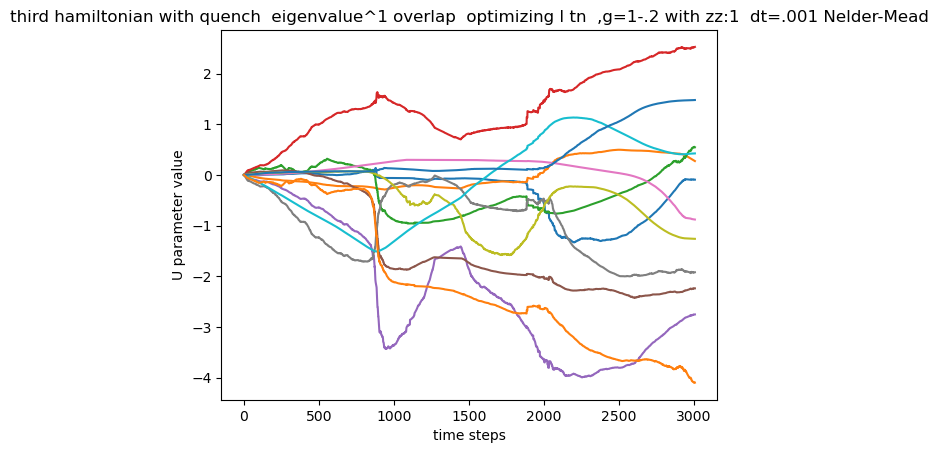

In [31]:
plt.plot(all_U_params-all_U_params[0])
plt.xlabel("time steps")
plt.ylabel("U parameter value")
plt.title(name.replace("_", " "))

Text(0.5, 1.0, 'third hamiltonian with quench  eigenvalue^1 overlap  optimizing l tn  ,g=1-.2 with zz:1  dt=.01 Nelder-Mead')

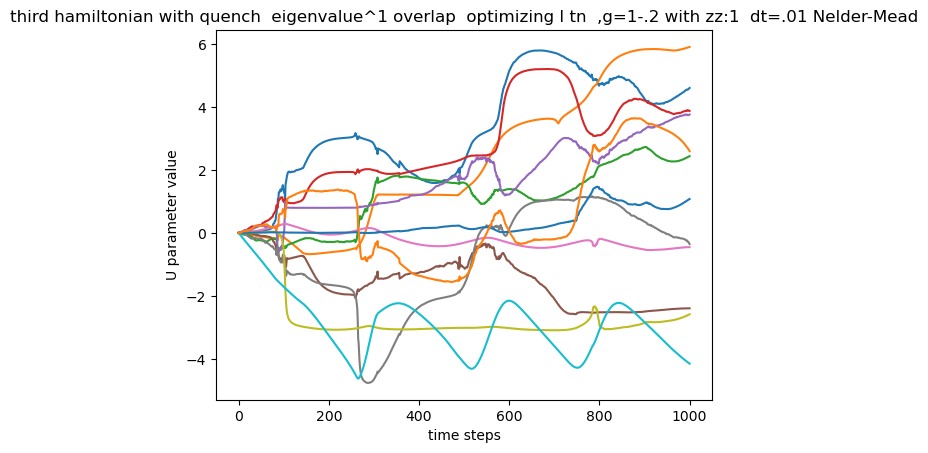

In [35]:
plt.plot(all_U_params-all_U_params[0])
plt.xlabel("time steps")
plt.ylabel("U parameter value")
plt.title(name.replace("_", " "))

## estimate scalar products (Loschmidt)

the following two implementations should give the same results and did so in my tests.

In [33]:
from scipy.linalg import eig, eigvals
def scalar_prod(ketMPS, braMPS):
    # in reality it gets the largest eigenvalue of the transfer matrix.
    # this eval to the power of the system size is the scalar product.
    # for iMPS that would always be either 1 or 0.
    id_qc = QuantumCircuit(2)
    transfer = get_transfer_matrix(ketMPS, braMPS, id_qc)
    eval = eigvals(transfer)
    #print(np.round(np.log10(np.abs(eval)), 3))
    #print(np.round(np.imag(eval[0]), 3))

    return np.max(np.sqrt(np.abs(eval)))

In [76]:
def scalar_prod(ketMPS, braMPS):
    # in reality it gets the largest eigenvalue of the transfer matrix.
    # this eval to the power of the system size is the scalar product.
    # for iMPS that would always be either 1 or 0.
    ket_U_mat = ketMPS.U_mat.to_matrix().T.reshape((2,)*4)[0]
    bra_U_mat = braMPS.Uinv_mat.to_matrix().T.reshape((2,)*4)[:,:,0,:]
    transfer = np.tensordot(ket_U_mat, bra_U_mat, (2,1))
    transfer = np.swapaxes(np.swapaxes(transfer, 1,3), 2,3).reshape((4,4)).T
    #print(transfer)
    
    eval = eigvals(transfer)
    #print(np.round(np.log10(np.abs(eval)), 3))
    #print(np.round(np.imag(eval[0]), 3))

    return np.max(np.abs(eval))

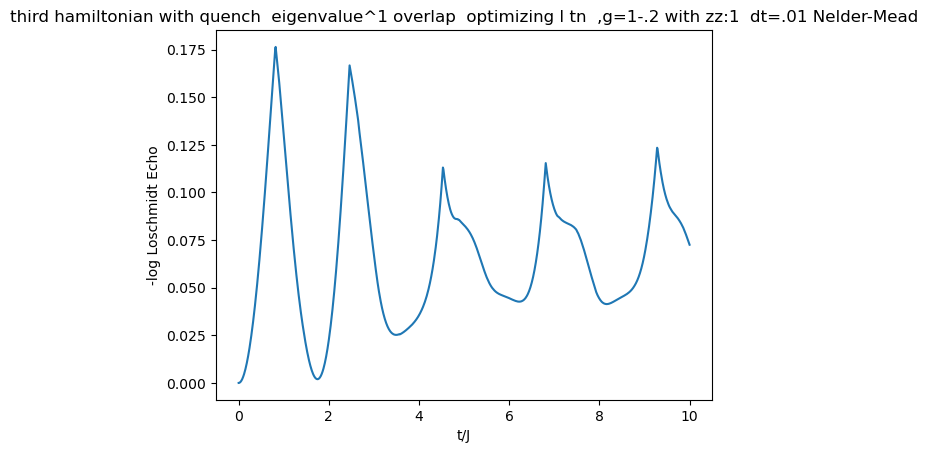

In [37]:
scalar_products = np.array([scalar_prod(all_mps[0], all_mps[i]) for i in range(len(all_mps))])

plt.plot(np.arange(0,len(scalar_products)*delta_t, delta_t), -np.log(scalar_products))
plt.xlabel("t/J")
plt.ylabel("-log Loschmidt Echo")
plt.title(name.replace("_", " "))
plt.savefig(f"results/{name}_LoschmidtEcho.pdf")

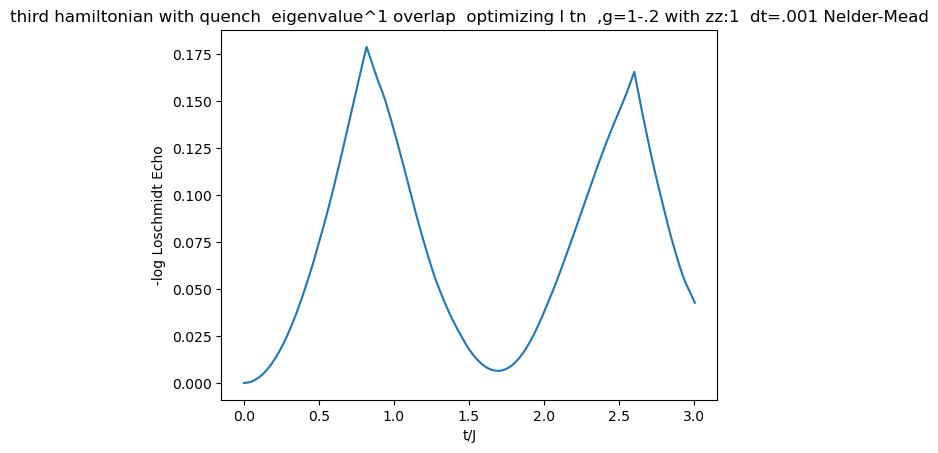

In [34]:
# this result had not been ready when the bachelor thesis was handed in.
scalar_products = np.array([scalar_prod(all_mps[0], all_mps[i]) for i in range(len(all_mps))])

plt.plot(np.arange(0,len(scalar_products)*delta_t, delta_t), -np.log(scalar_products))
plt.xlabel("t/J")
plt.ylabel("-log Loschmidt Echo")
plt.title(name.replace("_", " "))
plt.savefig(f"results/{name}_LoschmidtEcho.png")

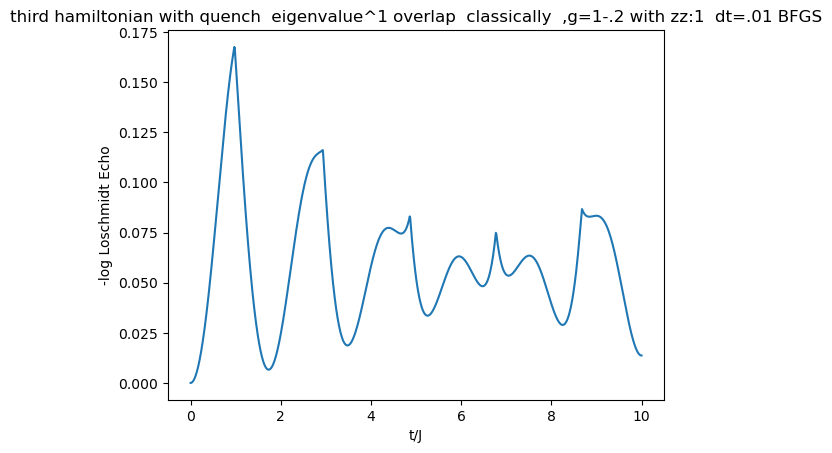

In [91]:
scalar_products = np.array([scalar_prod(all_mps[0], all_mps[i]) for i in range(len(all_mps))])

plt.plot(np.arange(0,len(scalar_products)*delta_t, delta_t), -np.log(scalar_products))
plt.xlabel("t/J")
plt.ylabel("-log Loschmidt Echo")
plt.title(name.replace("_", " "))
plt.savefig(f"results/{name}_LoschmidtEcho.png")

## scalar products comparison

In [ ]:
scalar_products_small_dt = scalar_products

In [ ]:
title = "comparison of time evolution for different time steps."

plt.plot(np.linspace(0, 5, 501), -np.log(scalar_products[:501]), label="$\\Delta t = 0.01$")
plt.plot(np.linspace(0, 5, 5001), -np.log(scalar_products_small_dt), label="$\\Delta t = 0.001$")
plt.xlabel("time t [1s]")
plt.ylabel("-log Loschmidt Echo")
plt.title(title)
plt.legend()
plt.savefig(f"results/{title}_LoschmidtEcho.png")

In [38]:
t = np.linspace(0, len(scalar_products)*delta_t, len(scalar_products))
print(g0, g1)
analytical_loschmidt = loschmidts(t, g0, g1)

1 0.2


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:577: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


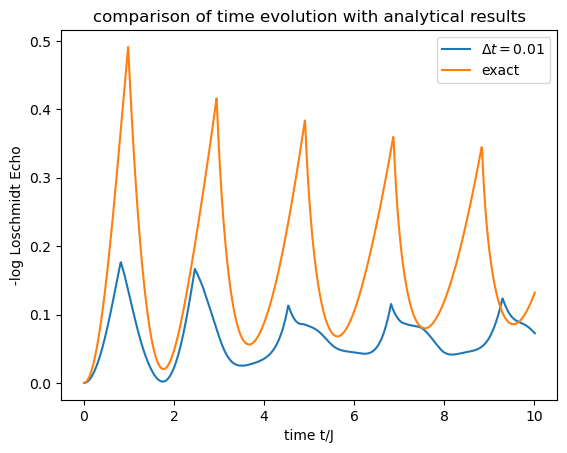

In [39]:
title = "comparison of time evolution with analytical results"


plt.plot(t, -np.log(scalar_products), label="$\\Delta t = 0.01$")
plt.plot(t, analytical_loschmidt, label="exact")
plt.xlabel("time t/J")
plt.ylabel("-log Loschmidt Echo")
plt.title(title)
plt.legend()
plt.savefig(f"results/{name},{title}_LoschmidtEcho.png")